# Preprocess data files

In [2]:
# Get starting frame timestamps for all the clips
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

# Relative path, no need to change
script_path = '../script/'

# Absolute path, change it according to data locations
data_path = '../../data-clean/'
feature_path = '../../feature-clean/'

In [34]:
# Create folder paths for all features
for folder in glob.glob(data_path + '*/'):
    folder = folder.split('data-clean/')[-1]
    os.system("mkdir " + feature_path + folder)
    
for folder in glob.glob(data_path + '*/*/'):
    folder = folder.split('data-clean/')[-1]
    os.system("mkdir " + feature_path + folder)
    
for folder in glob.glob(data_path + '*/*/*/'):
    folder = folder.split('data-clean/')[-1]
    os.system("mkdir " + feature_path + folder)
    os.system("mkdir " + feature_path + folder + "flow-netml")
    os.system("mkdir " + feature_path + folder + "pcap-netml")
    os.system("mkdir " + feature_path + folder + "csv")
    os.system("mkdir " + feature_path + folder + "nPrint")

In [88]:
for folder in glob.glob(data_path + '*/*/*/'):
    folder = folder.split('data-clean/')[-1]
    os.system("mkdir " + feature_path + folder + "mfcc")

## Filter by IP

In [35]:
def pcap_by_address(folder, device):
    os.system('cp ' + script_path + 'hiot_ipfilter_pcap2csv_' + device + '_clean.sh ' + data_path + folder)
    os.system('chmod +x ' + data_path + folder + '/hiot_ipfilter_pcap2csv_' + device + '_clean.sh')
#     print('sh ' + data_path + folder + '/hiot_ipfilter_pcap2csv.sh ' + folder)
    os.system('sh ' + data_path + folder + '/hiot_ipfilter_pcap2csv_' + device + '_clean.sh ' + folder) ## Should fix the path issue
    os.system('rm ' + data_path + folder + '/hiot_ipfilter_pcap2csv_' + device + '_clean.sh ')
  
def filter_by_ip(device):
    for folder in glob.glob(data_path + device + '/*/*'):
        print(folder.split('data-clean/')[-1])
        pcap_by_address(folder.split('data-clean/')[-1], device)

In [36]:
devices = ['refrigerator', 'alexa', 'nestcam']
# devices = ['alexa', 'nestcam']
for device in devices:
    filter_by_ip(device)

refrigerator/no_interaction/7
refrigerator/no_interaction/1
refrigerator/no_interaction/4
refrigerator/no_interaction/3
refrigerator/no_interaction/2
refrigerator/no_interaction/5
refrigerator/take_out_item/7
refrigerator/take_out_item/1
refrigerator/take_out_item/4
refrigerator/take_out_item/3
refrigerator/take_out_item/2
refrigerator/take_out_item/5
refrigerator/put_back_item/7
refrigerator/put_back_item/1
refrigerator/put_back_item/4
refrigerator/put_back_item/3
refrigerator/put_back_item/2
refrigerator/put_back_item/5
refrigerator/open_close_fridge/7
refrigerator/open_close_fridge/1
refrigerator/open_close_fridge/4
refrigerator/open_close_fridge/3
refrigerator/open_close_fridge/2
refrigerator/open_close_fridge/5
refrigerator/screen_interaction/7
refrigerator/screen_interaction/1
refrigerator/screen_interaction/4
refrigerator/screen_interaction/3
refrigerator/screen_interaction/2
refrigerator/screen_interaction/5
alexa/no_interaction/7
alexa/no_interaction/1
alexa/no_interaction/4
a

In [37]:
from pathlib import Path

for activity in glob.glob(feature_path + '*/*/'):
    i = 0
    print(activity.split("feature-clean/")[-1])
    for data in glob.glob(activity + '*/*.pcap'):
        i += 1
    print(i)

alexa/no_interaction/
51
alexa/play_music/
49
alexa/ask_weather/
50
refrigerator/no_interaction/
40
refrigerator/take_out_item/
65
refrigerator/put_back_item/
45
refrigerator/open_close_fridge/
78
refrigerator/screen_interaction/
41
nestcam/no_interaction/
50
nestcam/trigger_motion_detection/
50
nestcam/ask_time/
50


## Generate features

### netml

In [1]:
# sys.path.insert(1, '../../netml-dpkt/netml/src/') 
import pparser_pcap.parser as PP
from pparser_pcap.parser import PCAP
from utils.tool import dump_data

In [3]:
# import netml.pparser.parser as PP
# from netml.pparser.parser import PCAP
# from netml.utils.tool import dump_data
RANDOM_STATE = 42

# act_label = {"no_interaction": 0, 
#              "open_close_fridge": 1, 
#              "put_back_item": 2,
#              "screen_interaction": 3,
#              "take_out_item": 4} #, #"iotlab_open_dryer": 4, 
#              #"iotlab_open_washer": 5, "iotlab_open_dishwasher": 6, 
#              #"iotlab_browse_app_fridge": 4}

def save_flow_feats(pcap_file, act_label, activity):
#     feat_types = ['IAT','SIZE','IAT_SIZE','SAMP_NUM','SAMP_SIZE','STATS',
#                   'FFT-IAT','FFT-IAT_SIZE','FFT-SIZE','FFT-SAMP_NUM', 'FFT-SAMP_SIZE']
    feat_types =  ['STATS']
    file_name = pcap_file.split('feature-clean/')[-1]
    sub_path = ''
    for s in file_name.split('/')[:-1]:
        sub_path = sub_path + s + '/'
    file_name = file_name.split('.pcap')[-2].split('/')[-1]
    
    if Path(pcap_file).stat().st_size <= 100:
        for feat_type in feat_types:
            fft = False
            if feat_type[0:3] == 'FFT':
                fft = True
            # extract features from each flow given feat_type
#             pp.flow2features(feat_type=feat_type, fft=fft, header=False)

            # dump data to disk
            X, y = np.array([[0]*18, [0]*18]), np.array([1,1])
            out_dir = f'{feature_path}{sub_path}/pcap-netml/{feat_type}/'
            if os.path.isdir(out_dir) == False:
                os.mkdir(out_dir)
            dump_data((X, y), out_file=f'{out_dir}/{feat_type}_{file_name}.dat')
    else:
        pp = PCAP(pcap_file, verbose=0, random_state=RANDOM_STATE)
        pp.pcap2flows(q_interval=0.9)
        
        # label each flow with a label
        pp.label_flows(label_file = '', label = act_label[activity])

        for feat_type in feat_types:
            fft = False
            if feat_type[0:3] == 'FFT':
                fft = True
            # extract features from each flow given feat_type
            pp.flow2features(feat_type=feat_type, fft=fft, header=False)

            # dump data to disk
            X, y = pp.features, pp.labels
            out_dir = f'{feature_path}{sub_path}/pcap-netml/{feat_type}/'
            if os.path.isdir(out_dir) == False:
                os.mkdir(out_dir)
            dump_data((X, y), out_file=f'{out_dir}/{feat_type}_{file_name}.dat')

In [4]:
def netml_save_flow_activity(device, act_label, activity):
    for pcap_file in glob.glob(feature_path + device + '/' + activity + '/*/*.pcap'):
        print(pcap_file)
        save_flow_feats(pcap_file.split('data-clean/')[-1], act_label, activity)

In [5]:
# For refrigerator
fridge_act_label = {"no_interaction": 0, 
                    "open_close_fridge": 1, 
                    "put_back_item": 2,
                    "screen_interaction": 3,
                    "take_out_item": 4}
# fridge_act_label = {"screen_interaction": 3}
for act in fridge_act_label:
    netml_save_flow_activity('refrigerator', fridge_act_label, act)

../../feature-clean/refrigerator/no_interaction/7/no_interaction_14_1615406418_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:11
'_pcap2flows()' ends at 2021-04-13 15:24:11 and takes 0.0001 mins.
'_label_flows()' starts at 2021-04-13 15:24:11
'_label_flows()' ends at 2021-04-13 15:24:11 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:11
'_flow2features()' ends at 2021-04-13 15:24:11 and takes 0.0 mins.
../../feature-clean/refrigerator/no_interaction/7/no_interaction_16_1615406875_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:11
'_pcap2flows()' ends at 2021-04-13 15:24:11 and takes 0.0001 mins.
'_label_flows()' starts at 2021-04-13 15:24:11
'_label_flows()' ends at 2021-04-13 15:24:11 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:11
'_flow2features()' ends at 2021-04-13 15:24:11 and takes 0.0001 mins.
../../feature-clean/refrigerator/no_interaction/7/no_interaction_6_1615405986_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 

'_flow2features()' ends at 2021-04-13 15:24:12 and takes 0.0 mins.
../../feature-clean/refrigerator/no_interaction/4/no_interaction_6_1616182758_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:12
'_pcap2flows()' ends at 2021-04-13 15:24:12 and takes 0.0001 mins.
'_label_flows()' starts at 2021-04-13 15:24:12
'_label_flows()' ends at 2021-04-13 15:24:12 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:12
'_flow2features()' ends at 2021-04-13 15:24:12 and takes 0.0 mins.
../../feature-clean/refrigerator/no_interaction/4/no_interaction_3_1616182553_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:12
'_pcap2flows()' ends at 2021-04-13 15:24:12 and takes 0.0001 mins.
'_label_flows()' starts at 2021-04-13 15:24:12
'_label_flows()' ends at 2021-04-13 15:24:12 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:12
'_flow2features()' ends at 2021-04-13 15:24:12 and takes 0.0 mins.
../../feature-clean/refrigerator/no_interaction/4/no_interaction_7_

'_pcap2flows()' ends at 2021-04-13 15:24:12 and takes 0.0004 mins.
'_label_flows()' starts at 2021-04-13 15:24:12
'_label_flows()' ends at 2021-04-13 15:24:12 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:12
'_flow2features()' ends at 2021-04-13 15:24:12 and takes 0.0001 mins.
../../feature-clean/refrigerator/open_close_fridge/7/open_close_fridge_20_1615399148_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:12
'_pcap2flows()' ends at 2021-04-13 15:24:12 and takes 0.0004 mins.
'_label_flows()' starts at 2021-04-13 15:24:12
'_label_flows()' ends at 2021-04-13 15:24:12 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:12
'_flow2features()' ends at 2021-04-13 15:24:12 and takes 0.0001 mins.
../../feature-clean/refrigerator/open_close_fridge/7/open_close_fridge_12_1615398601_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:12
'_pcap2flows()' ends at 2021-04-13 15:24:12 and takes 0.0003 mins.
'_label_flows()' starts at 2021-04-13 15:24:12


'_pcap2flows()' ends at 2021-04-13 15:24:13 and takes 0.0004 mins.
'_label_flows()' starts at 2021-04-13 15:24:13
'_label_flows()' ends at 2021-04-13 15:24:13 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:13
'_flow2features()' ends at 2021-04-13 15:24:13 and takes 0.0002 mins.
../../feature-clean/refrigerator/open_close_fridge/1/open_close_fridge_2_1615392660_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:13
'_pcap2flows()' ends at 2021-04-13 15:24:13 and takes 0.0004 mins.
'_label_flows()' starts at 2021-04-13 15:24:13
'_label_flows()' ends at 2021-04-13 15:24:13 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:13
'_flow2features()' ends at 2021-04-13 15:24:13 and takes 0.0001 mins.
../../feature-clean/refrigerator/open_close_fridge/1/open_close_fridge_2_1613680696_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:13
'_pcap2flows()' ends at 2021-04-13 15:24:13 and takes 0.0004 mins.
'_label_flows()' starts at 2021-04-13 15:24:13
'_

'_flow2features()' ends at 2021-04-13 15:24:14 and takes 0.0001 mins.
../../feature-clean/refrigerator/open_close_fridge/1/open_close_fridge_5_1613085652_filtered.pcap
../../feature-clean/refrigerator/open_close_fridge/4/open_close_fridge_10_1616179173_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:14
'_pcap2flows()' ends at 2021-04-13 15:24:14 and takes 0.0005 mins.
'_label_flows()' starts at 2021-04-13 15:24:14
'_label_flows()' ends at 2021-04-13 15:24:14 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:14
'_flow2features()' ends at 2021-04-13 15:24:14 and takes 0.0001 mins.
../../feature-clean/refrigerator/open_close_fridge/4/open_close_fridge_4_1616178503_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:14
'_pcap2flows()' ends at 2021-04-13 15:24:14 and takes 0.0004 mins.
'_label_flows()' starts at 2021-04-13 15:24:14
'_label_flows()' ends at 2021-04-13 15:24:14 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:14
'_flow2features()

'_flow2features()' ends at 2021-04-13 15:24:14 and takes 0.0001 mins.
../../feature-clean/refrigerator/open_close_fridge/5/open_close_fridge_8_1614111607_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:14
'_pcap2flows()' ends at 2021-04-13 15:24:14 and takes 0.0003 mins.
'_label_flows()' starts at 2021-04-13 15:24:14
'_label_flows()' ends at 2021-04-13 15:24:14 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:14
'_flow2features()' ends at 2021-04-13 15:24:14 and takes 0.0001 mins.
../../feature-clean/refrigerator/open_close_fridge/5/open_close_fridge_9_1614111650_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:14
'_pcap2flows()' ends at 2021-04-13 15:24:15 and takes 0.0003 mins.
'_label_flows()' starts at 2021-04-13 15:24:15
'_label_flows()' ends at 2021-04-13 15:24:15 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:15
'_flow2features()' ends at 2021-04-13 15:24:15 and takes 0.0002 mins.
../../feature-clean/refrigerator/open_close_fr

'_pcap2flows()' ends at 2021-04-13 15:24:15 and takes 0.0006 mins.
'_label_flows()' starts at 2021-04-13 15:24:15
'_label_flows()' ends at 2021-04-13 15:24:15 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:15
'_flow2features()' ends at 2021-04-13 15:24:15 and takes 0.0002 mins.
../../feature-clean/refrigerator/put_back_item/7/put_back_item_5_1615400678_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:15
'_pcap2flows()' ends at 2021-04-13 15:24:15 and takes 0.0005 mins.
'_label_flows()' starts at 2021-04-13 15:24:15
'_label_flows()' ends at 2021-04-13 15:24:15 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:15
'_flow2features()' ends at 2021-04-13 15:24:15 and takes 0.0001 mins.
../../feature-clean/refrigerator/put_back_item/7/put_back_item_17_1615401320_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:15
'_pcap2flows()' ends at 2021-04-13 15:24:15 and takes 0.0004 mins.
'_label_flows()' starts at 2021-04-13 15:24:15
'_label_flows()' 

'_pcap2flows()' ends at 2021-04-13 15:24:16 and takes 0.0004 mins.
'_label_flows()' starts at 2021-04-13 15:24:16
'_label_flows()' ends at 2021-04-13 15:24:16 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:16
'_flow2features()' ends at 2021-04-13 15:24:16 and takes 0.0001 mins.
../../feature-clean/refrigerator/put_back_item/2/put_back_item_10_1614037993_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:16
'_pcap2flows()' ends at 2021-04-13 15:24:16 and takes 0.0003 mins.
'_label_flows()' starts at 2021-04-13 15:24:16
'_label_flows()' ends at 2021-04-13 15:24:16 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:16
'_flow2features()' ends at 2021-04-13 15:24:16 and takes 0.0002 mins.
../../feature-clean/refrigerator/put_back_item/2/put_back_item_8_1614037842_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:16
'_pcap2flows()' ends at 2021-04-13 15:24:16 and takes 0.0004 mins.
'_label_flows()' starts at 2021-04-13 15:24:16
'_label_flows()' 

'_flow2features()' ends at 2021-04-13 15:24:18 and takes 0.0002 mins.
../../feature-clean/refrigerator/screen_interaction/7/screen_interaction_13_1615405171_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:18
'_pcap2flows()' ends at 2021-04-13 15:24:19 and takes 0.0066 mins.
'_label_flows()' starts at 2021-04-13 15:24:19
'_label_flows()' ends at 2021-04-13 15:24:19 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:19
'_flow2features()' ends at 2021-04-13 15:24:19 and takes 0.0014 mins.
../../feature-clean/refrigerator/screen_interaction/7/screen_interaction_14_1615405286_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:19
'_pcap2flows()' ends at 2021-04-13 15:24:19 and takes 0.0008 mins.
'_label_flows()' starts at 2021-04-13 15:24:19
'_label_flows()' ends at 2021-04-13 15:24:19 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:19
'_flow2features()' ends at 2021-04-13 15:24:19 and takes 0.0003 mins.
../../feature-clean/refrigerator/screen_

'_pcap2flows()' ends at 2021-04-13 15:24:24 and takes 0.0056 mins.
'_label_flows()' starts at 2021-04-13 15:24:24
'_label_flows()' ends at 2021-04-13 15:24:24 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:24
'_flow2features()' ends at 2021-04-13 15:24:24 and takes 0.0013 mins.
../../feature-clean/refrigerator/screen_interaction/2/screen_interaction_4_1614038223_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:24
'_pcap2flows()' ends at 2021-04-13 15:24:24 and takes 0.0045 mins.
'_label_flows()' starts at 2021-04-13 15:24:24
'_label_flows()' ends at 2021-04-13 15:24:24 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:24
'_flow2features()' ends at 2021-04-13 15:24:24 and takes 0.0013 mins.
../../feature-clean/refrigerator/screen_interaction/2/screen_interaction_5_1614038290_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:24
'_pcap2flows()' ends at 2021-04-13 15:24:25 and takes 0.0062 mins.
'_label_flows()' starts at 2021-04-13 15:24:2

'_pcap2flows()' ends at 2021-04-13 15:24:27 and takes 0.0004 mins.
'_label_flows()' starts at 2021-04-13 15:24:27
'_label_flows()' ends at 2021-04-13 15:24:27 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:27
'_flow2features()' ends at 2021-04-13 15:24:27 and takes 0.0002 mins.
../../feature-clean/refrigerator/take_out_item/7/take_out_item_16_1615400211_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:27
'_pcap2flows()' ends at 2021-04-13 15:24:27 and takes 0.0005 mins.
'_label_flows()' starts at 2021-04-13 15:24:27
'_label_flows()' ends at 2021-04-13 15:24:27 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:27
'_flow2features()' ends at 2021-04-13 15:24:27 and takes 0.0002 mins.
../../feature-clean/refrigerator/take_out_item/7/take_out_item_19_1615400369_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:27
'_pcap2flows()' ends at 2021-04-13 15:24:27 and takes 0.0004 mins.
'_label_flows()' starts at 2021-04-13 15:24:27
'_label_flows()'

'_flow2features()' ends at 2021-04-13 15:24:28 and takes 0.0001 mins.
../../feature-clean/refrigerator/take_out_item/1/take_out_item_5_1613086029_filtered.pcap
../../feature-clean/refrigerator/take_out_item/1/take_out_item_6_1615394179_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:28
'_pcap2flows()' ends at 2021-04-13 15:24:28 and takes 0.0003 mins.
'_label_flows()' starts at 2021-04-13 15:24:28
'_label_flows()' ends at 2021-04-13 15:24:28 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:28
'_flow2features()' ends at 2021-04-13 15:24:28 and takes 0.0001 mins.
../../feature-clean/refrigerator/take_out_item/4/take_out_item_1_1616179317_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:28
'_pcap2flows()' ends at 2021-04-13 15:24:28 and takes 0.0003 mins.
'_label_flows()' starts at 2021-04-13 15:24:28
'_label_flows()' ends at 2021-04-13 15:24:28 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:28
'_flow2features()' ends at 2021-04-13 15:2

'_pcap2flows()' ends at 2021-04-13 15:24:29 and takes 0.0003 mins.
'_label_flows()' starts at 2021-04-13 15:24:29
'_label_flows()' ends at 2021-04-13 15:24:29 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:29
'_flow2features()' ends at 2021-04-13 15:24:29 and takes 0.0001 mins.
../../feature-clean/refrigerator/take_out_item/5/take_out_item_3_1614112124_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:29
'_pcap2flows()' ends at 2021-04-13 15:24:30 and takes 0.0161 mins.
'_label_flows()' starts at 2021-04-13 15:24:30
'_label_flows()' ends at 2021-04-13 15:24:30 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:30
'_flow2features()' ends at 2021-04-13 15:24:30 and takes 0.0037 mins.


In [18]:
# feat_types = ['IAT','SIZE','IAT_SIZE','SAMP_NUM','SAMP_SIZE','STATS',
#                   'FFT-IAT','FFT-IAT_SIZE','FFT-SIZE','FFT-SAMP_NUM', 'FFT-SAMP_SIZE']
feat_types = ['STATS']

def load_data(in_file):
    with open(in_file, 'rb') as f:
        data = pickle.load(f)
    return data

for feat_type in feat_types:
    file = f'/Users/shinanliu/Documents/Auto-labeling/HIoT/feature-clean/refrigerator/open_close_fridge/7/pcap-netml/{feat_type}/{feat_type}_open_close_fridge_15_1615398915_filtered.dat'
    print(feat_type)
    print(load_data(file))

STATS
(array([[2.80170290e+01, 5.63942735e+00, 3.89045533e+03, 6.89867089e+02,
        6.68678331e+02, 5.20000000e+01, 4.65500000e+02, 1.40125000e+03,
        4.00000000e+01, 2.94800000e+03, 1.78452414e-01, 7.77907304e-01,
        1.08957291e-04, 1.56164169e-04, 2.50060558e-02, 8.82148743e-06,
        5.30393696e+00, 1.40000000e+01],
       [2.80092950e+01, 3.57024338e+00, 1.25761823e+03, 3.52250000e+02,
        8.92446798e+02, 5.20000000e+01, 5.20000000e+01, 1.00000000e+02,
        4.00000000e+01, 4.14800000e+03, 2.82922172e-01, 9.71168294e-01,
        2.10881233e-04, 2.45594978e-03, 6.76848888e-02, 1.09672546e-05,
        5.30717707e+00, 1.30000000e+01]]), array([1, 1]))


In [7]:
# For alexa
alexa_act_label = {"no_interaction": 5, 
                   "ask_weather": 6, 
                   "play_music": 7}

for act in alexa_act_label:
    netml_save_flow_activity('alexa', alexa_act_label, act)

../../feature-clean/alexa/no_interaction/7/no_interaction_9_1615411933_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:30
'_pcap2flows()' ends at 2021-04-13 15:24:30 and takes 0.0001 mins.
'_label_flows()' starts at 2021-04-13 15:24:30
'_label_flows()' ends at 2021-04-13 15:24:30 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:30
'_flow2features()' ends at 2021-04-13 15:24:30 and takes 0.0001 mins.
../../feature-clean/alexa/no_interaction/7/no_interaction_7_1615411816_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:30
'_pcap2flows()' ends at 2021-04-13 15:24:30 and takes 0.0 mins.
'_label_flows()' starts at 2021-04-13 15:24:30
'_label_flows()' ends at 2021-04-13 15:24:30 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:30
'_flow2features()' ends at 2021-04-13 15:24:30 and takes 0.0001 mins.
../../feature-clean/alexa/no_interaction/7/no_interaction_19_1615412535_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:30
'_pcap2flows(

'_pcap2flows()' ends at 2021-04-13 15:24:30 and takes 0.0001 mins.
'_label_flows()' starts at 2021-04-13 15:24:30
'_label_flows()' ends at 2021-04-13 15:24:30 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:30
'_flow2features()' ends at 2021-04-13 15:24:30 and takes 0.0001 mins.
../../feature-clean/alexa/no_interaction/4/no_interaction_4_1616185931_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:30
'_pcap2flows()' ends at 2021-04-13 15:24:30 and takes 0.0001 mins.
'_label_flows()' starts at 2021-04-13 15:24:30
'_label_flows()' ends at 2021-04-13 15:24:30 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:30
'_flow2features()' ends at 2021-04-13 15:24:30 and takes 0.0001 mins.
../../feature-clean/alexa/no_interaction/4/no_interaction_6_1616186419_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:30
'_pcap2flows()' ends at 2021-04-13 15:24:30 and takes 0.0001 mins.
'_label_flows()' starts at 2021-04-13 15:24:30
'_label_flows()' ends at 202

'_flow2features()' ends at 2021-04-13 15:24:31 and takes 0.0001 mins.
../../feature-clean/alexa/no_interaction/2/no_interaction_4_1614040912_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:31
'_pcap2flows()' ends at 2021-04-13 15:24:31 and takes 0.0 mins.
'_label_flows()' starts at 2021-04-13 15:24:31
'_label_flows()' ends at 2021-04-13 15:24:31 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:31
'_flow2features()' ends at 2021-04-13 15:24:31 and takes 0.0 mins.
../../feature-clean/alexa/no_interaction/2/no_interaction_1_1614040772_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:31
'_pcap2flows()' ends at 2021-04-13 15:24:31 and takes 0.0001 mins.
'_label_flows()' starts at 2021-04-13 15:24:31
'_label_flows()' ends at 2021-04-13 15:24:31 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:31
'_flow2features()' ends at 2021-04-13 15:24:31 and takes 0.0001 mins.
../../feature-clean/alexa/no_interaction/2/no_interaction_9_1614041156_filtere

'_pcap2flows()' ends at 2021-04-13 15:24:32 and takes 0.0008 mins.
'_label_flows()' starts at 2021-04-13 15:24:32
'_label_flows()' ends at 2021-04-13 15:24:32 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:32
'_flow2features()' ends at 2021-04-13 15:24:32 and takes 0.0002 mins.
../../feature-clean/alexa/ask_weather/7/ask_weather_20_1615409979_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:32
'_pcap2flows()' ends at 2021-04-13 15:24:32 and takes 0.0008 mins.
'_label_flows()' starts at 2021-04-13 15:24:32
'_label_flows()' ends at 2021-04-13 15:24:32 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:32
'_flow2features()' ends at 2021-04-13 15:24:32 and takes 0.0002 mins.
../../feature-clean/alexa/ask_weather/7/ask_weather_17_1615409773_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:32
'_pcap2flows()' ends at 2021-04-13 15:24:32 and takes 0.0008 mins.
'_label_flows()' starts at 2021-04-13 15:24:32
'_label_flows()' ends at 2021-04-13 15

'_pcap2flows()' ends at 2021-04-13 15:24:33 and takes 0.0008 mins.
'_label_flows()' starts at 2021-04-13 15:24:33
'_label_flows()' ends at 2021-04-13 15:24:33 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:33
'_flow2features()' ends at 2021-04-13 15:24:33 and takes 0.0002 mins.
../../feature-clean/alexa/ask_weather/3/ask_weather_4_1615491506_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:33
'_pcap2flows()' ends at 2021-04-13 15:24:33 and takes 0.0007 mins.
'_label_flows()' starts at 2021-04-13 15:24:33
'_label_flows()' ends at 2021-04-13 15:24:33 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:33
'_flow2features()' ends at 2021-04-13 15:24:33 and takes 0.0002 mins.
../../feature-clean/alexa/ask_weather/3/ask_weather_9_1615491827_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:33
'_pcap2flows()' ends at 2021-04-13 15:24:33 and takes 0.0007 mins.
'_label_flows()' starts at 2021-04-13 15:24:33
'_label_flows()' ends at 2021-04-13 15:2

'_flow2features()' ends at 2021-04-13 15:24:35 and takes 0.0007 mins.
../../feature-clean/alexa/play_music/7/play_music_9_1615410681_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:35
'_pcap2flows()' ends at 2021-04-13 15:24:35 and takes 0.0023 mins.
'_label_flows()' starts at 2021-04-13 15:24:35
'_label_flows()' ends at 2021-04-13 15:24:35 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:35
'_flow2features()' ends at 2021-04-13 15:24:35 and takes 0.0006 mins.
../../feature-clean/alexa/play_music/7/play_music_14_1615410985_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:35
'_pcap2flows()' ends at 2021-04-13 15:24:35 and takes 0.0023 mins.
'_label_flows()' starts at 2021-04-13 15:24:35
'_label_flows()' ends at 2021-04-13 15:24:35 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:35
'_flow2features()' ends at 2021-04-13 15:24:35 and takes 0.0006 mins.
../../feature-clean/alexa/play_music/7/play_music_10_1615410736_filtered.pcap
'_pcap2fl

'_flow2features()' ends at 2021-04-13 15:24:38 and takes 0.0008 mins.
../../feature-clean/alexa/play_music/4/play_music_8_1616185443_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:38
'_pcap2flows()' ends at 2021-04-13 15:24:39 and takes 0.0028 mins.
'_label_flows()' starts at 2021-04-13 15:24:39
'_label_flows()' ends at 2021-04-13 15:24:39 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:39
'_flow2features()' ends at 2021-04-13 15:24:39 and takes 0.0008 mins.
../../feature-clean/alexa/play_music/4/play_music_5_1616185068_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:39
'_pcap2flows()' ends at 2021-04-13 15:24:39 and takes 0.0029 mins.
'_label_flows()' starts at 2021-04-13 15:24:39
'_label_flows()' ends at 2021-04-13 15:24:39 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:39
'_flow2features()' ends at 2021-04-13 15:24:39 and takes 0.0007 mins.
../../feature-clean/alexa/play_music/4/play_music_1_1616184621_filtered.pcap
'_pcap2flow

'_flow2features()' ends at 2021-04-13 15:24:42 and takes 0.0007 mins.
../../feature-clean/alexa/play_music/2/play_music_8_1614040535_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:42
'_pcap2flows()' ends at 2021-04-13 15:24:43 and takes 0.0028 mins.
'_label_flows()' starts at 2021-04-13 15:24:43
'_label_flows()' ends at 2021-04-13 15:24:43 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:43
'_flow2features()' ends at 2021-04-13 15:24:43 and takes 0.0007 mins.
../../feature-clean/alexa/play_music/2/play_music_3_1614040169_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:43
'_pcap2flows()' ends at 2021-04-13 15:24:43 and takes 0.0026 mins.
'_label_flows()' starts at 2021-04-13 15:24:43
'_label_flows()' ends at 2021-04-13 15:24:43 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:43
'_flow2features()' ends at 2021-04-13 15:24:43 and takes 0.0006 mins.
../../feature-clean/alexa/play_music/2/play_music_6_1614040358_filtered.pcap
'_pcap2flow

In [8]:
# For nestcam
nestcam_act_label = {"no_interaction": 8, 
                     "ask_time": 9, 
                     "trigger_motion_detection": 10}

for act in nestcam_act_label:
    netml_save_flow_activity('nestcam', nestcam_act_label, act)

../../feature-clean/nestcam/no_interaction/7/no_interaction_8_1615415542_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:43
'_pcap2flows()' ends at 2021-04-13 15:24:43 and takes 0.0011 mins.
'_label_flows()' starts at 2021-04-13 15:24:43
'_label_flows()' ends at 2021-04-13 15:24:43 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:43
'_flow2features()' ends at 2021-04-13 15:24:44 and takes 0.0003 mins.
../../feature-clean/nestcam/no_interaction/7/no_interaction_19_1615416193_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:44
'_pcap2flows()' ends at 2021-04-13 15:24:44 and takes 0.0013 mins.
'_label_flows()' starts at 2021-04-13 15:24:44
'_label_flows()' ends at 2021-04-13 15:24:44 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:44
'_flow2features()' ends at 2021-04-13 15:24:44 and takes 0.0003 mins.
../../feature-clean/nestcam/no_interaction/7/no_interaction_11_1615415812_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:44
'_p

'_pcap2flows()' ends at 2021-04-13 15:24:45 and takes 0.0012 mins.
'_label_flows()' starts at 2021-04-13 15:24:45
'_label_flows()' ends at 2021-04-13 15:24:45 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:45
'_flow2features()' ends at 2021-04-13 15:24:45 and takes 0.0004 mins.
../../feature-clean/nestcam/no_interaction/4/no_interaction_3_1616188517_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:45
'_pcap2flows()' ends at 2021-04-13 15:24:45 and takes 0.0008 mins.
'_label_flows()' starts at 2021-04-13 15:24:45
'_label_flows()' ends at 2021-04-13 15:24:45 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:45
'_flow2features()' ends at 2021-04-13 15:24:45 and takes 0.0002 mins.
../../feature-clean/nestcam/no_interaction/4/no_interaction_2_1616188294_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:45
'_pcap2flows()' ends at 2021-04-13 15:24:46 and takes 0.0057 mins.
'_label_flows()' starts at 2021-04-13 15:24:46
'_label_flows()' ends at

'_pcap2flows()' ends at 2021-04-13 15:24:47 and takes 0.0009 mins.
'_label_flows()' starts at 2021-04-13 15:24:47
'_label_flows()' ends at 2021-04-13 15:24:47 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:47
'_flow2features()' ends at 2021-04-13 15:24:48 and takes 0.0003 mins.
../../feature-clean/nestcam/no_interaction/2/no_interaction_5_1614905286_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:48
'_pcap2flows()' ends at 2021-04-13 15:24:48 and takes 0.0009 mins.
'_label_flows()' starts at 2021-04-13 15:24:48
'_label_flows()' ends at 2021-04-13 15:24:48 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:48
'_flow2features()' ends at 2021-04-13 15:24:48 and takes 0.0003 mins.
../../feature-clean/nestcam/no_interaction/2/no_interaction_7_1614905367_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:48
'_pcap2flows()' ends at 2021-04-13 15:24:48 and takes 0.0009 mins.
'_label_flows()' starts at 2021-04-13 15:24:48
'_label_flows()' ends at

'_pcap2flows()' ends at 2021-04-13 15:24:50 and takes 0.0019 mins.
'_label_flows()' starts at 2021-04-13 15:24:50
'_label_flows()' ends at 2021-04-13 15:24:50 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:50
'_flow2features()' ends at 2021-04-13 15:24:50 and takes 0.0005 mins.
../../feature-clean/nestcam/ask_time/7/ask_time_15_1615414722_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:50
'_pcap2flows()' ends at 2021-04-13 15:24:50 and takes 0.0016 mins.
'_label_flows()' starts at 2021-04-13 15:24:50
'_label_flows()' ends at 2021-04-13 15:24:50 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:50
'_flow2features()' ends at 2021-04-13 15:24:50 and takes 0.0004 mins.
../../feature-clean/nestcam/ask_time/7/ask_time_4_1615414122_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:50
'_pcap2flows()' ends at 2021-04-13 15:24:50 and takes 0.0016 mins.
'_label_flows()' starts at 2021-04-13 15:24:50
'_label_flows()' ends at 2021-04-13 15:24:50 an

'_pcap2flows()' ends at 2021-04-13 15:24:52 and takes 0.0019 mins.
'_label_flows()' starts at 2021-04-13 15:24:52
'_label_flows()' ends at 2021-04-13 15:24:52 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:52
'_flow2features()' ends at 2021-04-13 15:24:52 and takes 0.0006 mins.
../../feature-clean/nestcam/ask_time/3/ask_time_5_1615494599_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:52
'_pcap2flows()' ends at 2021-04-13 15:24:52 and takes 0.002 mins.
'_label_flows()' starts at 2021-04-13 15:24:52
'_label_flows()' ends at 2021-04-13 15:24:52 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:52
'_flow2features()' ends at 2021-04-13 15:24:53 and takes 0.0006 mins.
../../feature-clean/nestcam/ask_time/3/ask_time_8_1615494806_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:53
'_pcap2flows()' ends at 2021-04-13 15:24:53 and takes 0.0021 mins.
'_label_flows()' starts at 2021-04-13 15:24:53
'_label_flows()' ends at 2021-04-13 15:24:53 and 

'_pcap2flows()' ends at 2021-04-13 15:24:55 and takes 0.0013 mins.
'_label_flows()' starts at 2021-04-13 15:24:55
'_label_flows()' ends at 2021-04-13 15:24:55 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:55
'_flow2features()' ends at 2021-04-13 15:24:55 and takes 0.0004 mins.
../../feature-clean/nestcam/trigger_motion_detection/7/trigger_motion_detection_2_1615413070_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:55
'_pcap2flows()' ends at 2021-04-13 15:24:56 and takes 0.0012 mins.
'_label_flows()' starts at 2021-04-13 15:24:56
'_label_flows()' ends at 2021-04-13 15:24:56 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:56
'_flow2features()' ends at 2021-04-13 15:24:56 and takes 0.0003 mins.
../../feature-clean/nestcam/trigger_motion_detection/7/trigger_motion_detection_19_1615413865_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:56
'_pcap2flows()' ends at 2021-04-13 15:24:56 and takes 0.0012 mins.
'_label_flows()' starts at 202

'_pcap2flows()' ends at 2021-04-13 15:24:57 and takes 0.0011 mins.
'_label_flows()' starts at 2021-04-13 15:24:57
'_label_flows()' ends at 2021-04-13 15:24:57 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:57
'_flow2features()' ends at 2021-04-13 15:24:57 and takes 0.0004 mins.
../../feature-clean/nestcam/trigger_motion_detection/4/trigger_motion_detection_8_1616187391_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:57
'_pcap2flows()' ends at 2021-04-13 15:24:57 and takes 0.0021 mins.
'_label_flows()' starts at 2021-04-13 15:24:57
'_label_flows()' ends at 2021-04-13 15:24:57 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:24:57
'_flow2features()' ends at 2021-04-13 15:24:57 and takes 0.0005 mins.
../../feature-clean/nestcam/trigger_motion_detection/4/trigger_motion_detection_9_1616187455_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:24:57
'_pcap2flows()' ends at 2021-04-13 15:24:58 and takes 0.0014 mins.
'_label_flows()' starts at 2021

'_pcap2flows()' ends at 2021-04-13 15:25:00 and takes 0.0018 mins.
'_label_flows()' starts at 2021-04-13 15:25:00
'_label_flows()' ends at 2021-04-13 15:25:00 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:25:00
'_flow2features()' ends at 2021-04-13 15:25:00 and takes 0.0005 mins.
../../feature-clean/nestcam/trigger_motion_detection/3/trigger_motion_detection_1_1615493599_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:25:00
'_pcap2flows()' ends at 2021-04-13 15:25:00 and takes 0.0016 mins.
'_label_flows()' starts at 2021-04-13 15:25:00
'_label_flows()' ends at 2021-04-13 15:25:00 and takes 0.0 mins.
'_flow2features()' starts at 2021-04-13 15:25:00
'_flow2features()' ends at 2021-04-13 15:25:00 and takes 0.0005 mins.
../../feature-clean/nestcam/trigger_motion_detection/2/trigger_motion_detection_3_1614903037_filtered.pcap
'_pcap2flows()' starts at 2021-04-13 15:25:00
'_pcap2flows()' ends at 2021-04-13 15:25:00 and takes 0.0019 mins.
'_label_flows()' starts at 2021

In [9]:
from pathlib import Path

for activity in glob.glob(feature_path + '*/*/'):
    i = 0
    print(activity.split("feature-clean/")[-1])
    for data in glob.glob(activity + '*/pcap-netml/STATS/*.dat'):
        i += 1
    print(i)

alexa/no_interaction/
51
alexa/play_music/
49
alexa/ask_weather/
50
refrigerator/no_interaction/
40
refrigerator/take_out_item/
65
refrigerator/put_back_item/
45
refrigerator/open_close_fridge/
78
refrigerator/screen_interaction/
41
nestcam/no_interaction/
50
nestcam/trigger_motion_detection/
50
nestcam/ask_time/
50


## outbound + inbound

In [7]:
import pickle
feat_types = ['IAT','SIZE','IAT_SIZE','SAMP_NUM','SAMP_SIZE','STATS',
                  'FFT-IAT','FFT-IAT_SIZE','FFT-SIZE','FFT-SAMP_NUM', 'FFT-SAMP_SIZE']

def load_data(in_file):
    with open(in_file, 'rb') as f:
        data = pickle.load(f)
    return data

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.multiclass import OneVsRestClassifier
## Gussian, LogReg
from sklearn.svm import LinearSVC

from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# kf = KFold(n_splits=5, random_state=42)
classifiers = {"DecTree": DecisionTreeClassifier(random_state=42),
               "LogReg": LogisticRegression(random_state=42),
               "OvOSVC": OneVsOneClassifier(SVC(random_state=42)), 
#                OneVsOneClassifier(NuSVC(random_state=42)),
               "OvOGP": OneVsOneClassifier(GaussianProcessClassifier(random_state=42)),
               "OvRLinearSVC": OneVsRestClassifier(LinearSVC(random_state=42)), 
               "OvRLogReg": OneVsRestClassifier(LogisticRegression(random_state=42)),
               "OvRGP":OneVsRestClassifier(GaussianProcessClassifier(random_state=42)),
              }

/Users/shinanliu/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/shinanliu/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/shinanliu/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf, feat_type, key, exp_name,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        row_sum = np.sum(cf, axis = 1)
        cf_row_sum = np.array([[value] * len(row_sum) for value in row_sum]).flatten()
#         print(cf_row_sum)
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/cf_row_sum]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf/np.sum(cf, axis = 1),annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        
    plt.savefig('../plots/' + feat_type + '_' + key + '_' + exp_name + '_pcap_concat.png', bbox_inches = 'tight', dpi=300)

<AxesSubplot:xlabel='0', ylabel='Proportion'>

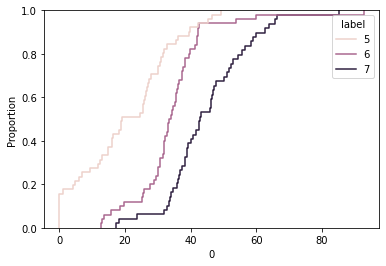

In [22]:
act_label = {"alx_no_interaction": 5, 
             "alx_ask_weather": 6,
             "alx_play_music": 7}

sns.ecdfplot(data = df_alexa, x=0, hue="label")

In [47]:
features = ["sub_duration", "pkts_rate", "bytes_rate", "np.mean(sizes)", "np.std(sizes)", "q1_size", 
            "q2_size", 'q3_size', "np.min(sizes)", 'np.max(sizes)', "np.mean(iats)", 'np.std(iats)', 
            "q1_iat", 'q2_iat'," q3_iat", "np.min(iats)", 'np.max(iats)', "out_flow_num",
            "sub_duration", "pkts_rate", "bytes_rate", "np.mean(sizes)", "np.std(sizes)", "q1_size", 
            "q2_size", 'q3_size', "np.min(sizes)", 'np.max(sizes)', "np.mean(iats)", 'np.std(iats)', 
            "q1_iat", 'q2_iat'," q3_iat", "np.min(iats)", 'np.max(iats)', "in_flow_num"]


def eval(feat_type, exp, device="*"):
    X, y = load_dataset(feat_type, device, vidInte=False)
    df = pd.dataframe(X)
    for k in range(0, len(X)):
        print(X[k][17], X[k][35], y[k], y[k])
#     print(X)
#     print(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)
#     for train_index, test_index in kf.split(X):
#         print("TRAIN:", train_index, "TEST:", test_index)
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
    for key in classifiers:
        print(key)
        classifier = classifiers[key].fit(X_train, y_train)
        print(classifier.feature_importances_)

        predicted_labels = classifier.predict(X_test)
        cf_matrix = confusion_matrix(y_test, predicted_labels)
        size = len(act_label.keys())
        make_confusion_matrix(cf_matrix, feat_type, key, exp,
#                               figsize=(size*1.2, size*1.2),
                              categories=act_label.keys(), 
                              cmap='Blues')
#         disp = plot_confusion_matrix(classifier, X_test, y_test,
#                                      cmap=plt.cm.Blues)
#         plt.show()
    return df

In [11]:
def load_dataset(feat_type, device="*", vidInte=False):
    X = []
    y = []
    if feat_type == 'keypoint':
        for activity in act_label.keys():
            dir = f'{feature_path}{activity}/keypoint/'
            print(glob.glob(dir + '*.dat'))
            for ft_files in glob.glob(dir + '*.dat'):
                X_, y_ = load_data(ft_files)
                X.append(X_)
                y.append(y_)
#         print(X)
#         print(y)
        return X, y
        
    else:
#         for activity in act_label.keys():
        dir = feature_path + device + '/*/*/pcap-netml/' + feat_type + '/'
        print(len(glob.glob(dir + '*.dat')))
        for ft_files in glob.glob(dir + '*.dat'):
            X_, y_ = load_data(ft_files)
#             print(ft_files)
#             print(X_, y_)
            X_ = X_.reshape(1, 36)
            y_ = y_[0]
            if not vidInte:
                X.append(X_)
            else:
                vid_dir = f'{feature_path}{activity}/keypoint/'
                index = ft_files.split('/')[-1].split('.dat')[0].split('_')[-1]
#                 print(index)
                vid_X, vid_y = load_data(vid_dir + 'fridge-keypoint_' + str(index) + '.dat')
                x_li = []
                for x in X_:
                    x = np.concatenate((x, vid_X))
                    x_li.append(x)
                X_ = np.array(x_li)
                X.append(X_)
            y.append(y_)
        
#     print(X)
#     print(y)
    return np.concatenate(X, axis=0), y

STATS
269
5.0 5.0 0 0
3.0 3.0 0 0
1.0 0.0 0 0
3.0 3.0 0 0
3.0 3.0 0 0
4.0 3.0 0 0
4.0 3.0 0 0
5.0 4.0 0 0
10.0 10.0 0 0
2.0 0.0 0 0
9.0 8.0 0 0
2.0 2.0 0 0
4.0 4.0 0 0
3.0 3.0 0 0
4.0 3.0 0 0
3.0 3.0 0 0
4.0 3.0 0 0
3.0 3.0 0 0
3.0 3.0 0 0
5.0 4.0 0 0
19.0 18.0 0 0
7.0 6.0 0 0
7.0 6.0 0 0
21.0 20.0 0 0
13.0 11.0 0 0
6.0 5.0 0 0
5.0 4.0 0 0
11.0 10.0 0 0
11.0 10.0 0 0
11.0 11.0 0 0
55.0 54.0 0 0
123.0 122.0 0 0
30.0 28.0 0 0
57.0 55.0 0 0
134.0 134.0 0 0
23.0 23.0 0 0
55.0 53.0 0 0
48.0 46.0 0 0
33.0 33.0 0 0
69.0 67.0 0 0
11.0 10.0 4 4
20.0 19.0 4 4
16.0 15.0 4 4
18.0 17.0 4 4
15.0 14.0 4 4
21.0 20.0 4 4
18.0 17.0 4 4
13.0 11.0 4 4
15.0 14.0 4 4
19.0 18.0 4 4
11.0 10.0 4 4
11.0 10.0 4 4
26.0 25.0 4 4
18.0 17.0 4 4
20.0 19.0 4 4
12.0 11.0 4 4
19.0 19.0 4 4
15.0 15.0 4 4
20.0 19.0 4 4
14.0 13.0 4 4
16.0 15.0 4 4
18.0 17.0 4 4
19.0 17.0 4 4
17.0 16.0 4 4
11.0 10.0 4 4
0.0 0.0 1 1
19.0 18.0 4 4
0.0 0.0 1 1
15.0 14.0 4 4
19.0 18.0 4 4
13.0 12.0 4 4
11.0 10.0 4 4
19.0 18.0 4 4
27.0 26.0 4 4


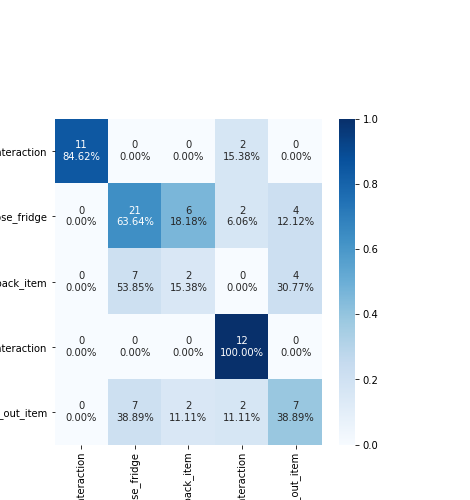

In [16]:
# Only fridge
feat_types = ["STATS"]
# feat_types = ['IAT','SIZE','IAT_SIZE','SAMP_NUM','SAMP_SIZE','STATS',
#                   'FFT-IAT','FFT-IAT_SIZE','FFT-SIZE','FFT-SAMP_NUM', 'FFT-SAMP_SIZE']
from warnings import filterwarnings
filterwarnings('ignore')

act_label = {"frg_no_interaction": 0, 
             "frg_open_close_fridge": 1, 
             "frg_put_back_item": 2,
             "frg_screen_interaction": 3,
             "frg_take_out_item": 4}

for feat in feat_types:
    print(feat)
    eval(feat, "fridge_out+in_", "refrigerator")
    
# [sub_duration, pkts_rate, bytes_rate, np.mean(sizes), np.std(sizes), q1_size, 
# q2_size, q3_size, np.min(sizes), np.max(sizes), np.mean(iats), np.std(iats), 
# q1_iat, q2_iat, q3_iat, np.min(iats), np.max(iats), len(out_flow_map)]

# [sub_duration, pkts_rate, bytes_rate, np.mean(sizes), np.std(sizes), q1_size, 
# q2_size, q3_size, np.min(sizes), np.max(sizes), np.mean(iats), np.std(iats), 
# q1_iat, q2_iat, q3_iat, np.min(iats), np.max(iats), len(in_flow_map)]

STATS
150
3.0 2.0 5 5
8.0 7.0 5 5
3.0 1.0 5 5
2.0 2.0 5 5
0.0 1.0 5 5
3.0 1.0 5 5
3.0 2.0 5 5
4.0 2.0 5 5
4.0 2.0 5 5
2.0 1.0 5 5
3.0 2.0 5 5
3.0 2.0 5 5
0.0 1.0 5 5
9.0 8.0 5 5
0.0 1.0 5 5
4.0 2.0 5 5
8.0 7.0 5 5
4.0 3.0 5 5
0.0 1.0 5 5
9.0 8.0 5 5
3.0 3.0 5 5
3.0 1.0 5 5
1.0 1.0 5 5
5.0 5.0 5 5
2.0 2.0 5 5
21.0 20.0 5 5
3.0 3.0 5 5
4.0 2.0 5 5
0.0 1.0 5 5
7.0 4.0 5 5
11.0 8.0 5 5
3.0 2.0 5 5
3.0 3.0 5 5
3.0 2.0 5 5
12.0 9.0 5 5
5.0 2.0 5 5
1.0 3.0 5 5
2.0 2.0 5 5
0.0 1.0 5 5
8.0 5.0 5 5
3.0 2.0 5 5
3.0 1.0 5 5
3.0 2.0 5 5
9.0 8.0 5 5
5.0 3.0 5 5
0.0 1.0 5 5
8.0 7.0 5 5
2.0 2.0 5 5
0.0 1.0 5 5
4.0 2.0 5 5
5.0 2.0 5 5
30.0 28.0 7 7
20.0 18.0 7 7
26.0 25.0 7 7
20.0 19.0 7 7
24.0 22.0 7 7
21.0 20.0 7 7
22.0 20.0 7 7
20.0 18.0 7 7
19.0 18.0 7 7
25.0 23.0 7 7
23.0 21.0 7 7
19.0 19.0 7 7
23.0 22.0 7 7
22.0 21.0 7 7
21.0 22.0 7 7
19.0 19.0 7 7
21.0 22.0 7 7
27.0 26.0 7 7
21.0 21.0 7 7
26.0 25.0 7 7
26.0 24.0 7 7
27.0 24.0 7 7
25.0 24.0 7 7
27.0 25.0 7 7
31.0 29.0 7 7
25.0 25.0 7 7
26.0 24.0 

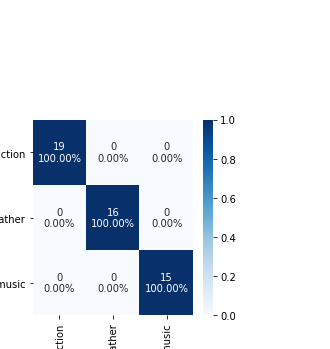

In [17]:
act_label = {"alx_no_interaction": 5, 
             "alx_ask_weather": 6,
             "alx_play_music": 7}
for feat in feat_types:
    print(feat)
    eval(feat, "alexa_out+in_", "alexa")
    
# [sub_duration, pkts_rate, bytes_rate, np.mean(sizes), np.std(sizes), q1_size, 
# q2_size, q3_size, np.min(sizes), np.max(sizes), np.mean(iats), np.std(iats), 
# q1_iat, q2_iat, q3_iat, np.min(iats), np.max(iats), len(out_flow_map)]

STATS
150
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
2.0 2.0 8 8
2.0 2.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
4.0 4.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
2.0 2.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
2.0 2.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 8 8
1.0 1.0 10 10
1.0 1.0 10 10
1.0 1.0 10 10
1.0 2.0 10 10
4.0 4.0 10 10
1.0 1.0 10 10
1.0 1.0 10 10
1.0 1.0 10 10
1.0 1.0 10 10
1.0 1.0 10 10
1.0 1.0 10 10
1.0 1.0 10 10
1.0 1.0 10 10
1.0 1.0 10 10
1.0 1.0 10 10
1.0 1.0 10 10
1.0 1.0 10 10
1.0 1.0 10 10
1.0 1.0 10 10
1.0 1.0 10 10
1.0 1.0 10 10
1.0 1.0 10 10
1.0 1.0 10 10
1.0 1.0 10 10
2.0 2.0 10 10
1.0 1.0 10 10
1.0 1.0 10 10
1.0 1.0 10 1

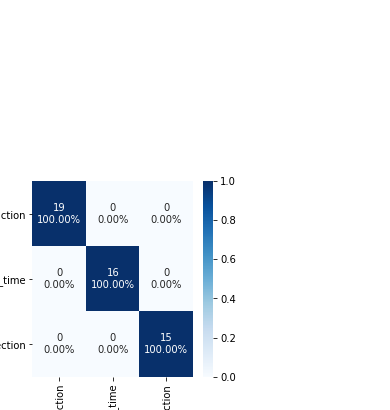

In [19]:
act_label = {"nstc_no_interaction": 8, 
             "nstc_ask_time": 9, 
             "nstc_trigger_motion_detection": 10}
for feat in feat_types:
    print(feat)
    eval(feat, "nestcam_out+in_", "nestcam")

# [sub_duration, pkts_rate, bytes_rate, np.mean(sizes), np.std(sizes), q1_size, 
# q2_size, q3_size, np.min(sizes), np.max(sizes), np.mean(iats), np.std(iats), 
# q1_iat, q2_iat, q3_iat, np.min(iats), np.max(iats), len(out_flow_map)]

STATS
569
3.0 2.0 5 5
8.0 7.0 5 5
3.0 1.0 5 5
2.0 2.0 5 5
0.0 1.0 5 5
3.0 1.0 5 5
3.0 2.0 5 5
4.0 2.0 5 5
4.0 2.0 5 5
2.0 1.0 5 5
3.0 2.0 5 5
3.0 2.0 5 5
0.0 1.0 5 5
9.0 8.0 5 5
0.0 1.0 5 5
4.0 2.0 5 5
8.0 7.0 5 5
4.0 3.0 5 5
0.0 1.0 5 5
9.0 8.0 5 5
3.0 3.0 5 5
3.0 1.0 5 5
1.0 1.0 5 5
5.0 5.0 5 5
2.0 2.0 5 5
21.0 20.0 5 5
3.0 3.0 5 5
4.0 2.0 5 5
0.0 1.0 5 5
7.0 4.0 5 5
11.0 8.0 5 5
3.0 2.0 5 5
3.0 3.0 5 5
3.0 2.0 5 5
12.0 9.0 5 5
5.0 2.0 5 5
1.0 3.0 5 5
2.0 2.0 5 5
0.0 1.0 5 5
8.0 5.0 5 5
3.0 2.0 5 5
3.0 1.0 5 5
3.0 2.0 5 5
9.0 8.0 5 5
5.0 3.0 5 5
0.0 1.0 5 5
8.0 7.0 5 5
2.0 2.0 5 5
0.0 1.0 5 5
4.0 2.0 5 5
5.0 2.0 5 5
30.0 28.0 7 7
20.0 18.0 7 7
26.0 25.0 7 7
20.0 19.0 7 7
24.0 22.0 7 7
21.0 20.0 7 7
22.0 20.0 7 7
20.0 18.0 7 7
19.0 18.0 7 7
25.0 23.0 7 7
23.0 21.0 7 7
19.0 19.0 7 7
23.0 22.0 7 7
22.0 21.0 7 7
21.0 22.0 7 7
19.0 19.0 7 7
21.0 22.0 7 7
27.0 26.0 7 7
21.0 21.0 7 7
26.0 25.0 7 7
26.0 24.0 7 7
27.0 24.0 7 7
25.0 24.0 7 7
27.0 25.0 7 7
31.0 29.0 7 7
25.0 25.0 7 7
26.0 24.0 

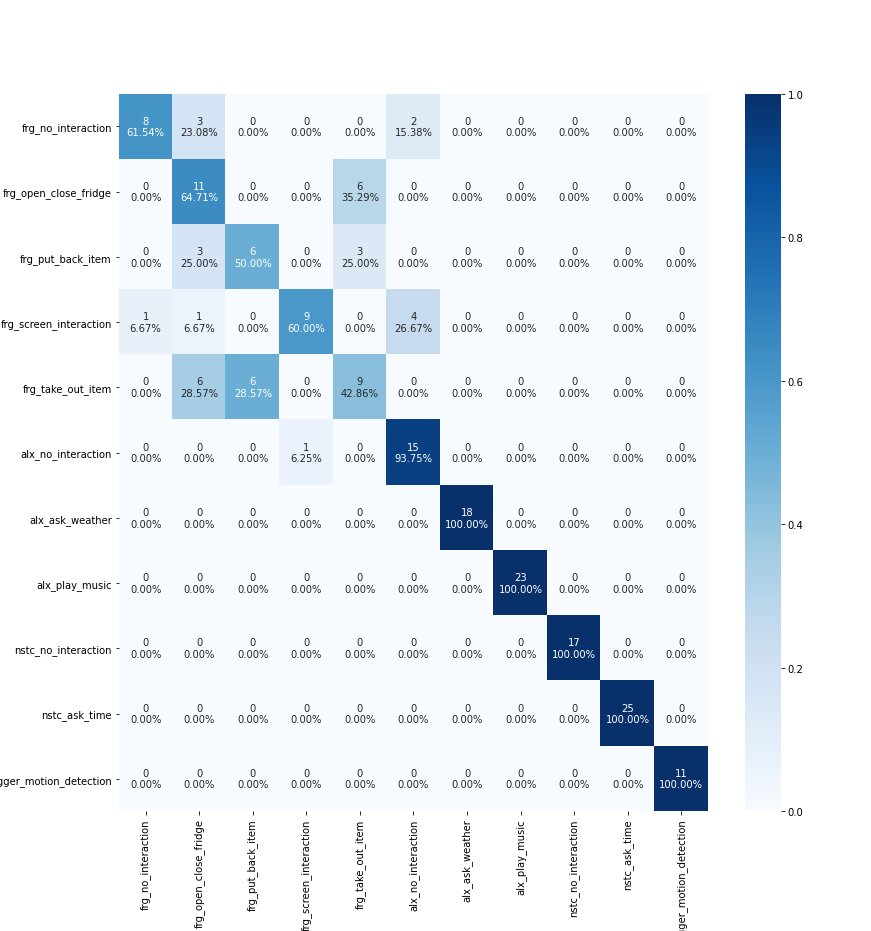

In [20]:
act_label = {"frg_no_interaction": 0, 
             "frg_open_close_fridge": 1, 
             "frg_put_back_item": 2,
             "frg_screen_interaction": 3,
             "frg_take_out_item": 4,
             "alx_no_interaction": 5, 
             "alx_ask_weather": 6,
             "alx_play_music": 7,
             "nstc_no_interaction": 8, 
             "nstc_ask_time": 9, 
             "nstc_trigger_motion_detection": 10}
feat_types = ['STATS']
# feat_types = ['IAT','SIZE','IAT_SIZE','SAMP_NUM','SAMP_SIZE','STATS',
#                   'FFT-IAT','FFT-IAT_SIZE','FFT-SIZE','FFT-SAMP_NUM', 'FFT-SAMP_SIZE']
from warnings import filterwarnings
filterwarnings('ignore')

for feat in feat_types:
    print(feat)
    eval(feat, 'all_out+in_',"*")

# Video (mp4) + network

In [54]:
rng = 42

In [5]:
vid_feature_path_mp4 = "../../video-feature-clean/output_mp4/"
vid_feature_path_mkv = "../../video-feature-clean/output_mkv/"

In [6]:
X = []
f = []
y = []
for file in glob.glob("../../video-feature-clean/output_mp4/*.npy"):
    X.append(np.load(file))
    f.append(file)
    y.append(label)
    print(file)
    print(np.load(file).shape)

../../video-feature-clean/output_mp4/play_music_5_1615492342_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/no_interaction_6_1615415456_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/ask_weather_5_1615408447_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/ask_weather_10_1615409364_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/no_interaction_2_1615415292_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/ask_weather_9_1616184433_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/screen_interaction_9_1614038560_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/no_interaction_4_1616185931_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/no_interaction_5_1615411718_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/open_close_fridge_14_1615393552_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/play_music_16_1615411101_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/ask_time_5_1616187862_1_vgg.npy
(4096,)
../../video-featu

(4096,)
../../video-feature-clean/output_mp4/take_out_item_6_1615394179_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/trigger_motion_detection_5_1615493844_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/ask_weather_9_1615409309_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/no_interaction_9_1615411933_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/no_interaction_9_1615493447_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/ask_weather_2_1615491327_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/take_out_item_10_1615394383_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/open_close_fridge_9_1614111650_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/ask_weather_7_1615491704_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/play_music_9_1616185511_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/take_out_item_4_1615394074_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/play_music_8_1614040535_1_vgg.npy
(4096,)
..

(4096,)
../../video-feature-clean/output_mp4/no_interaction_3_1616185820_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/play_music_8_1615410627_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/open_close_fridge_3_1613680739_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/ask_time_5_1615414166_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/play_music_6_1615410496_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/trigger_motion_detection_3_1615493719_1_vgg.npy
(4096,)
../../video-feature-clean/output_mp4/ask_time_1_1614904536_1_vgg.npy
(4096,)


In [65]:
from sklearn.model_selection import KFold

def eval(feat_type, exp, device="*", vid=False, vidType="mp4", concat=True):
    print(exp)
    X, y = load_dataset(feat_type, device, vidInte=vid, vidType=vidType, concat=concat)
    df = pd.DataFrame(X)
#     for k in range(0, len(X)):
#         print(X[k][17], X[k][35], y[k], y[k])
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)
#     print(X, y)
    kf = KFold(3, True, rng)
    for key in classifiers:
        print(key)
        for train_index, test_index in kf.split(X, y):
#             print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            classifier = classifiers[key].fit(X_train, y_train)
    #         print(classifier.feature_importances_)

            predicted_labels = classifier.predict(X_test)
            cf_matrix = confusion_matrix(y_test, predicted_labels)
            size = len(act_label.keys())
            make_confusion_matrix(cf_matrix, feat_type, key, exp,
                                  figsize=(size*1.5, size*1.5),
                                  categories=act_label.keys(), 
                                  cmap='Blues')
    #         disp = plot_confusion_matrix(classifier, X_test, y_test,
    #                                      cmap=plt.cm.Blues)
            plt.show()
    return df

In [7]:
np.set_printoptions(threshold=np.inf)

In [60]:
def load_dataset(feat_type, device="*", vidInte=False, vidType='mp4', concat=True):
    X = []
    y = []
    print(device)
    if feat_type == 'keypoint':
        for activity in act_label.keys():
            dir = f'{feature_path}{activity}/keypoint/'
            print(glob.glob(dir + '*.dat'))
            for ft_files in glob.glob(dir + '*.dat'):
                X_, y_ = load_data(ft_files)
                X.append(X_)
                y.append(y_)
#         print(X)
#         print(y)
        return X, y
        
    else:
#         for activity in act_label.keys():
        dir = feature_path + device + '/*/*/pcap-netml/' + feat_type + '/'
        print(len(glob.glob(dir + '*.dat')))
        for ft_files in glob.glob(dir + '*.dat'):
#             scaler = MinMaxScaler()
            X_, y_ = load_data(ft_files)
            X_ = X_.reshape(1, 36)
#             print(X_)
#             scaler.fit(X_)
#             X_ = scaler.transform(X_)
#             print(X_)
            y_ = y_[0]
            if not vidInte:
                X.append(X_)
            else:
                index = ft_files.split('/')[-1].split('_filtered.dat')[0].split('STATS_')[1]
                if concat:
                    if vidType == "mp4":
                        vid_dir = f'{vid_feature_path_mp4}'
                        vid_X = np.load(vid_dir + str(index) + '_1_vgg.npy')
                        x_li = []
                        for x in X_:
                            x = np.concatenate((x, vid_X))
                            x_li.append(x)
                    elif vidType == "mkv":
                        vid_dir = f'{vid_feature_path_mkv}'
                        vid_X = np.load(vid_dir + str(index) + '_2_vgg.npy')
                        x_li = []
                        for x in X_:
                            x = np.concatenate((x, vid_X))
                            x_li.append(x)
                    elif vidType == "both":
                        vid_X_1 = np.load(vid_feature_path_mp4 + str(index) + '_1_vgg.npy')
                        vid_X_2 = np.load(vid_feature_path_mkv + str(index) + '_2_vgg.npy')
                        x_li = []
                        for x in X_:
                            x = np.concatenate((x, vid_X_1, vid_X_2))
                            x_li.append(x)
                else:
                    if vidType == "mp4":
                        vid_dir = f'{vid_feature_path_mp4}'
                        vid_X = np.load(vid_dir + str(index) + '_1_vgg.npy')
                        x_li = []
                        for x in X_:
                            x = vid_X
                            x_li.append(x)
                    elif vidType == "mkv":
                        vid_dir = f'{vid_feature_path_mkv}'
                        vid_X = np.load(vid_dir + str(index) + '_2_vgg.npy')
                        x_li = []
                        for x in X_:
                            x = vid_X
                            x_li.append(x)
                    elif vidType == "both":
                        vid_X_1 = np.load(vid_feature_path_mp4 + str(index) + '_1_vgg.npy')
                        vid_X_2 = np.load(vid_feature_path_mkv + str(index) + '_2_vgg.npy')
                        x_li = []
                        for x in X_:
                            x = np.concatenate((vid_X_1, vid_X_2))
                            x_li.append(x)                    
                X_ = np.array(x_li)
                X.append(X_)
            y.append(y_)
        
#     print(X)
#     print(y)
        scaler = MinMaxScaler()
        X = np.concatenate(X, axis=0)
        scaler.fit(X)
        X = scaler.transform(X)
#         print(X)
    return np.array(X), np.array(y)

## refridgerator

STATS
mp4+netml
refrigerator
269
OvRLogReg


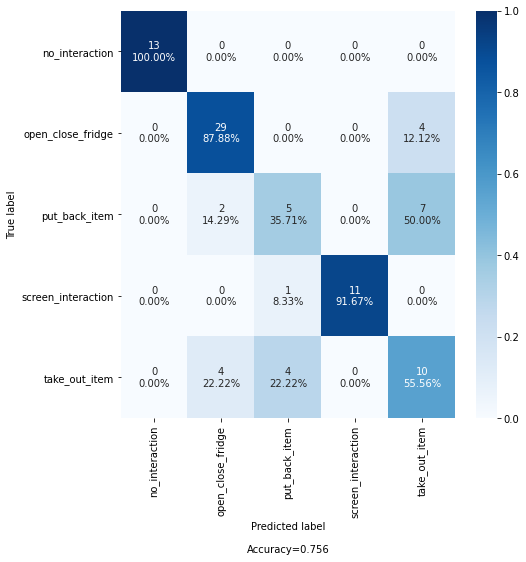

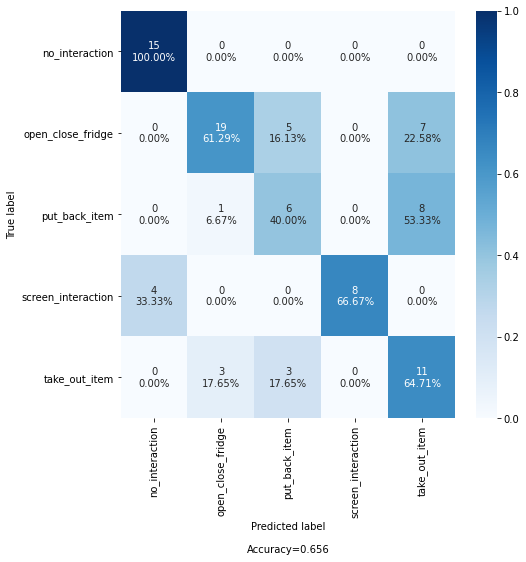

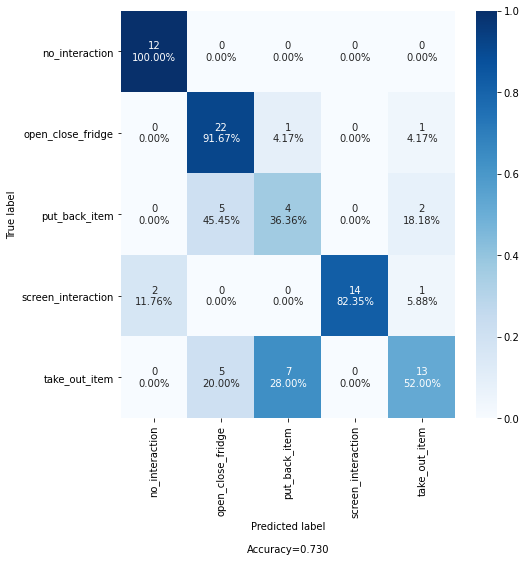

DecTree


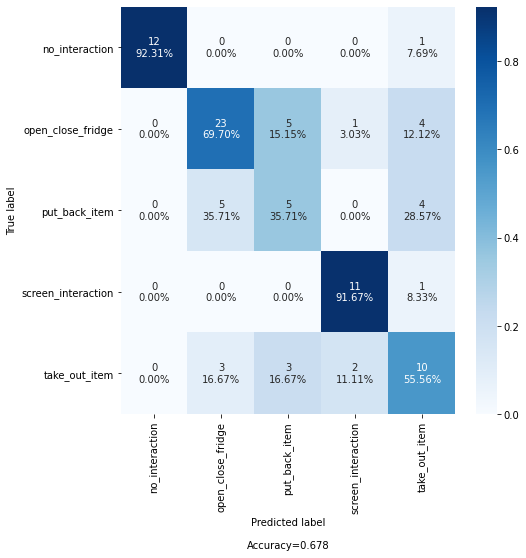

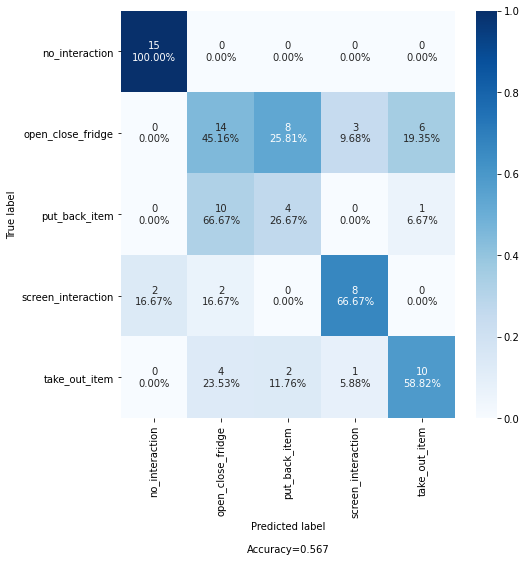

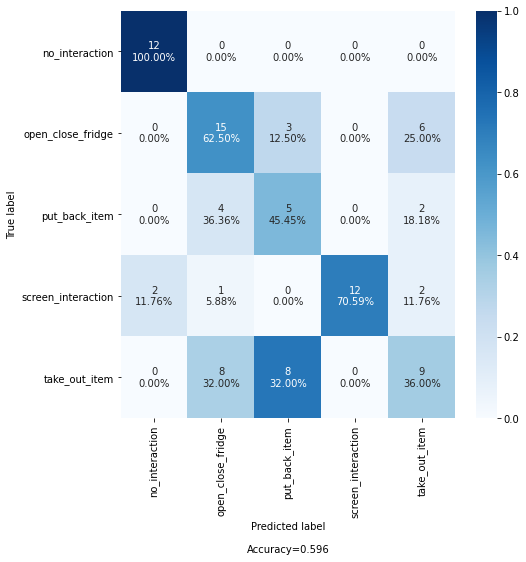

LogReg


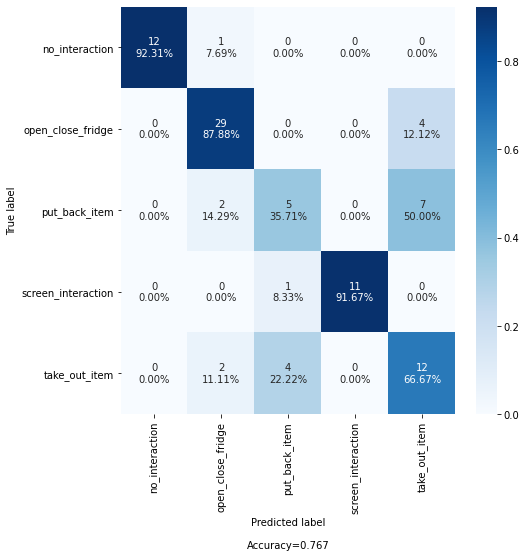

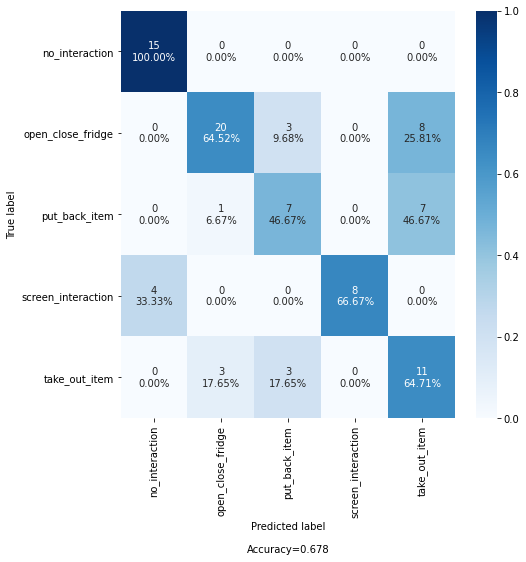

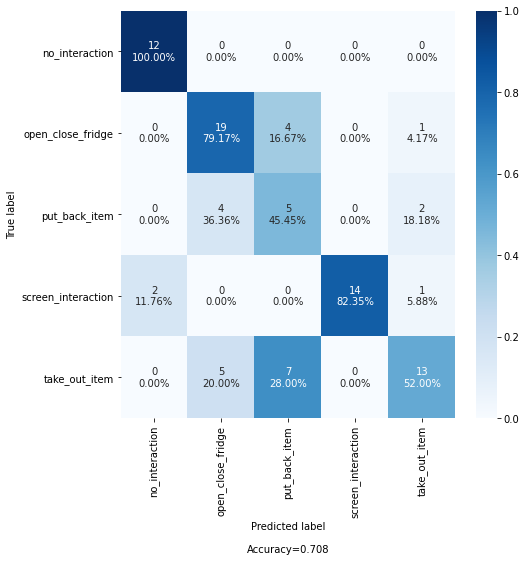

OvOSVC


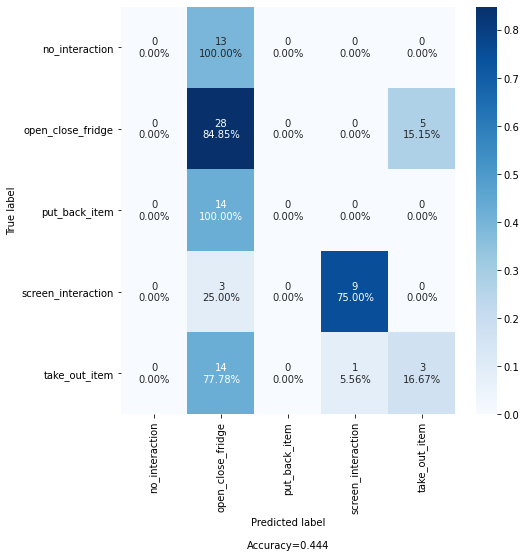

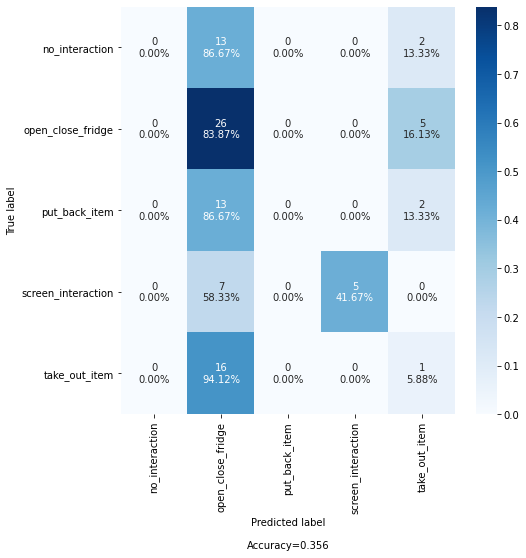

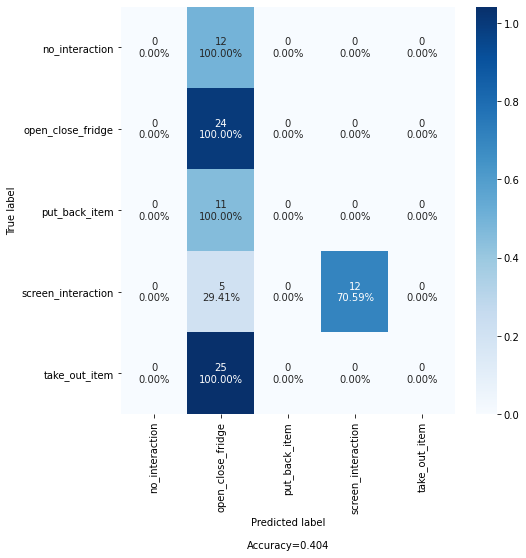

OvOGP


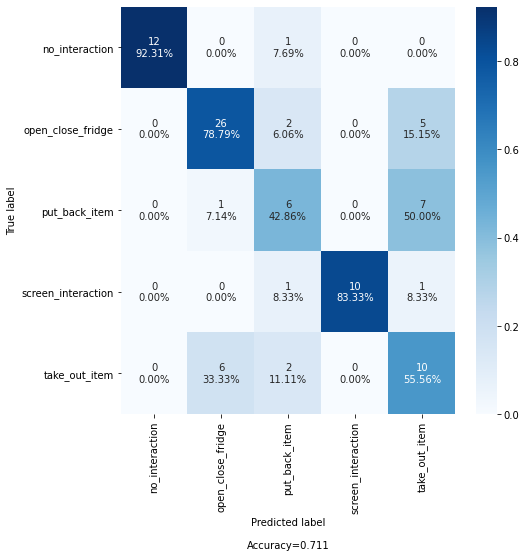

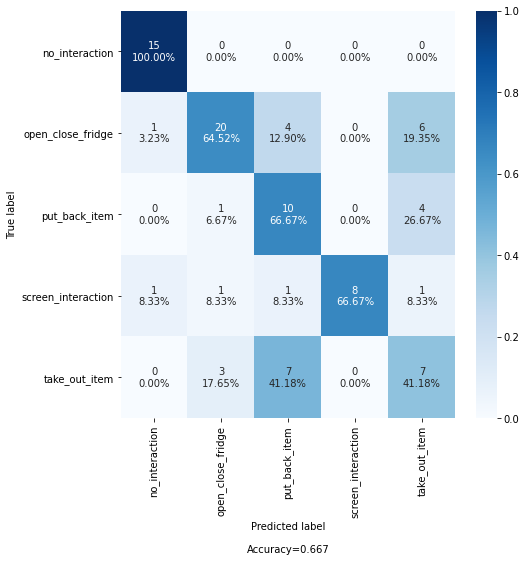

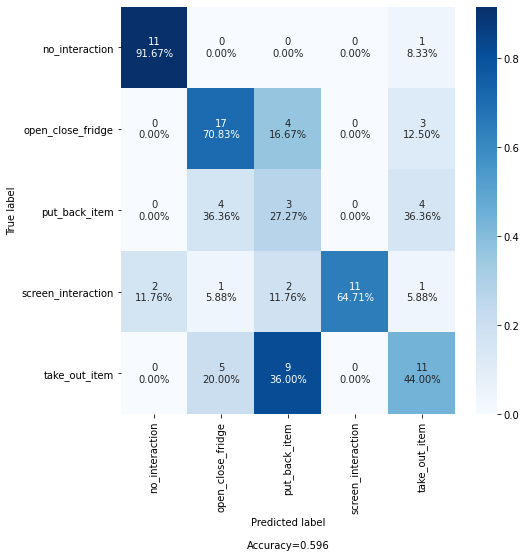

OvRLinearSVC


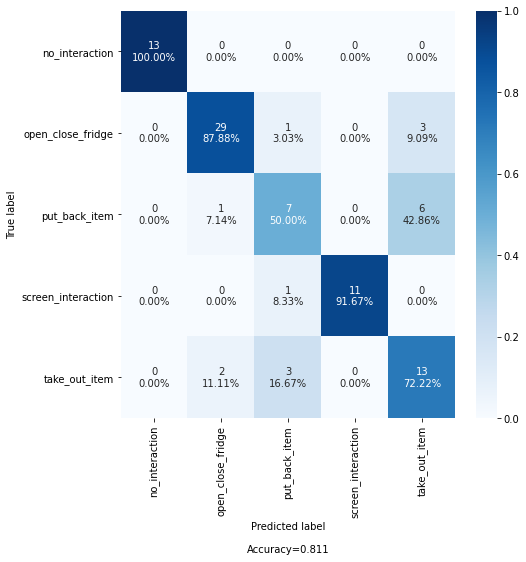

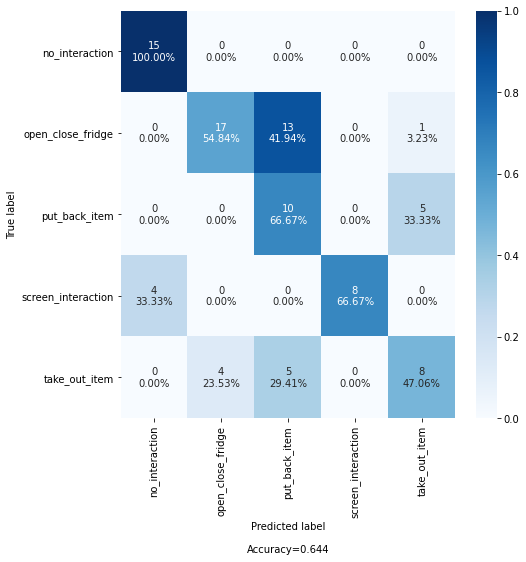

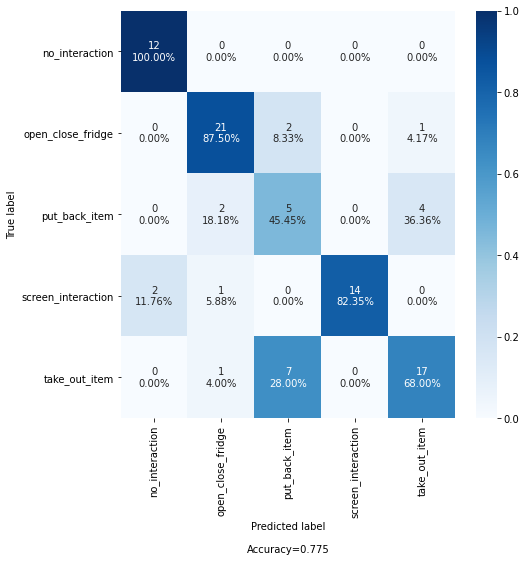

OvRGP


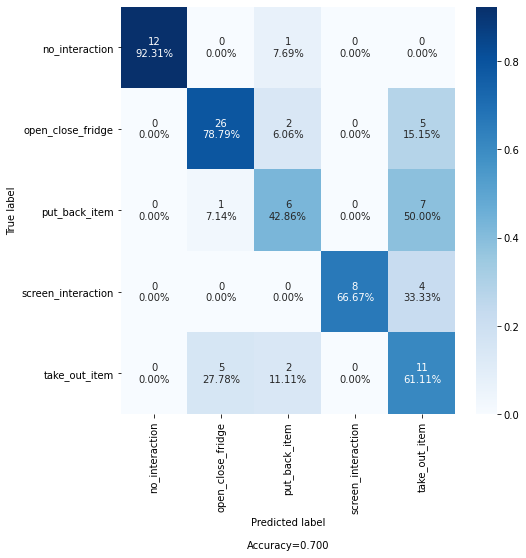

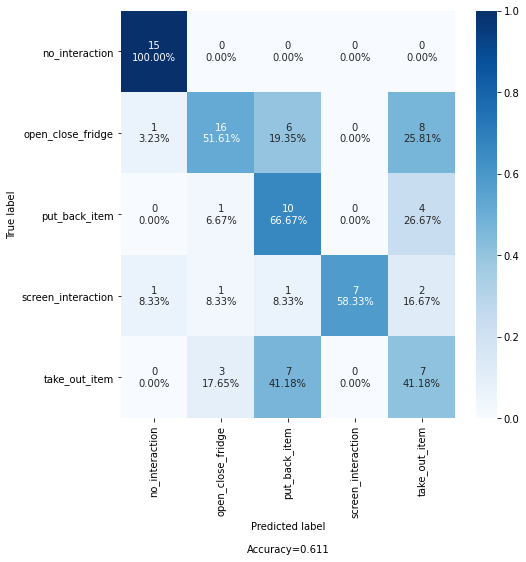

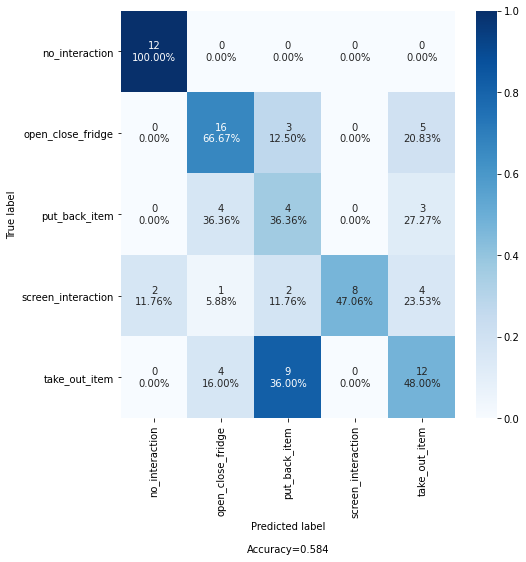

In [66]:
act_label = {"no_interaction": 0, 
             "open_close_fridge": 1, 
             "put_back_item": 2,
             "screen_interaction": 3,
             "take_out_item": 4}

classifiers = {"OvRLogReg": OneVsRestClassifier(LogisticRegression(random_state=rng)),
               "DecTree": DecisionTreeClassifier(random_state=rng),
               "LogReg": LogisticRegression(random_state=rng),
               "OvOSVC": OneVsOneClassifier(SVC(random_state=rng)), 
# #                OneVsOneClassifier(NuSVC(random_state=42)),
               "OvOGP": OneVsOneClassifier(GaussianProcessClassifier(random_state=rng)),
               "OvRLinearSVC": OneVsRestClassifier(LinearSVC(random_state=rng)), 
               "OvRGP":OneVsRestClassifier(GaussianProcessClassifier(random_state=rng)),
              }

# act_label = {"frg_no_interaction": 0, 
#              "frg_open_close_fridge": 1, 
#              "frg_put_back_item": 2,
#              "frg_screen_interaction": 3,
#              "frg_take_out_item": 4,
#              "alx_no_interaction": 5, 
#              "alx_ask_weather": 6,
#              "alx_play_music": 7,
#              "nstc_no_interaction": 8, 
#              "nstc_ask_time": 9, 
#              "nstc_trigger_motion_detection": 10}
feat_types = ['STATS']
# feat_types = ['IAT','SIZE','IAT_SIZE','SAMP_NUM','SAMP_SIZE','STATS',
#                   'FFT-IAT','FFT-IAT_SIZE','FFT-SIZE','FFT-SAMP_NUM', 'FFT-SAMP_SIZE']
from warnings import filterwarnings
filterwarnings('ignore')

for feat in feat_types:
    print(feat)
    eval(feat, 'mp4+netml',"refrigerator", True, "mp4")

STATS
mkv+netml
refrigerator
269
OvRLogReg


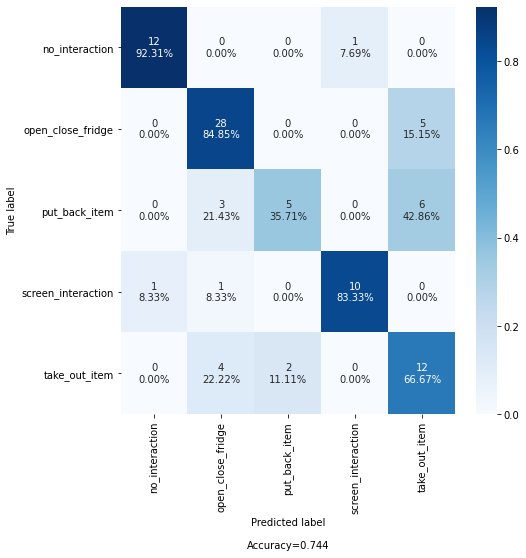

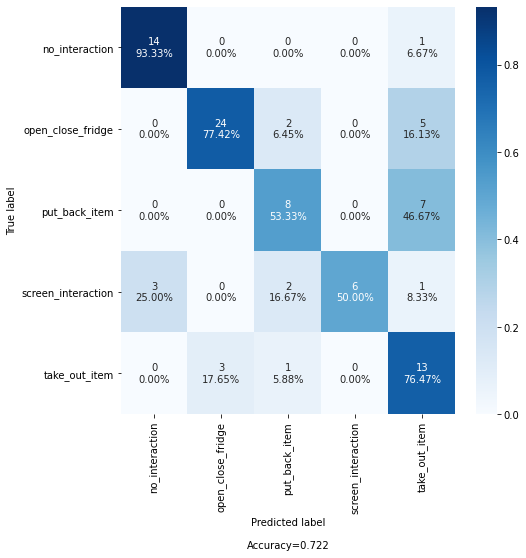

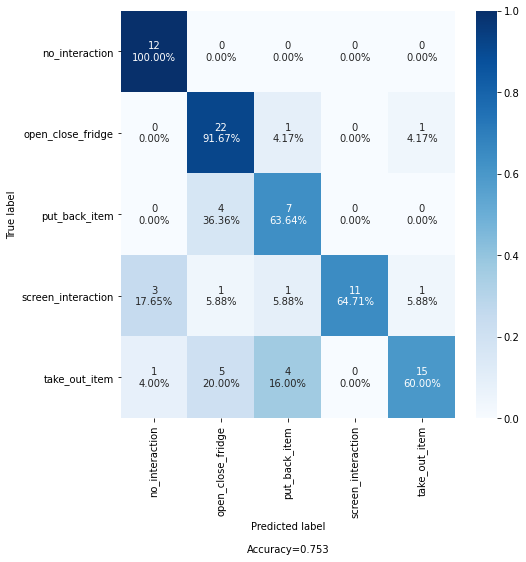

DecTree


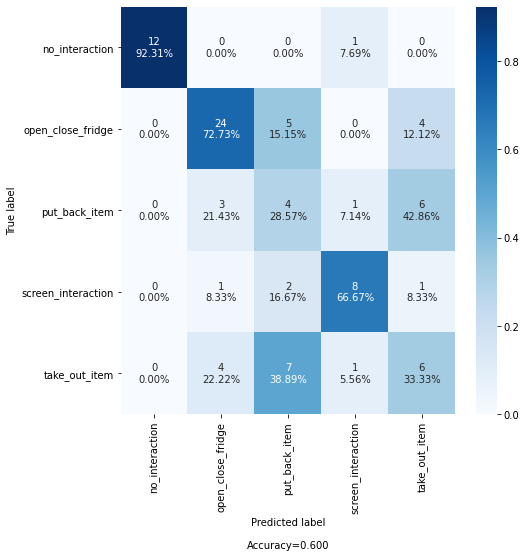

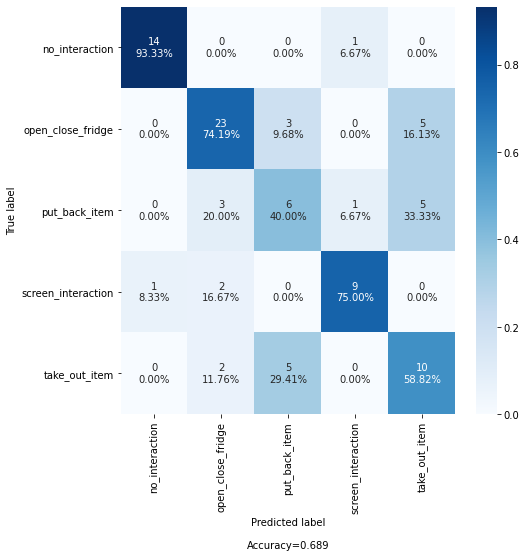

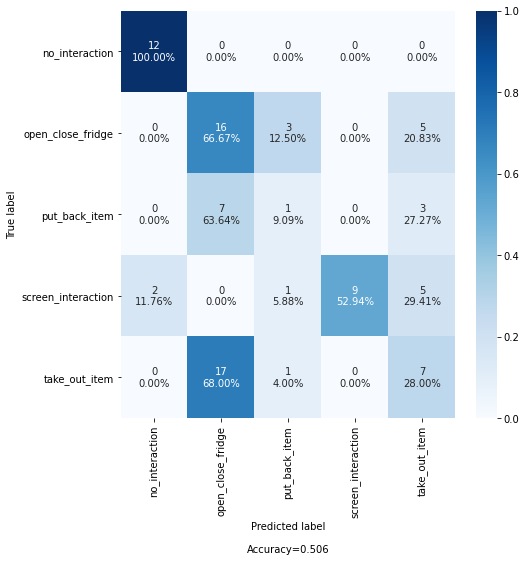

LogReg


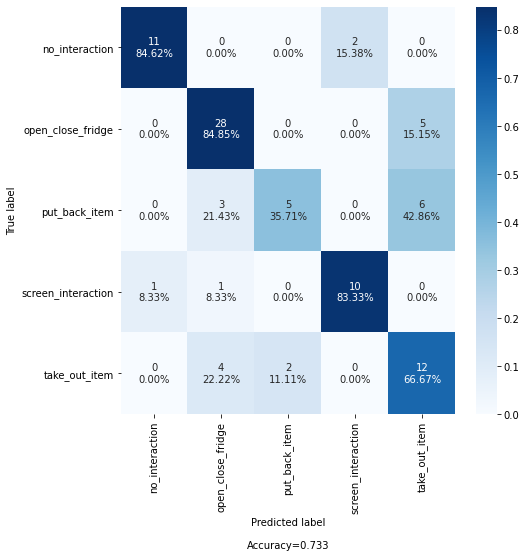

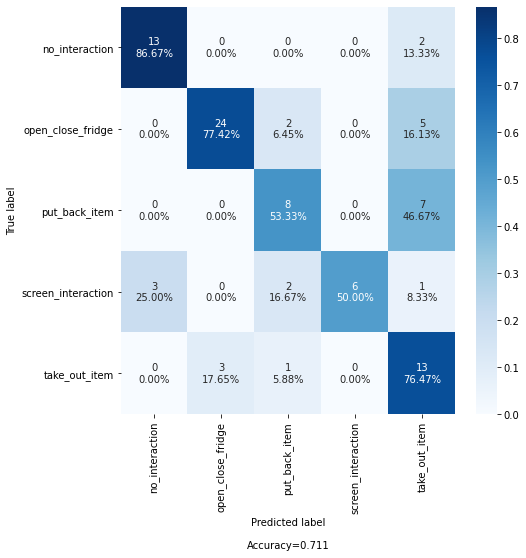

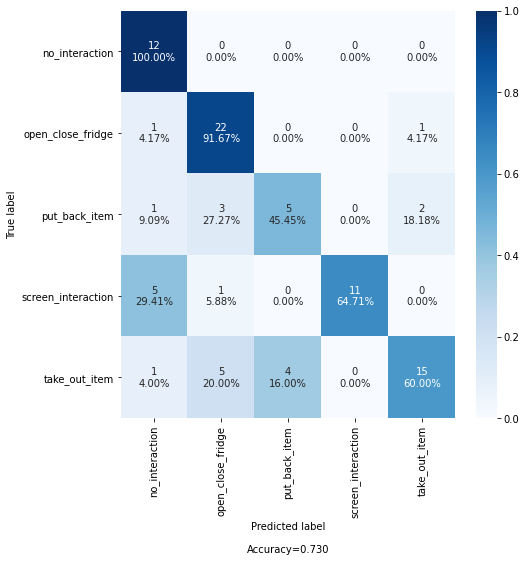

OvOSVC


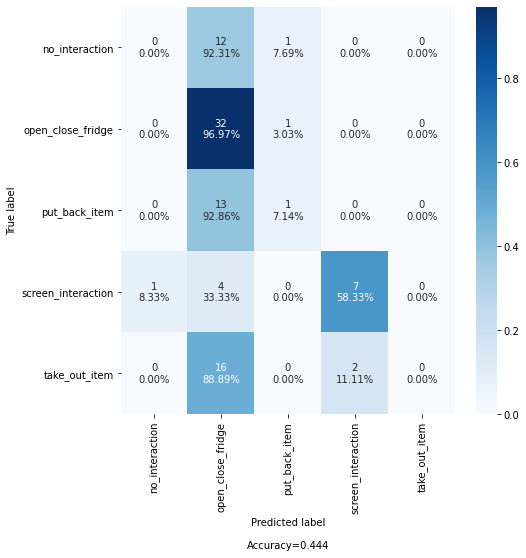

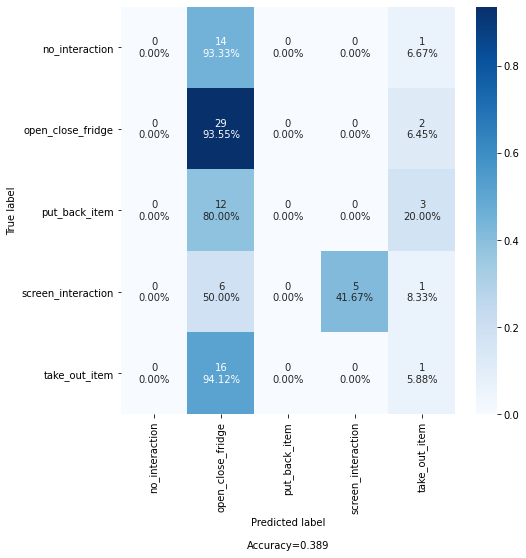

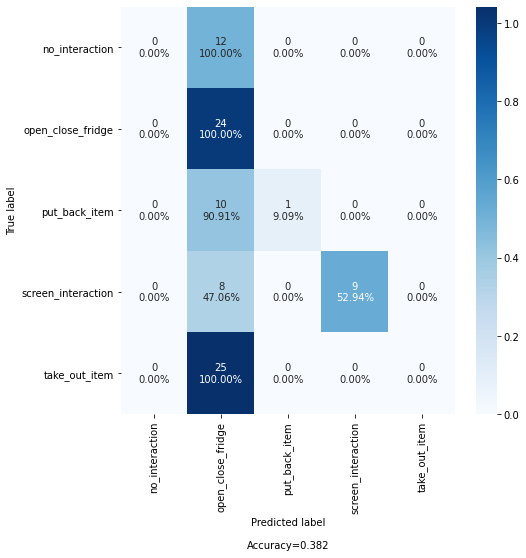

OvOGP


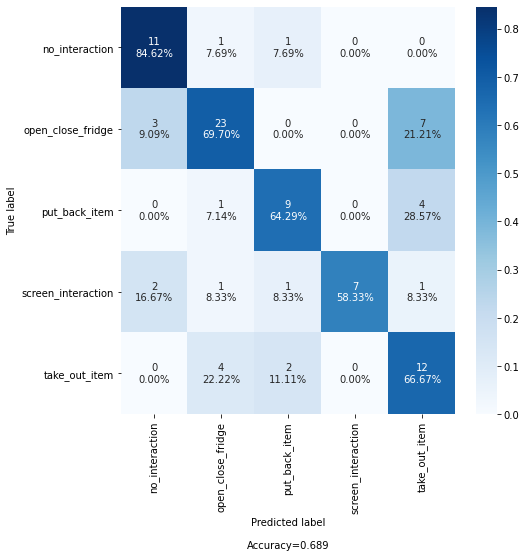

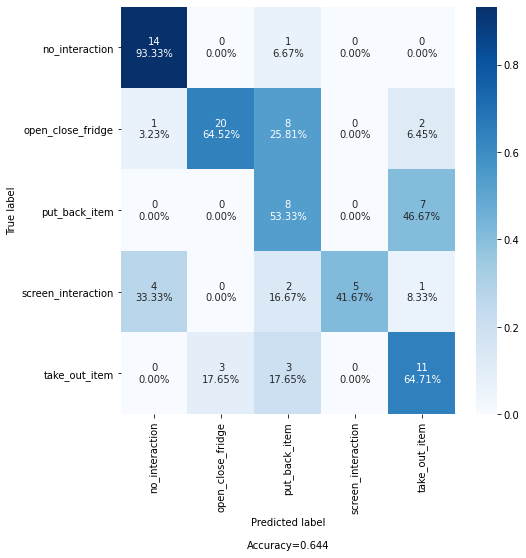

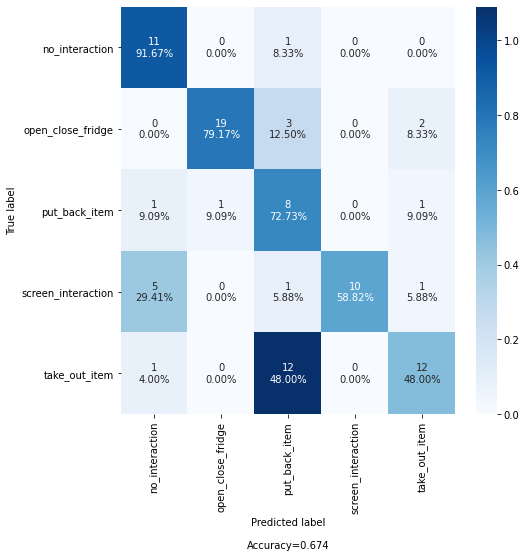

OvRLinearSVC


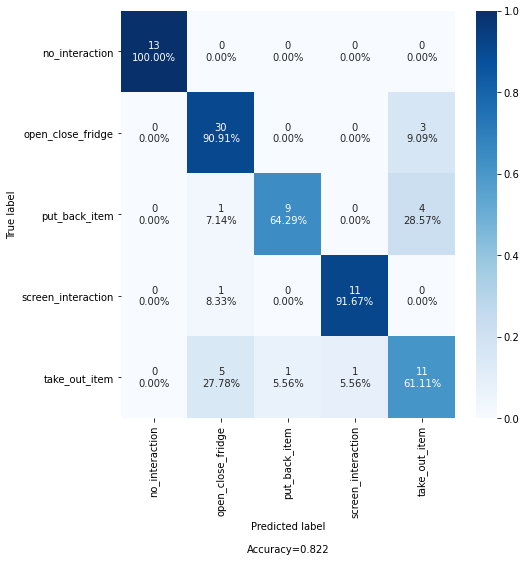

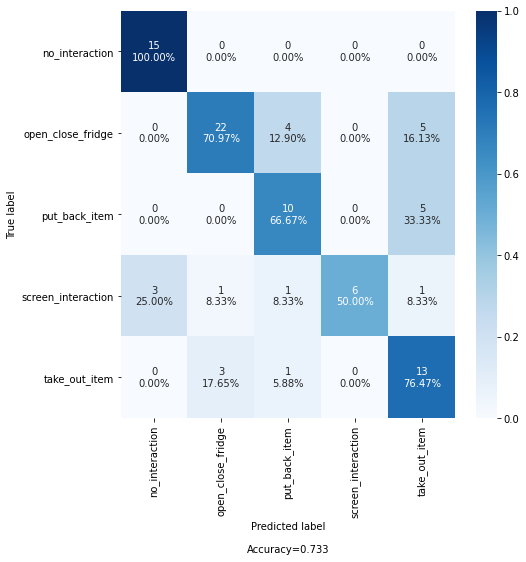

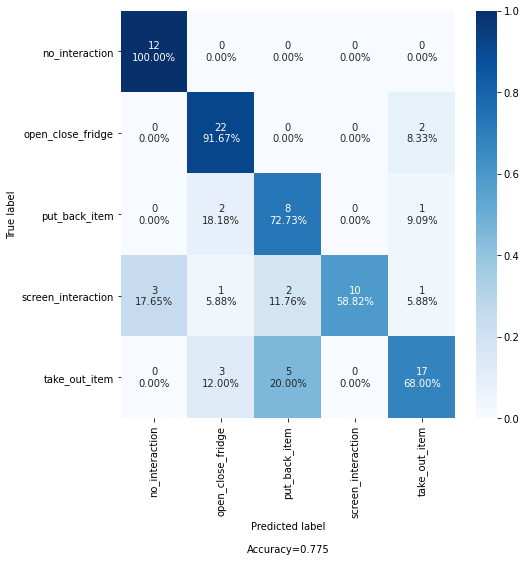

OvRGP


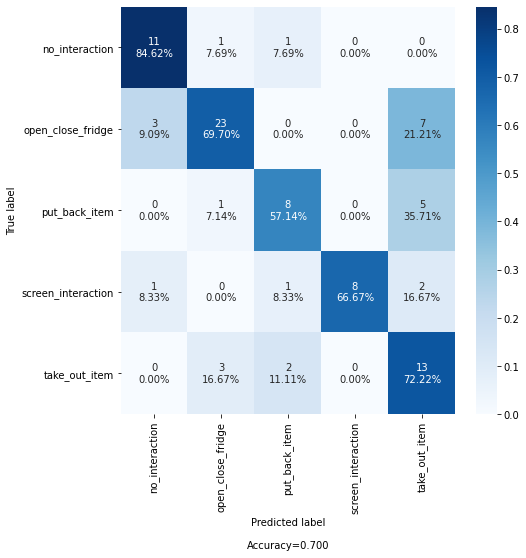

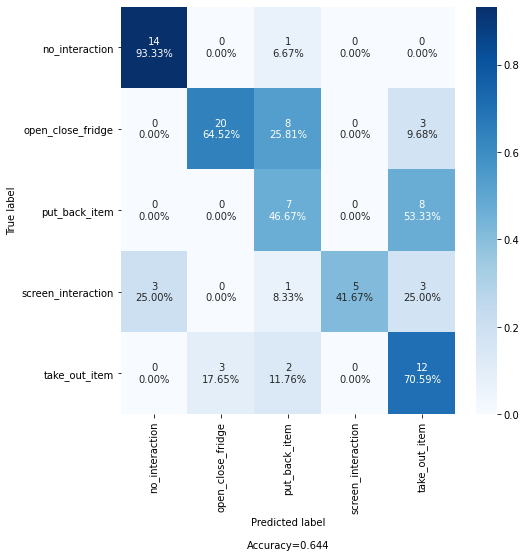

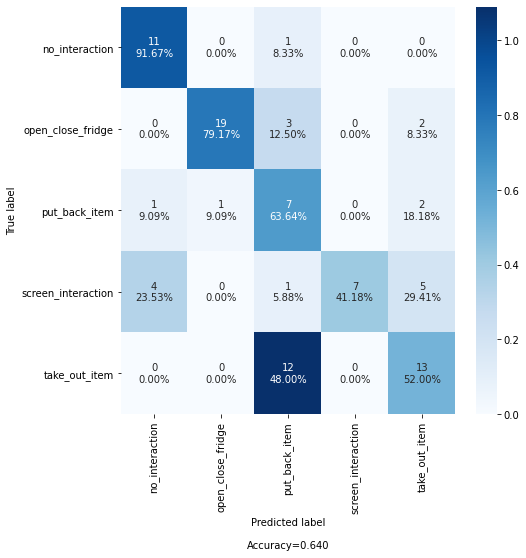

In [67]:
for feat in feat_types:
    print(feat)
    eval(feat, 'mkv+netml', "refrigerator", True, "mkv")

STATS
both+netml
refrigerator
269
OvRLogReg


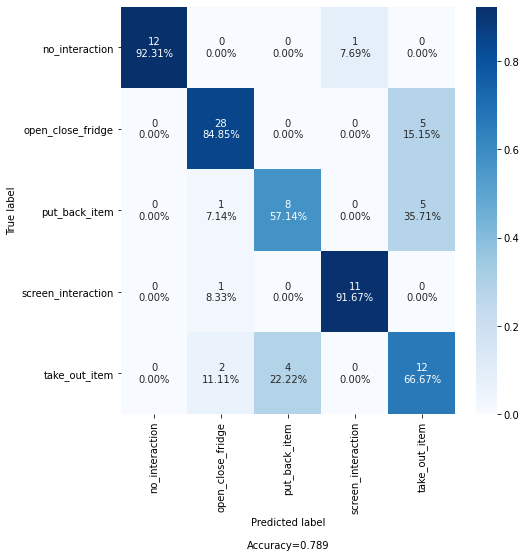

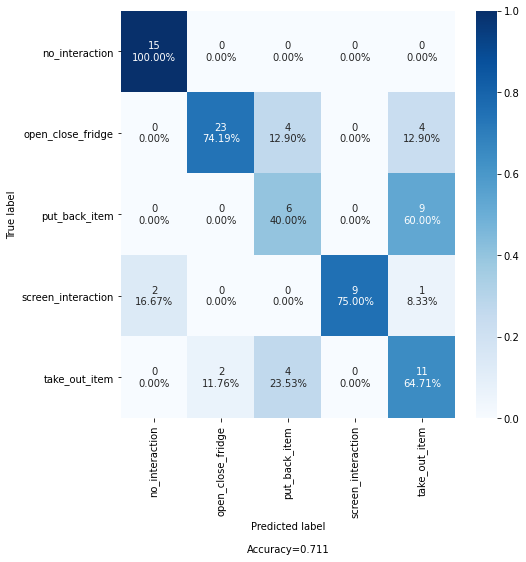

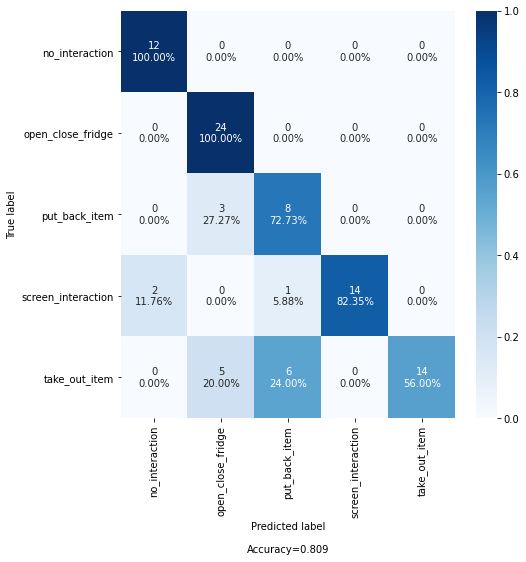

DecTree


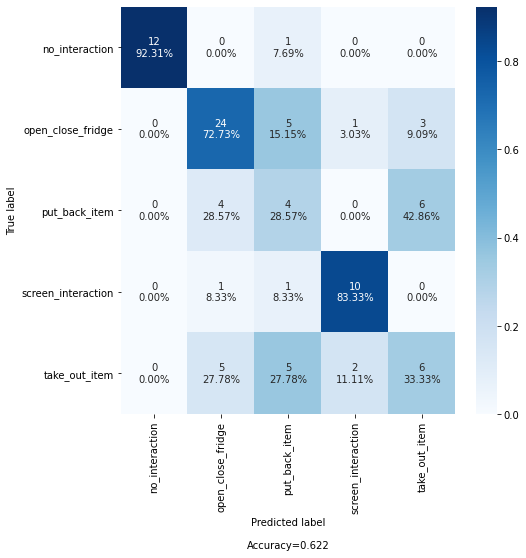

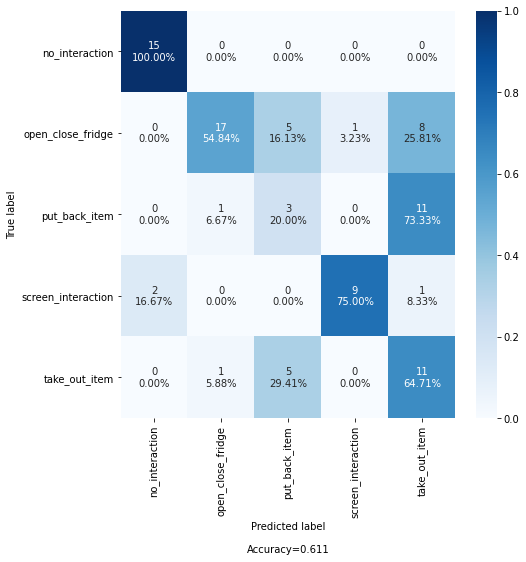

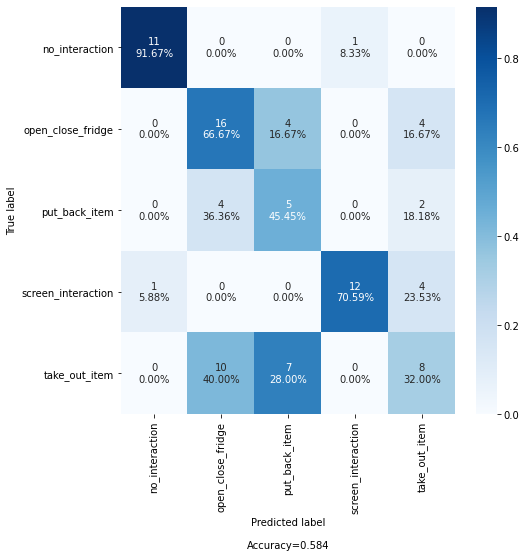

LogReg


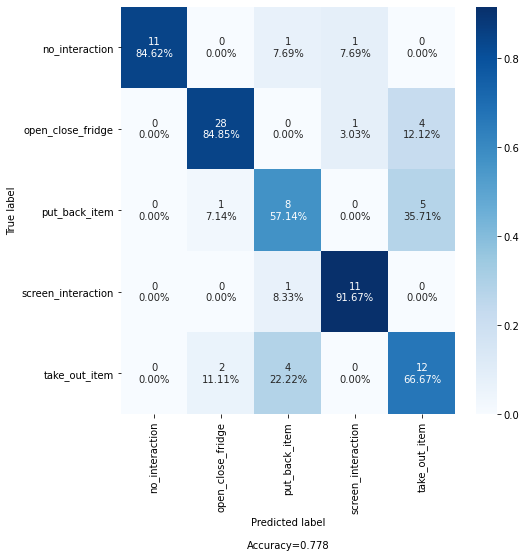

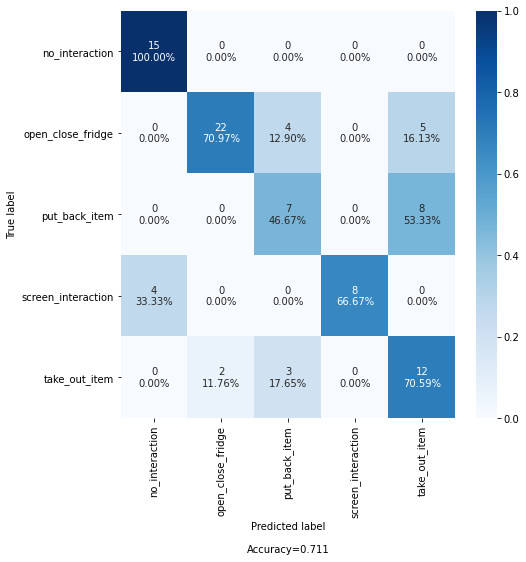

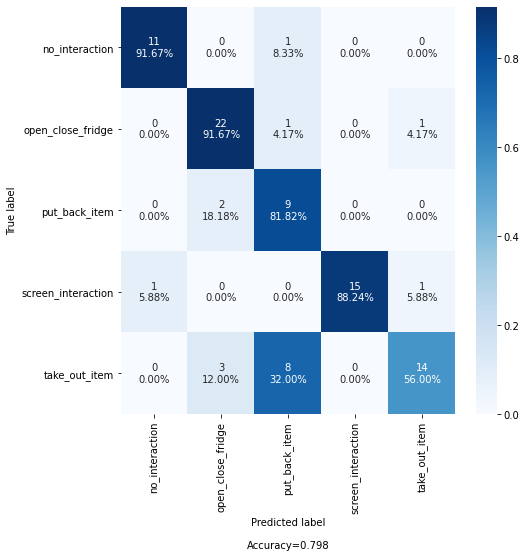

OvOSVC


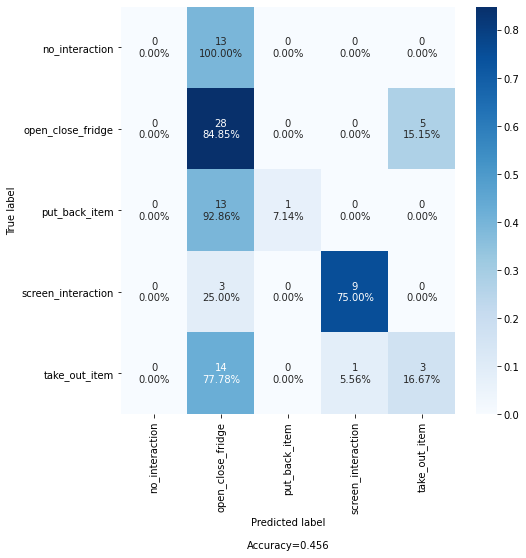

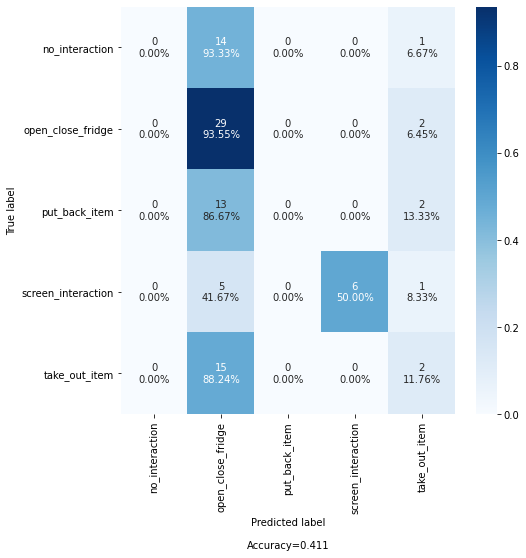

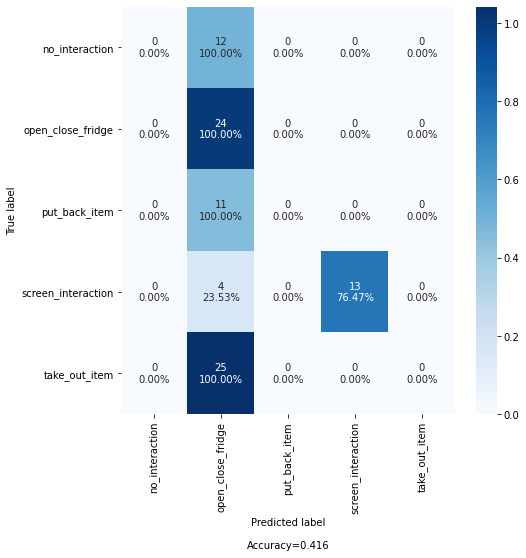

OvOGP


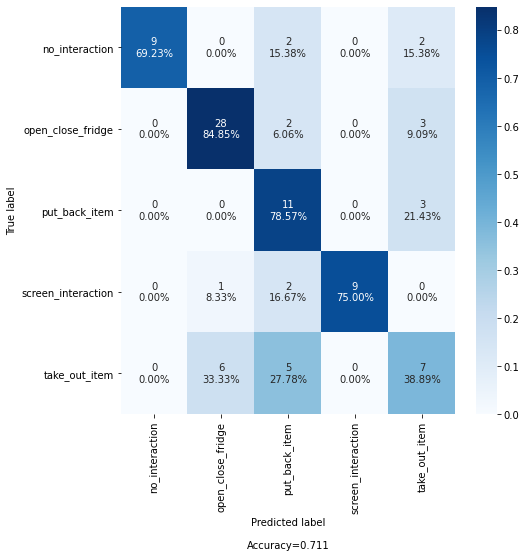

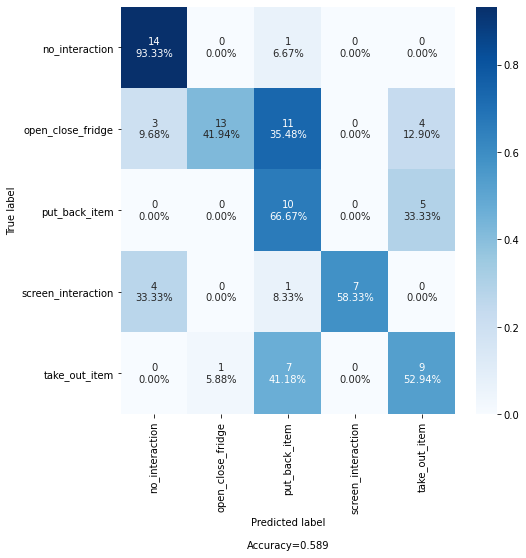

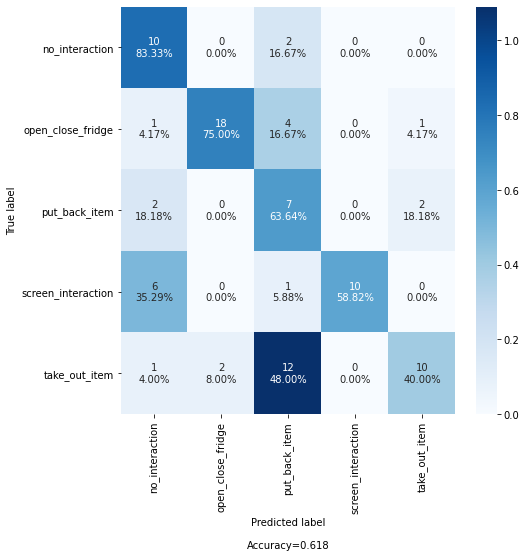

OvRLinearSVC


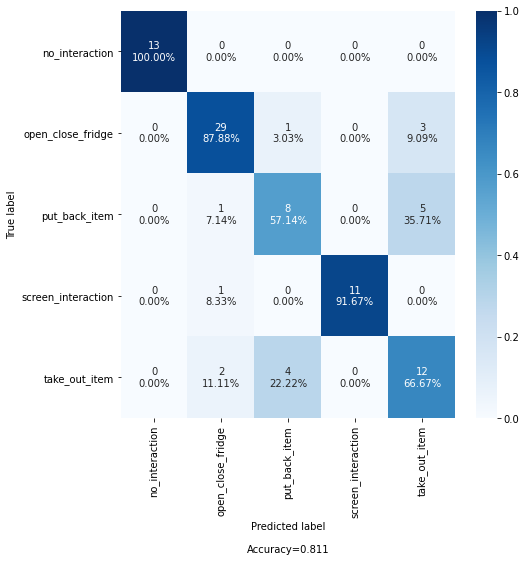

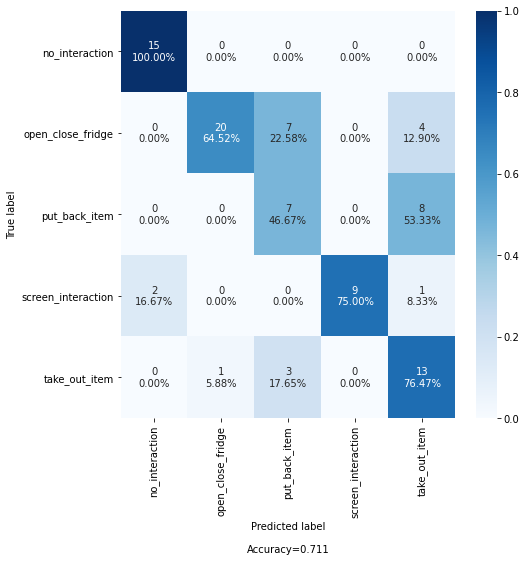

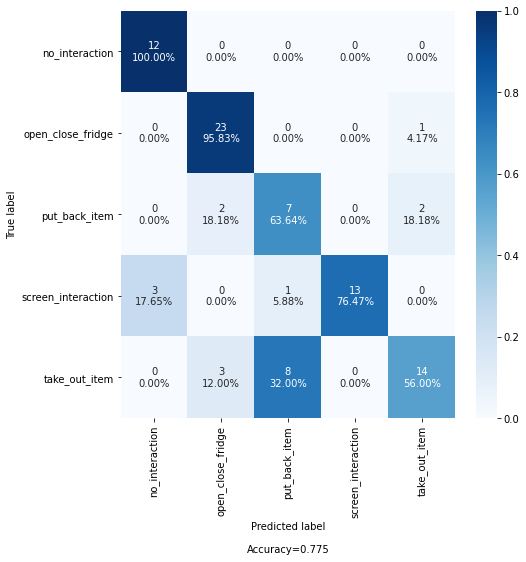

OvRGP


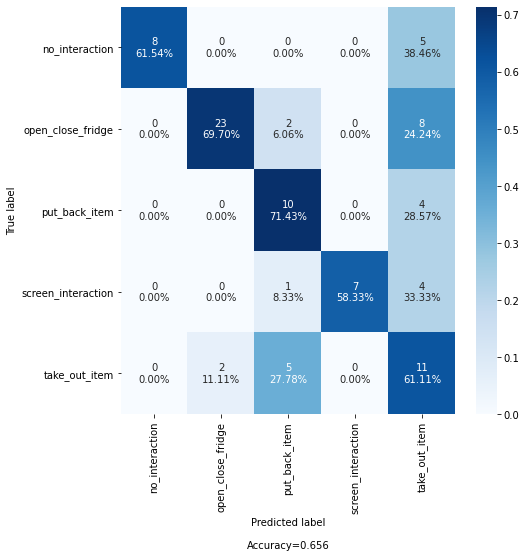

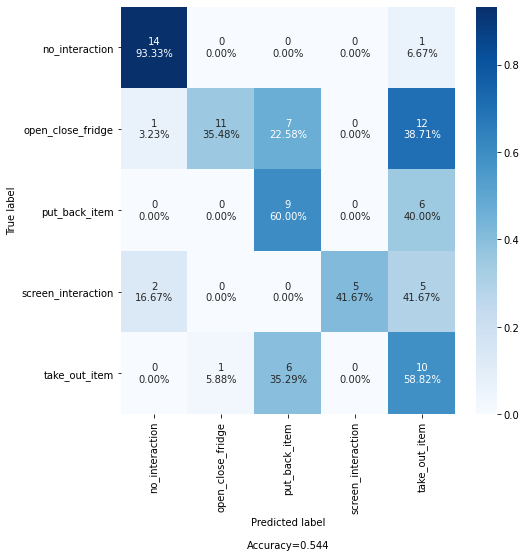

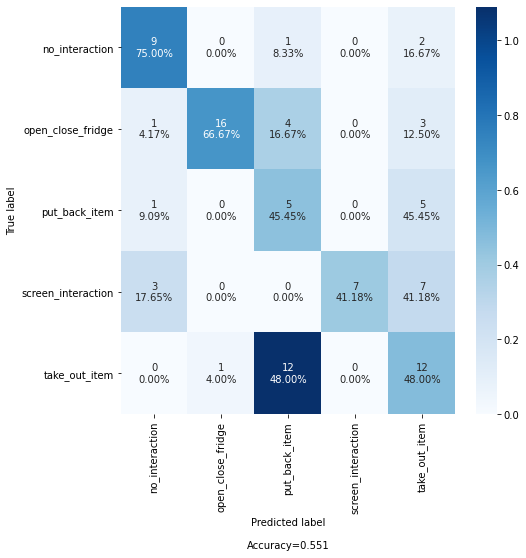

In [69]:
for feat in feat_types:
    print(feat)
    eval(feat, 'both+netml', "refrigerator", True, "both")

STATS
netml
refrigerator
269
OvRLogReg


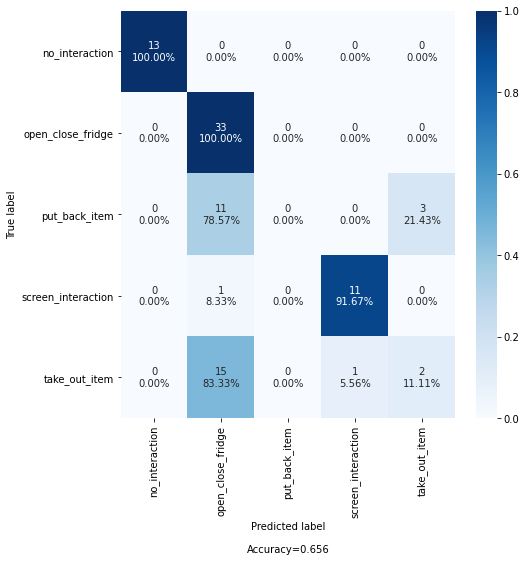

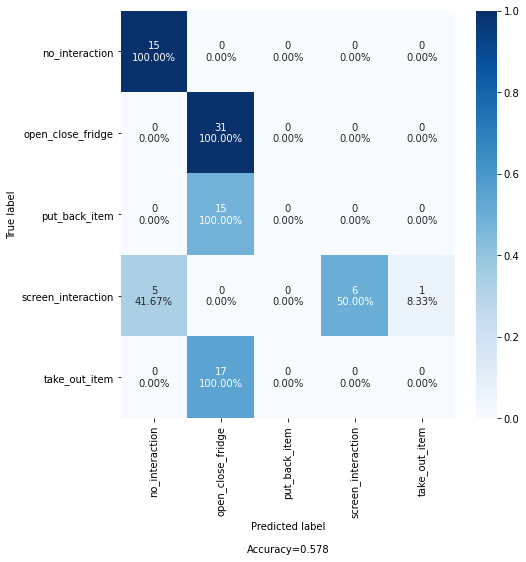

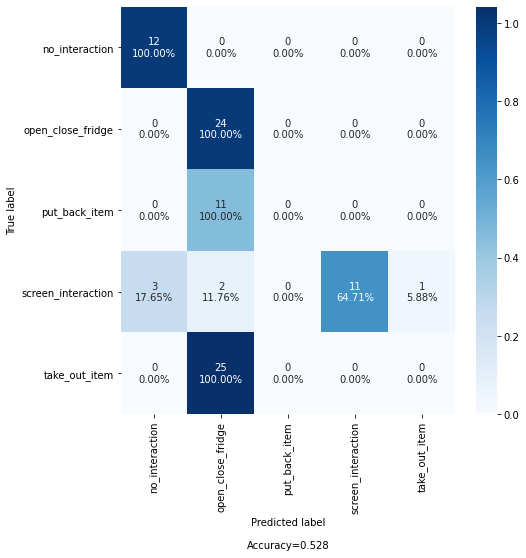

DecTree


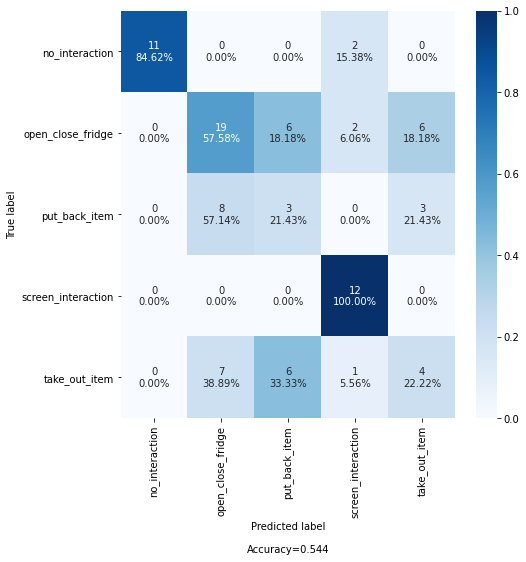

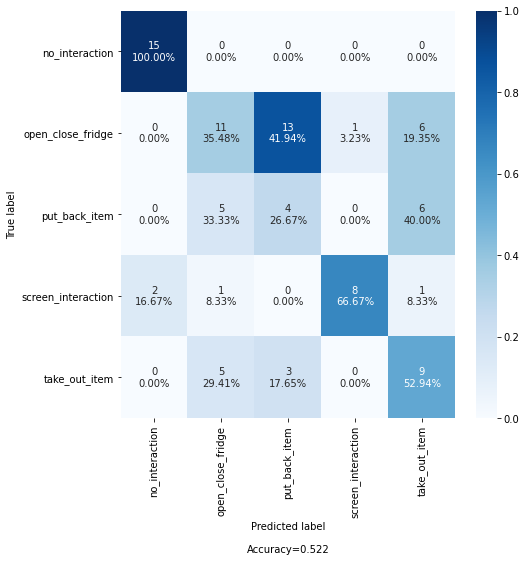

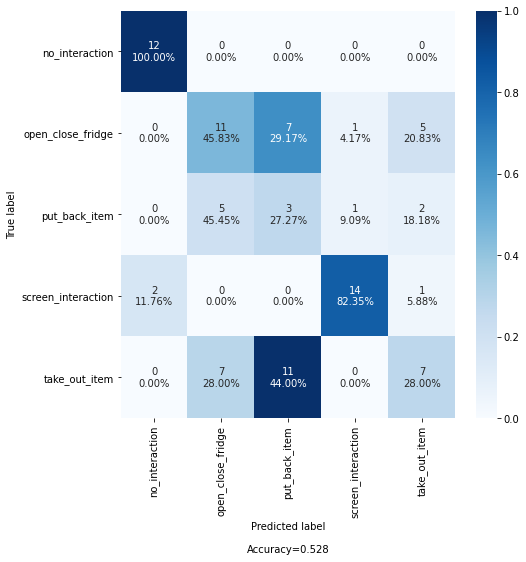

LogReg


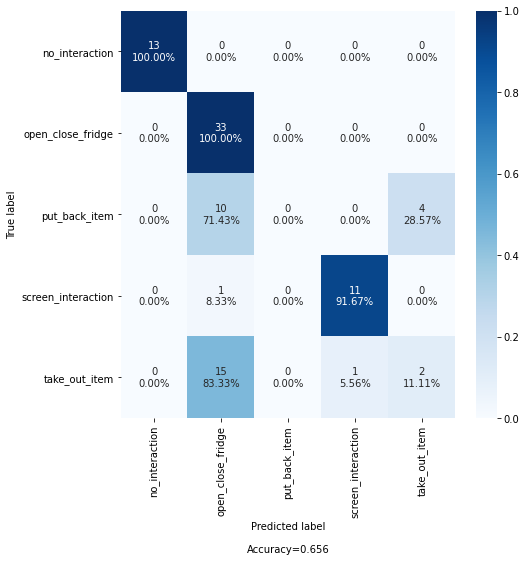

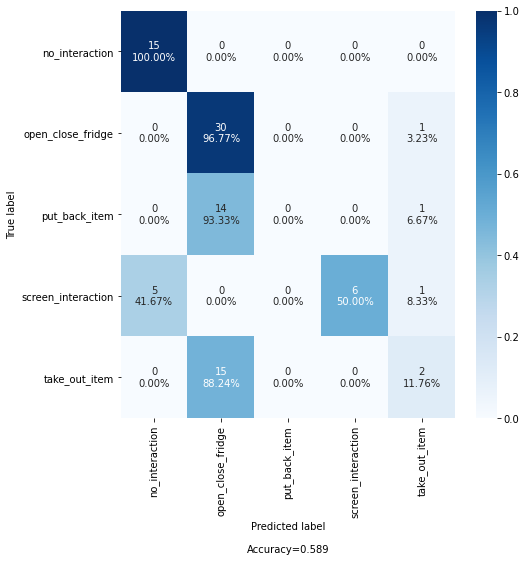

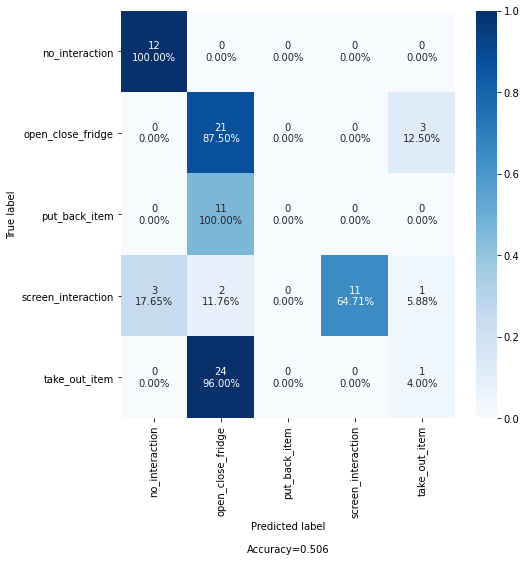

OvOSVC


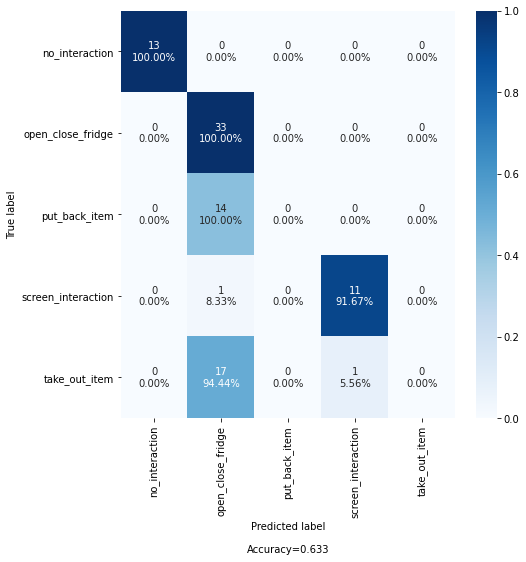

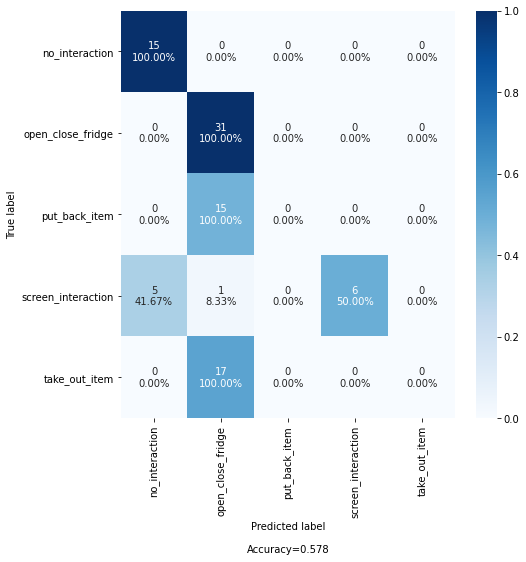

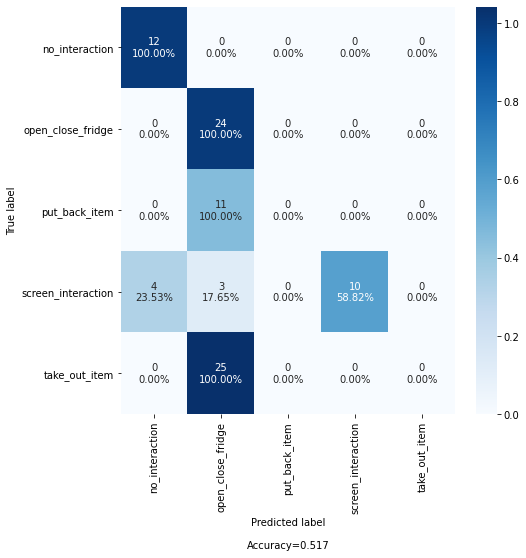

OvOGP


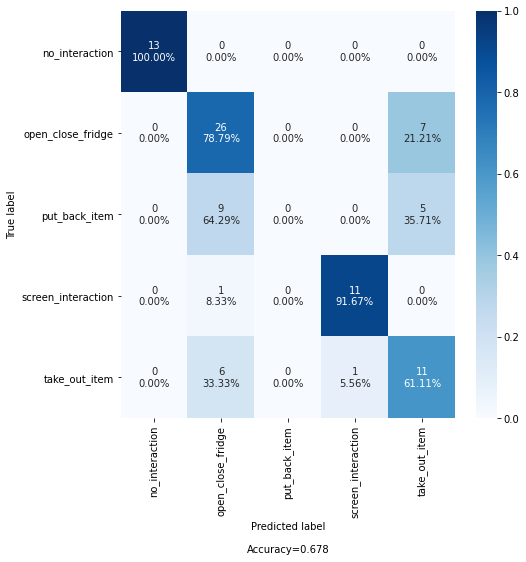

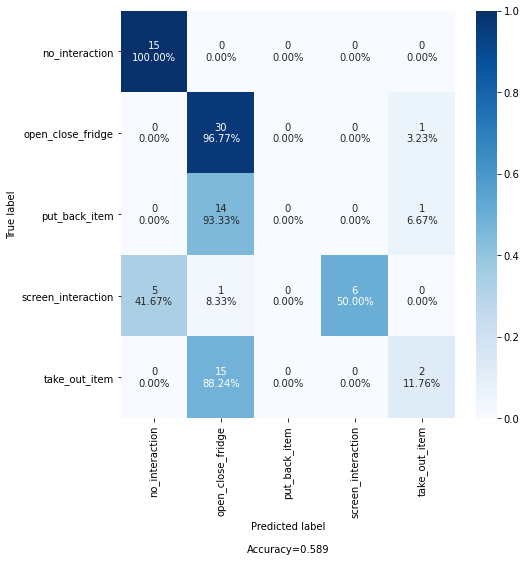

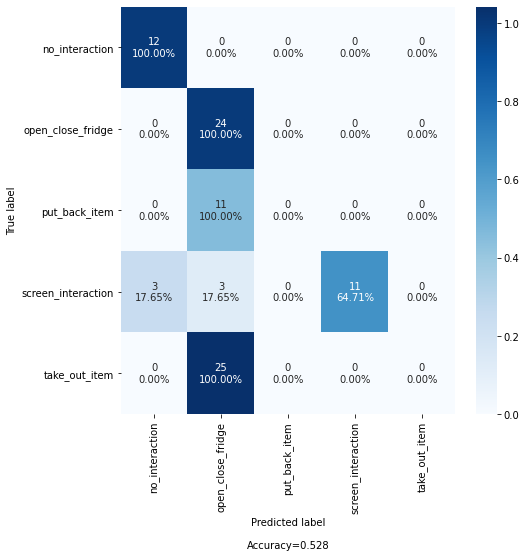

OvRLinearSVC


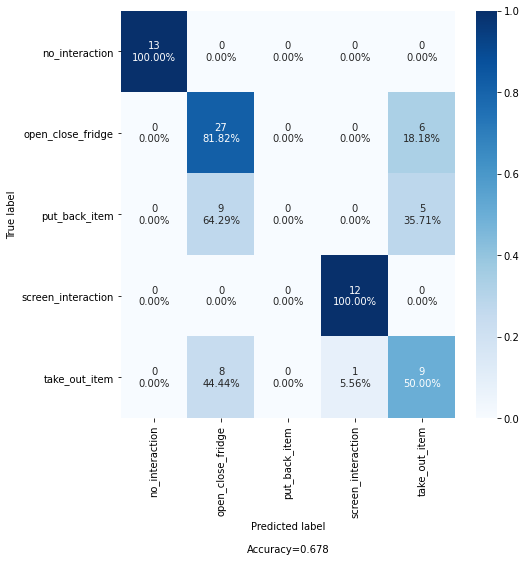

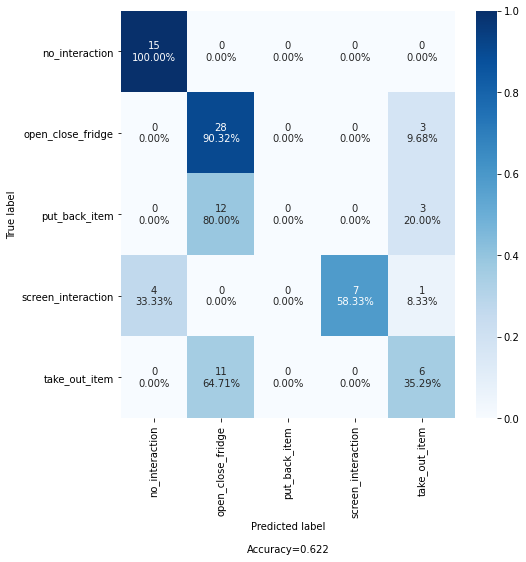

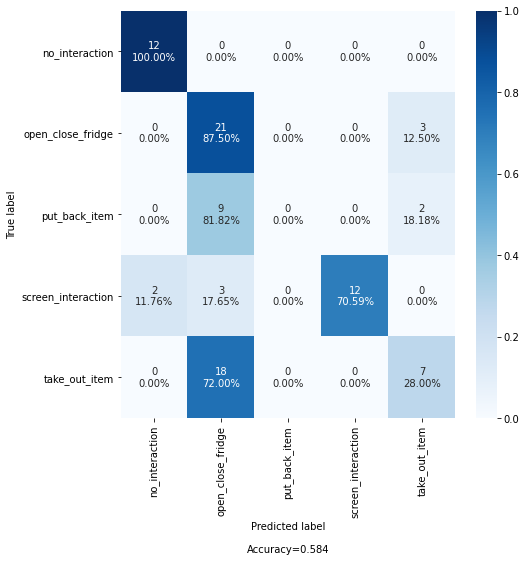

OvRGP


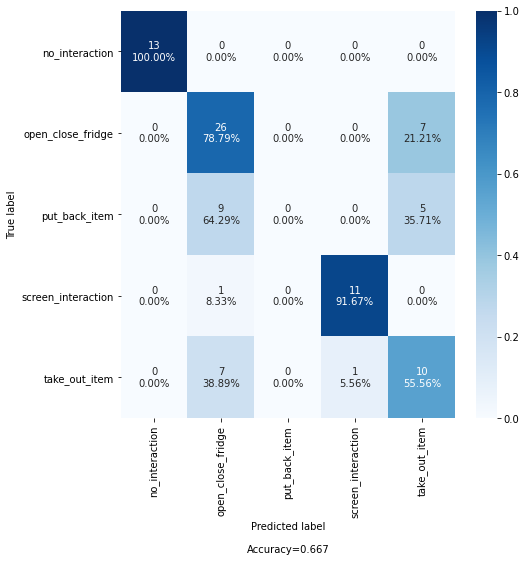

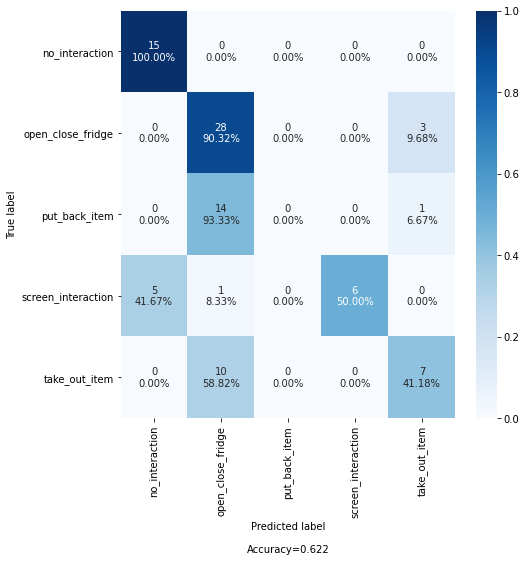

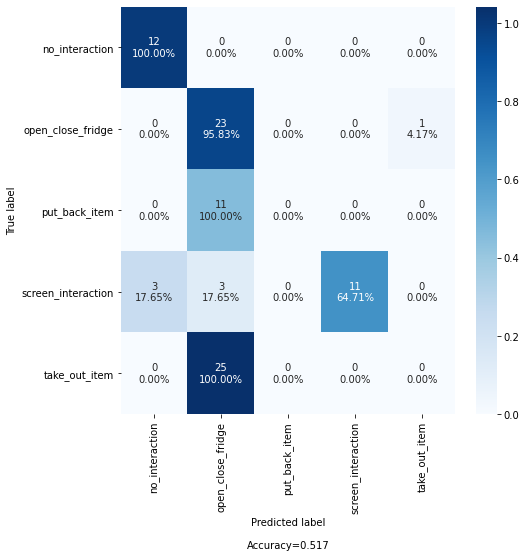

In [70]:
for feat in feat_types:
    print(feat)
    eval(feat, 'netml',"refrigerator", False, "both")

STATS
mp4
refrigerator
269
OvRLogReg


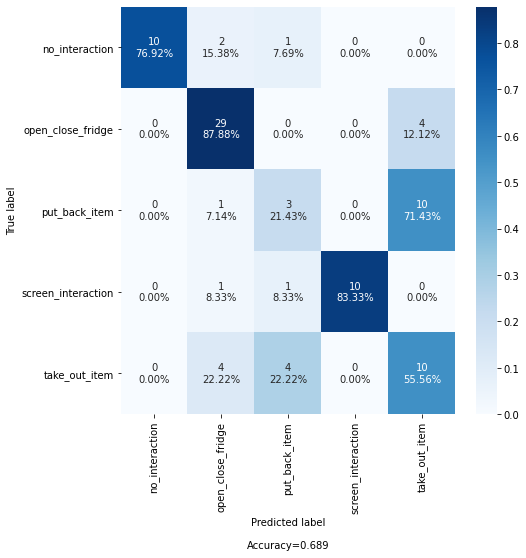

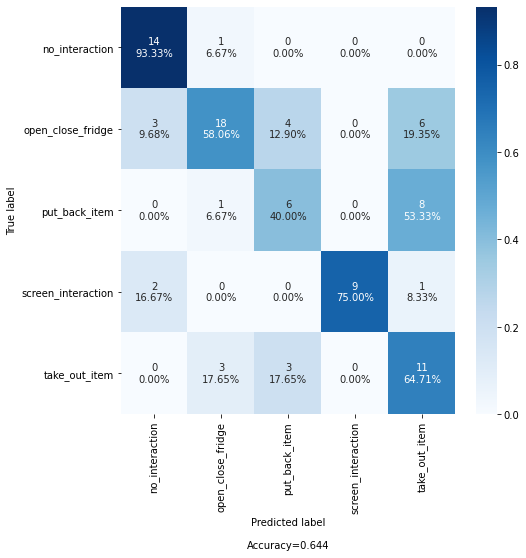

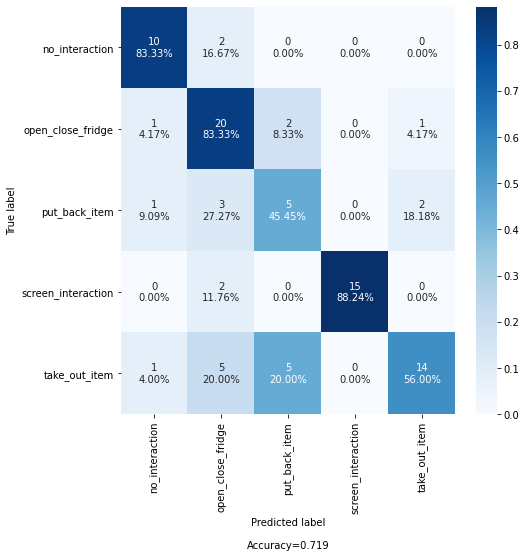

DecTree


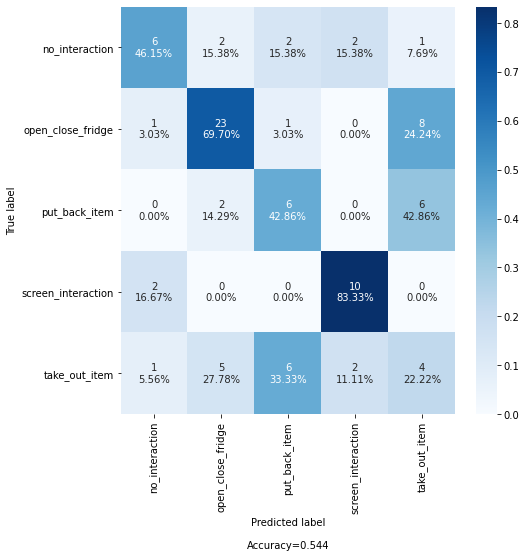

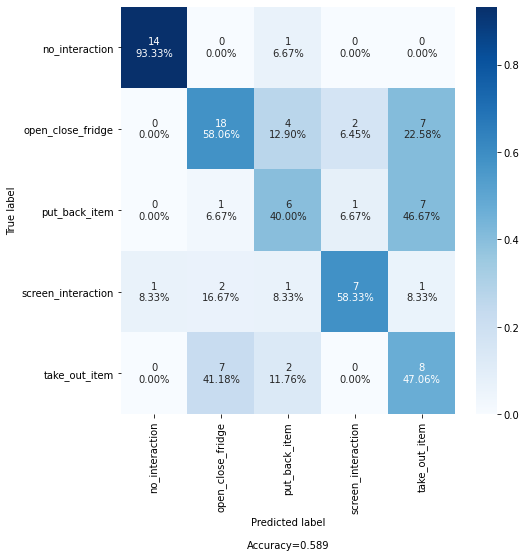

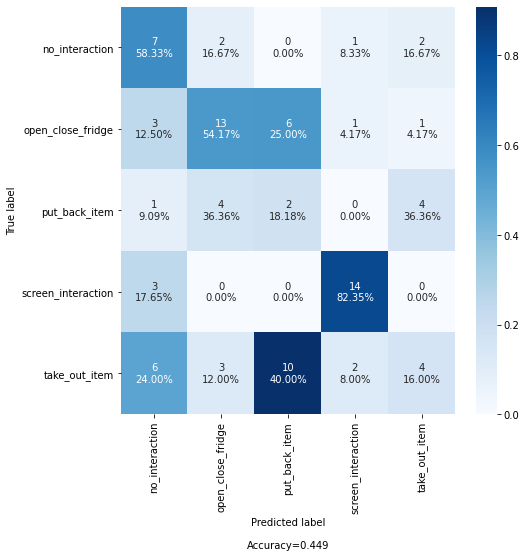

LogReg


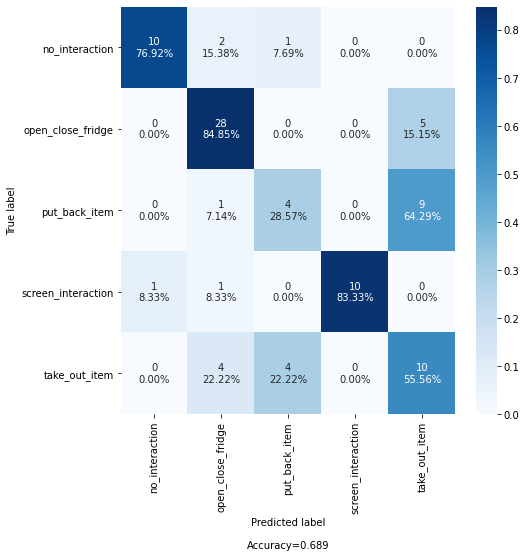

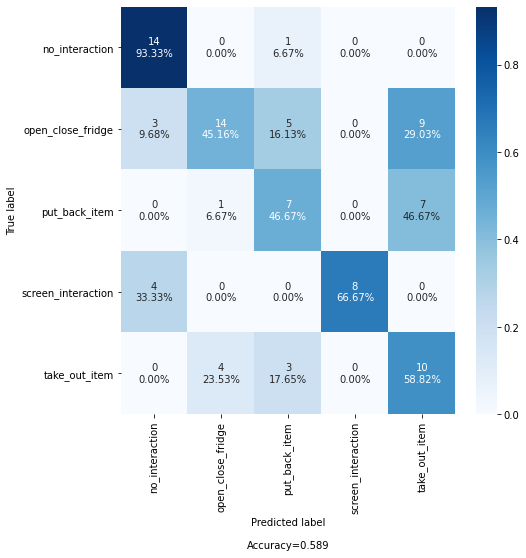

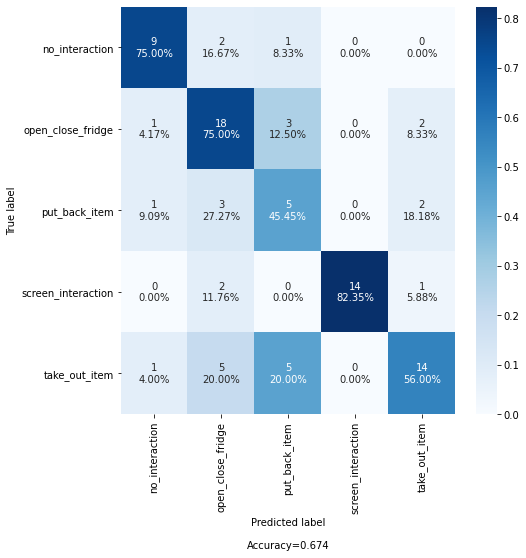

OvOSVC


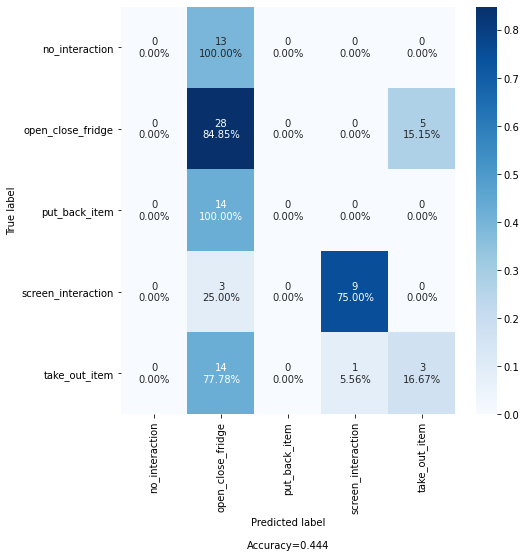

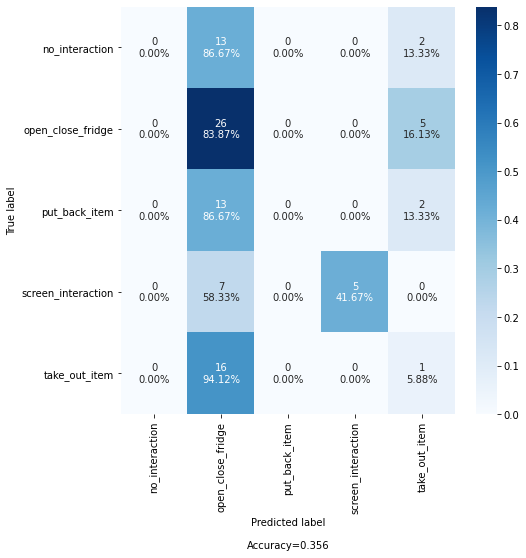

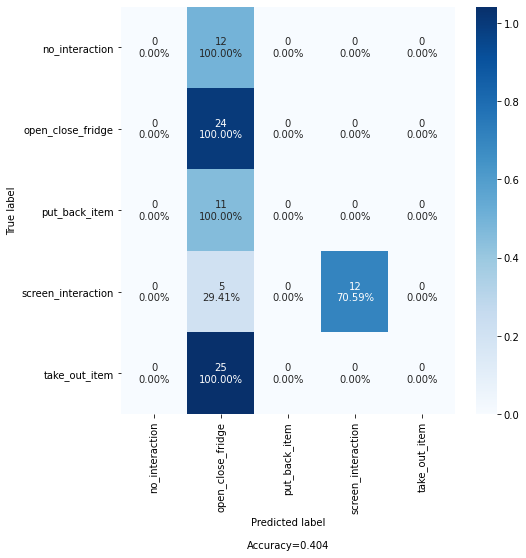

OvOGP


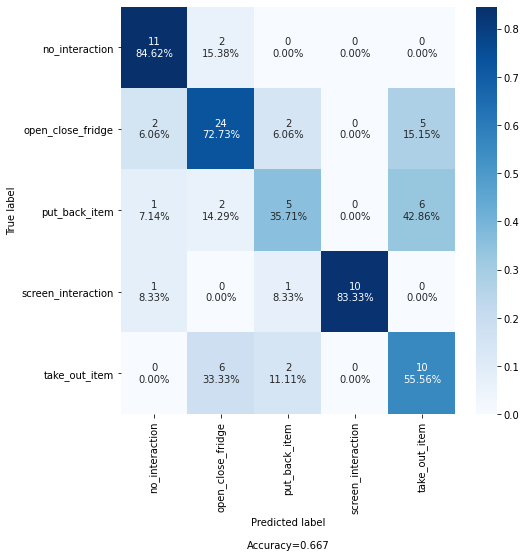

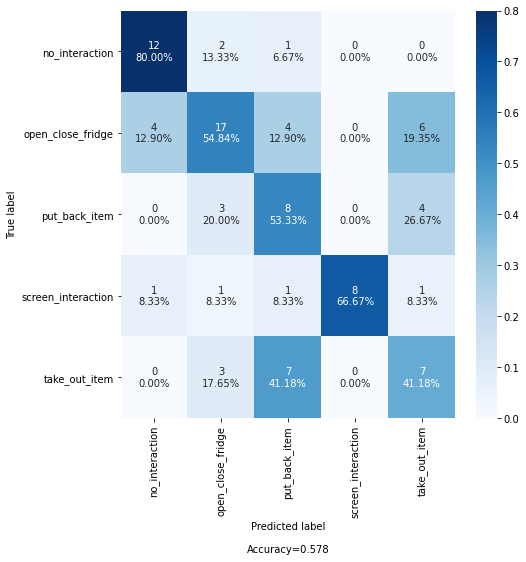

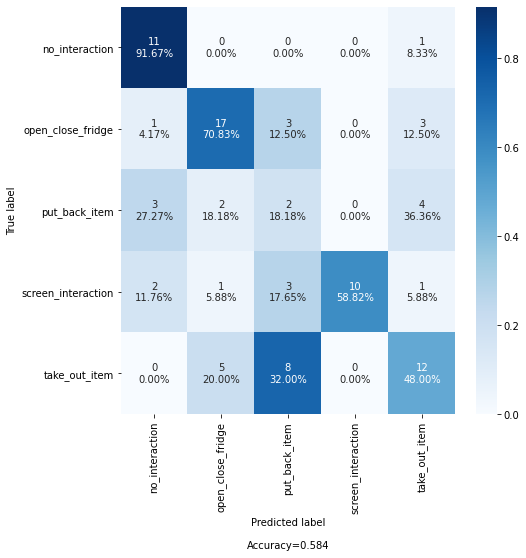

OvRLinearSVC


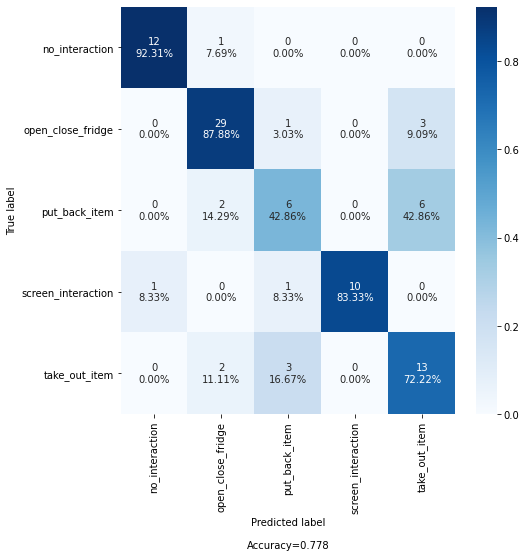

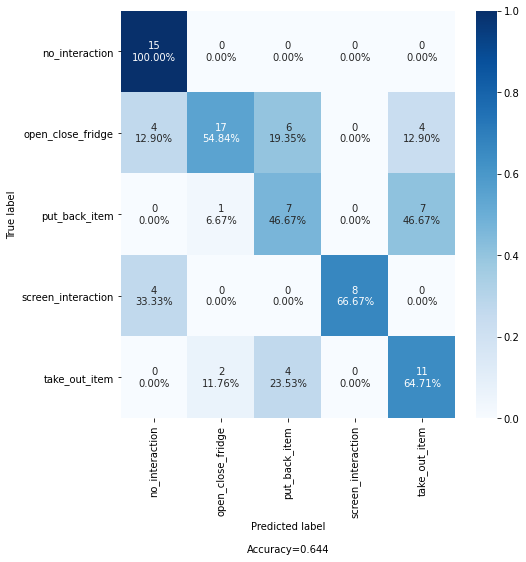

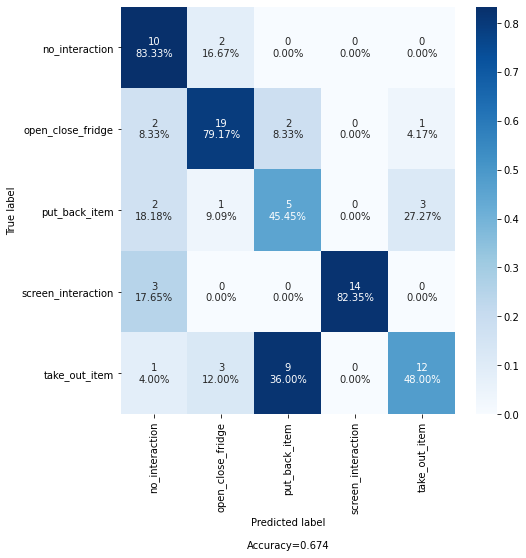

OvRGP


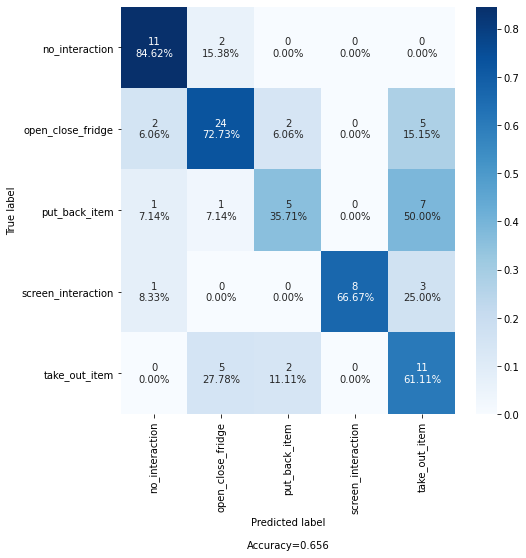

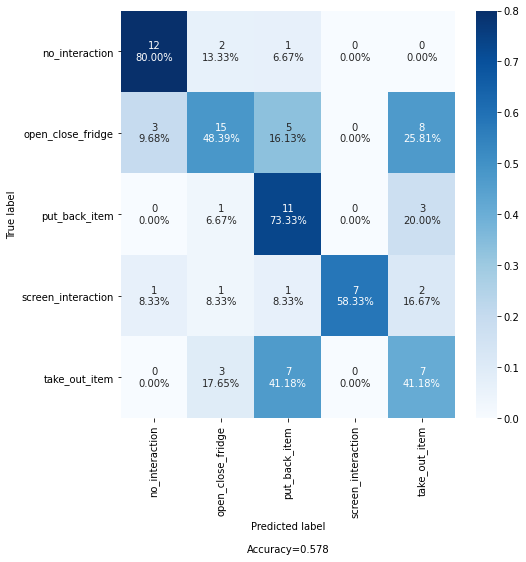

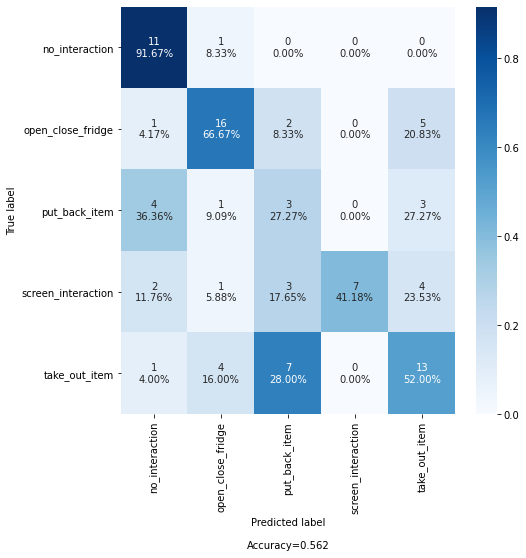

In [71]:
for feat in feat_types:
    print(feat)
    eval(feat, 'mp4',"refrigerator", True, "mp4", False)

STATS
mkv
refrigerator
269
OvRLogReg


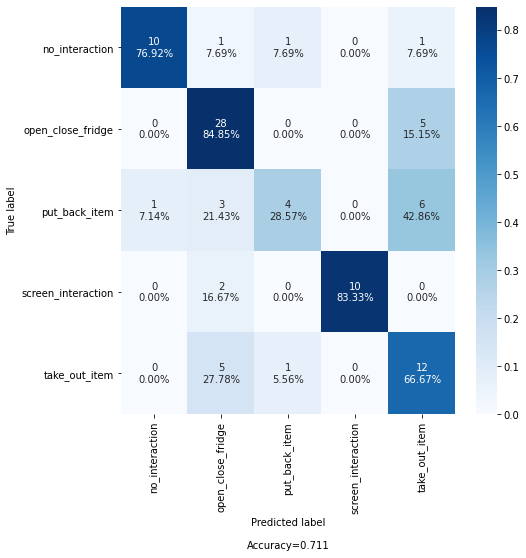

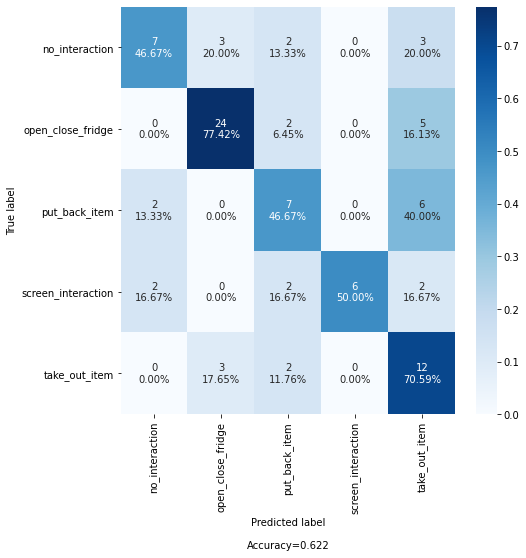

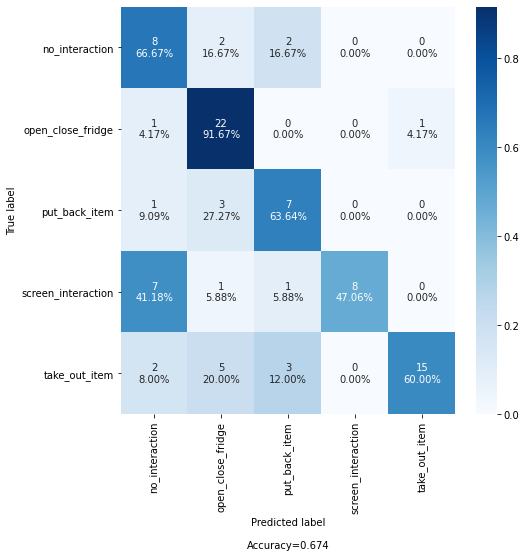

DecTree


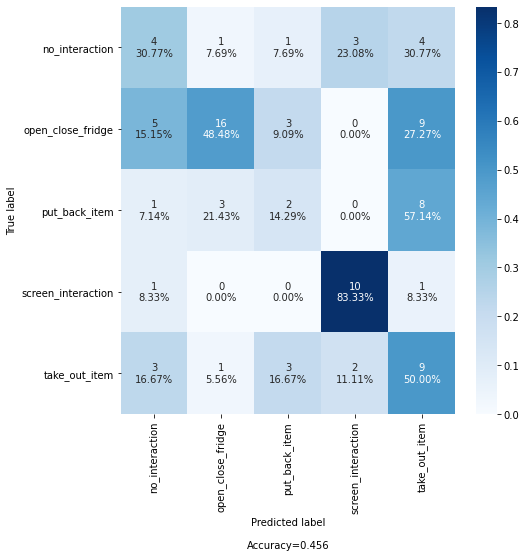

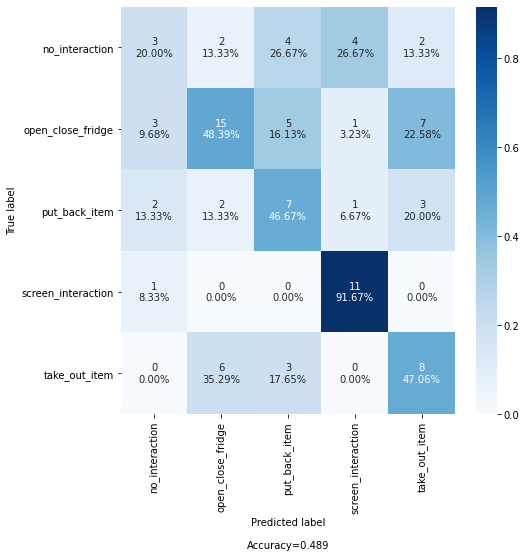

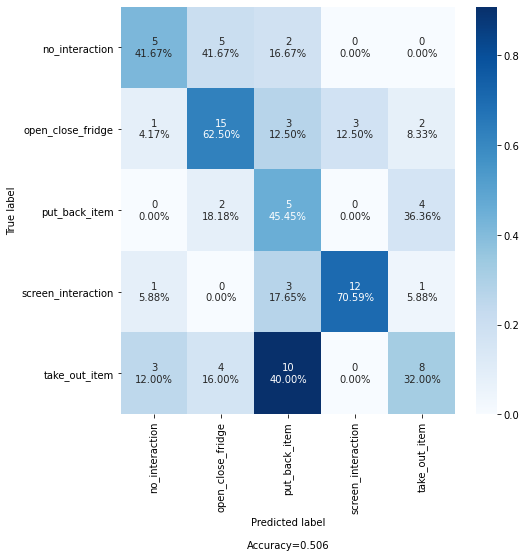

LogReg


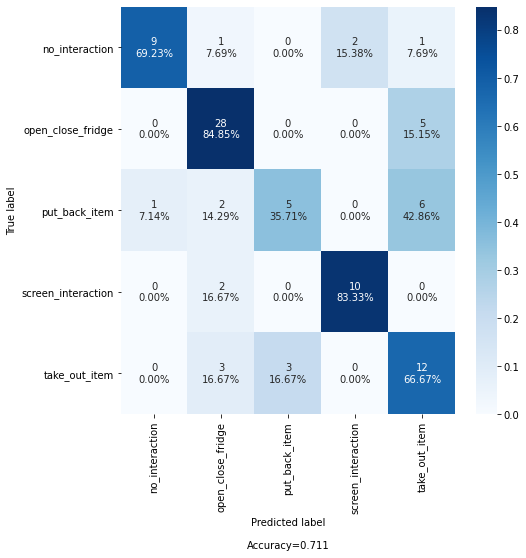

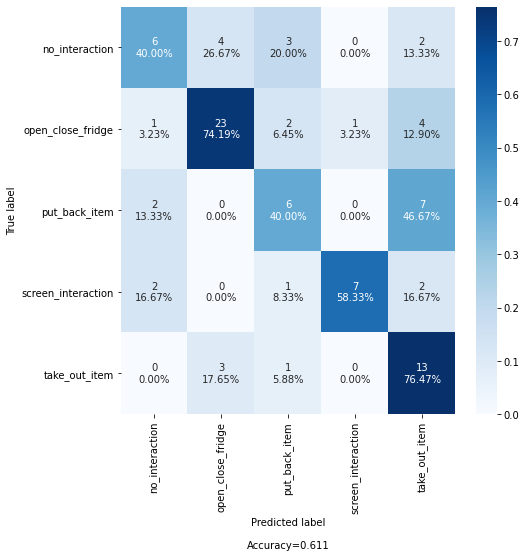

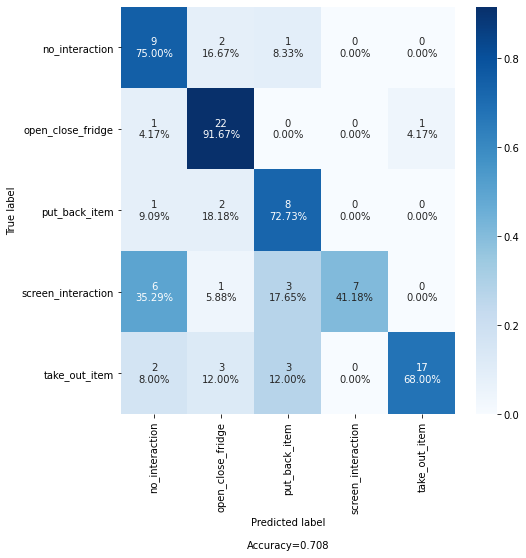

OvOSVC


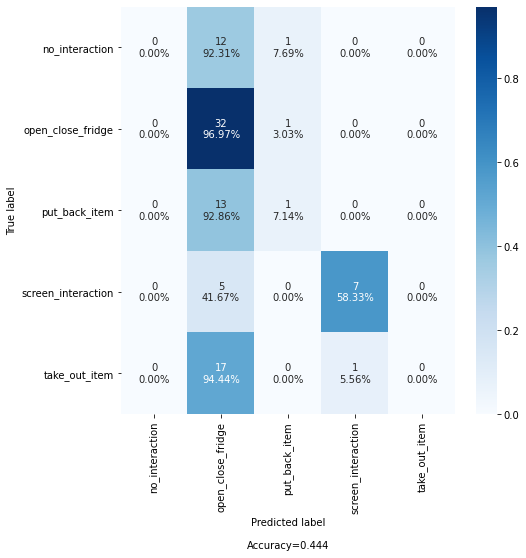

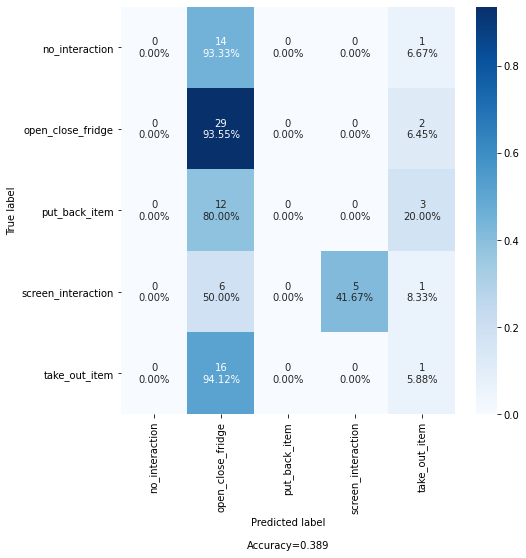

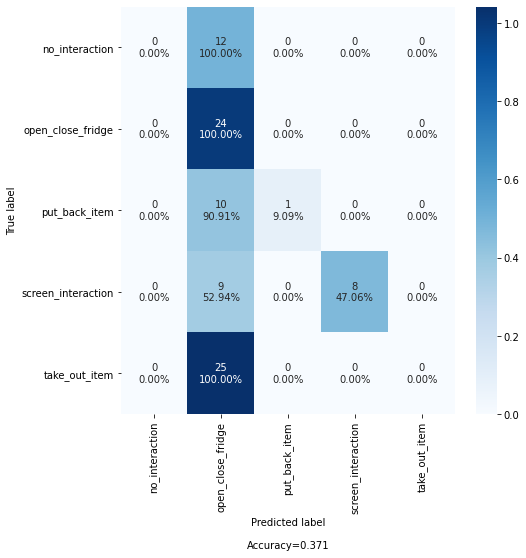

OvOGP


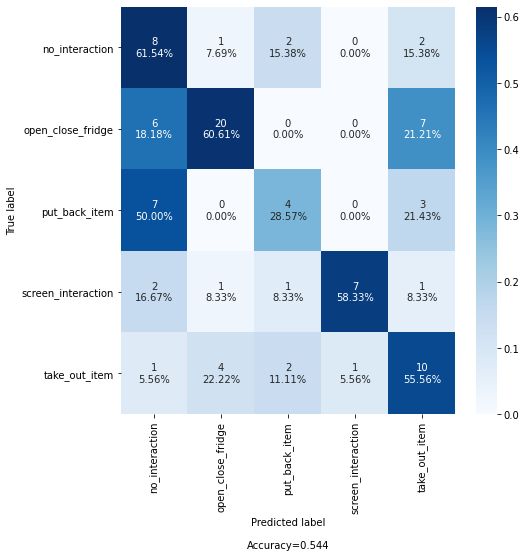

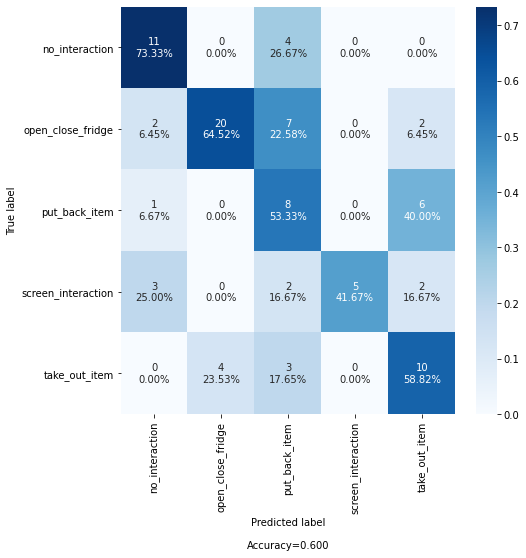

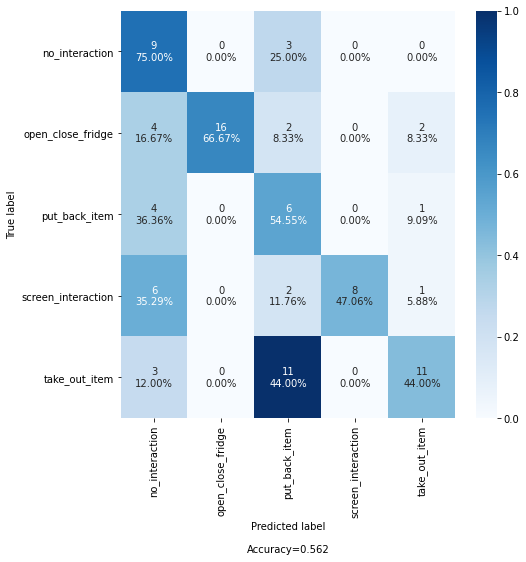

OvRLinearSVC


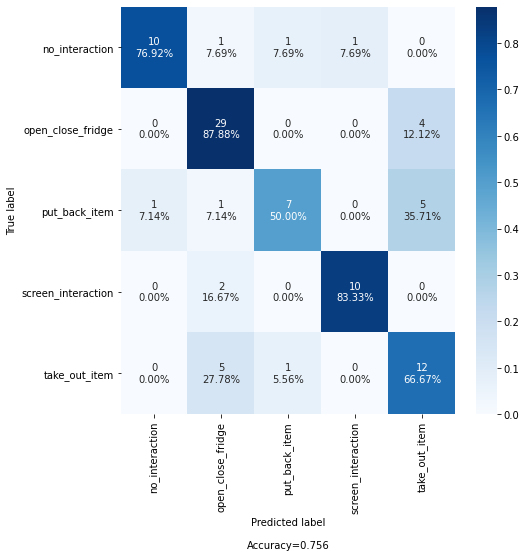

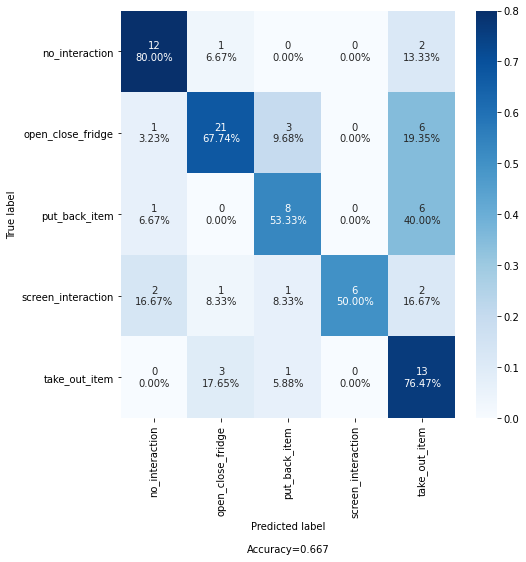

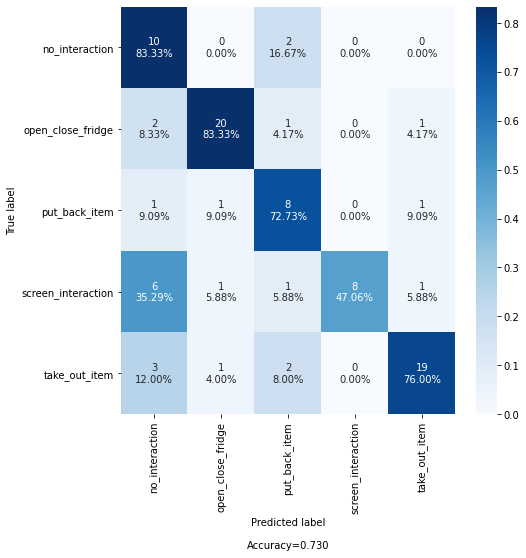

OvRGP


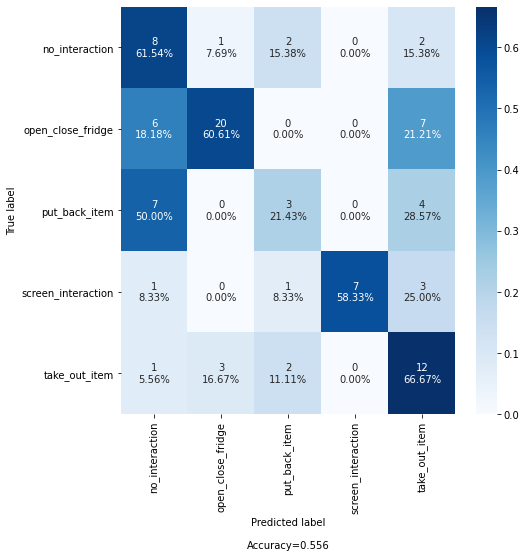

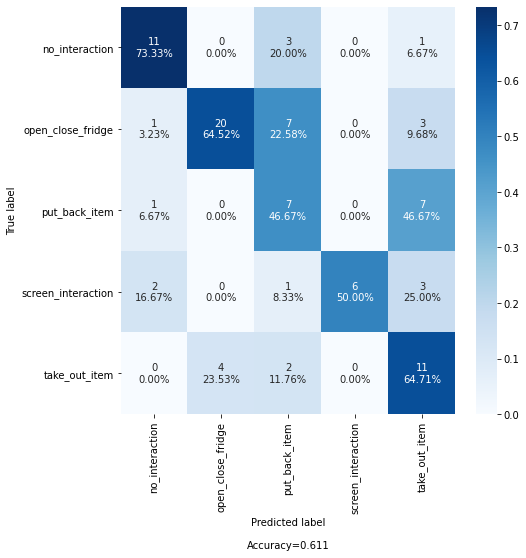

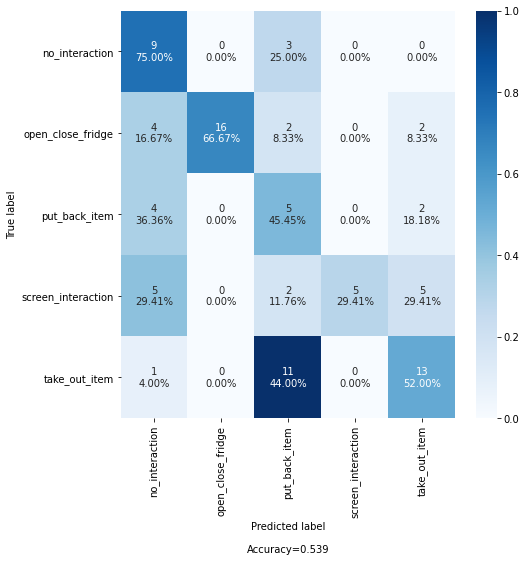

In [72]:
for feat in feat_types:
    print(feat)
    eval(feat, 'mkv',"refrigerator", True, "mkv", False)

STATS
mkv
refrigerator
269
OvRLogReg


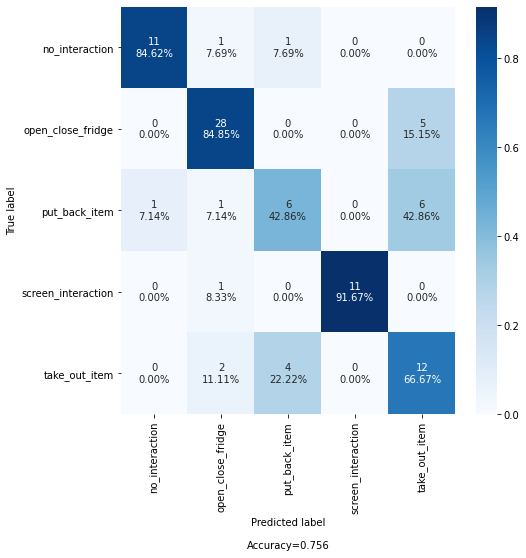

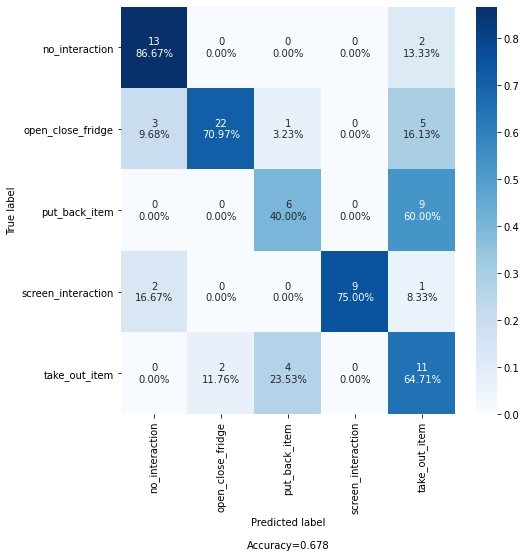

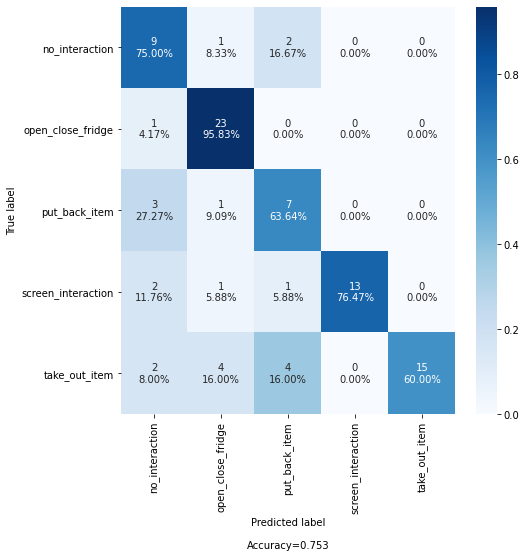

DecTree


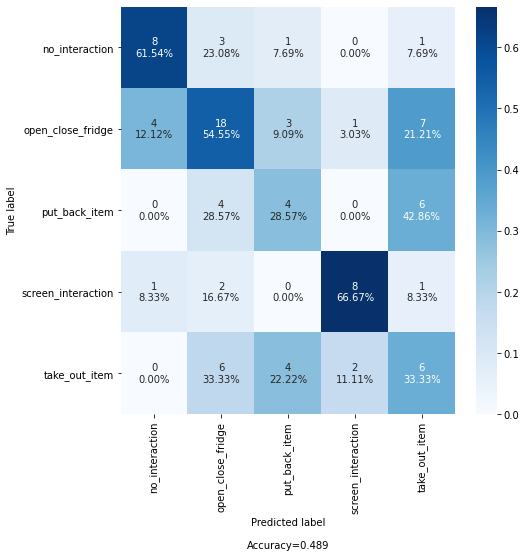

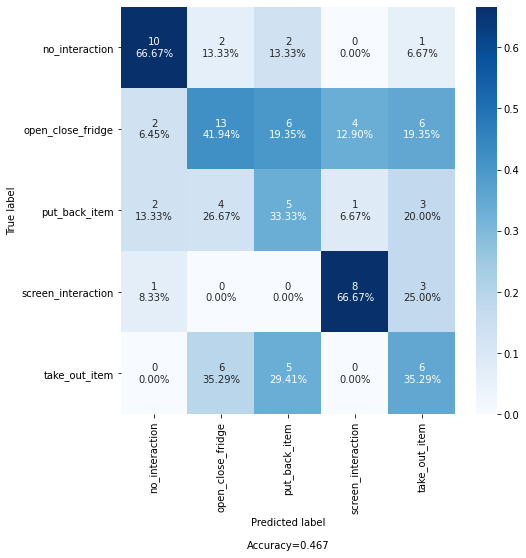

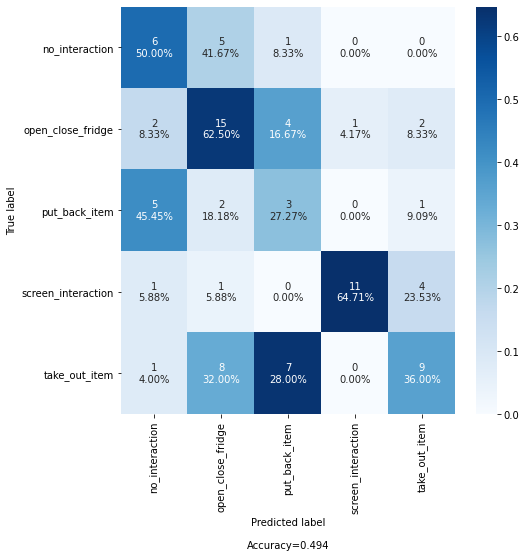

LogReg


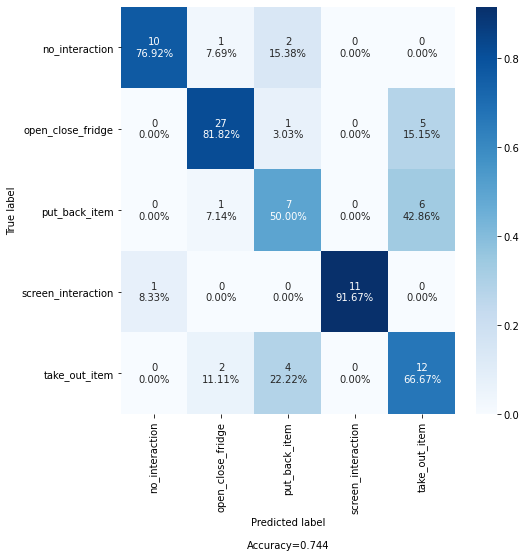

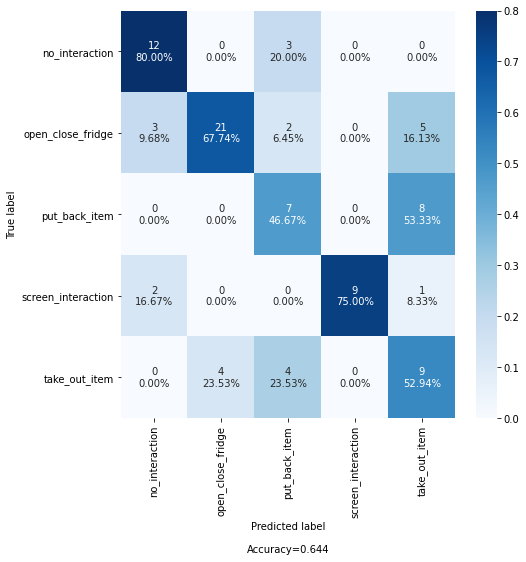

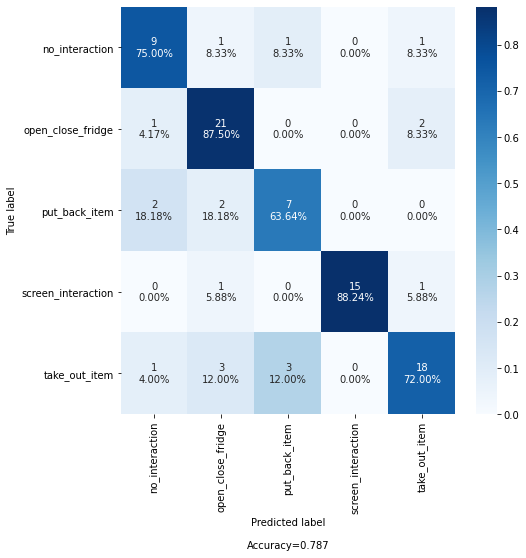

OvOSVC


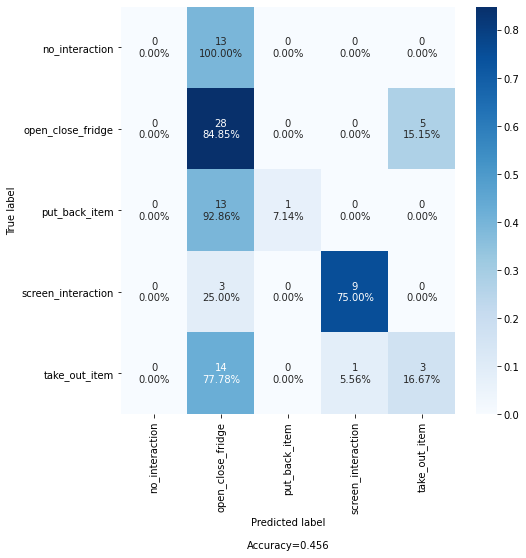

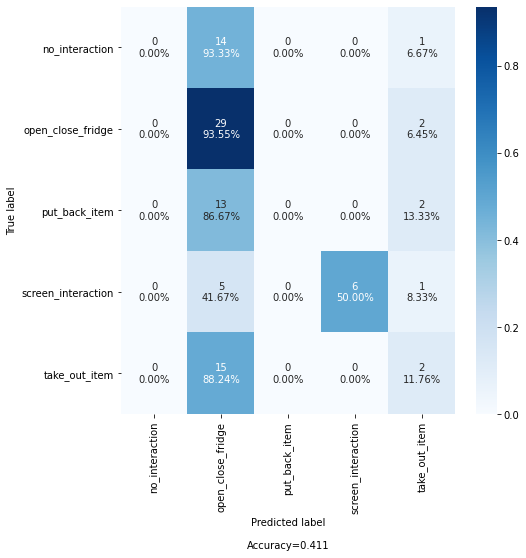

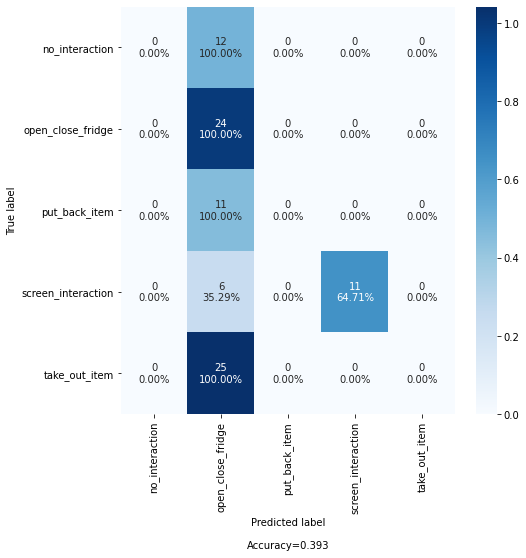

OvOGP


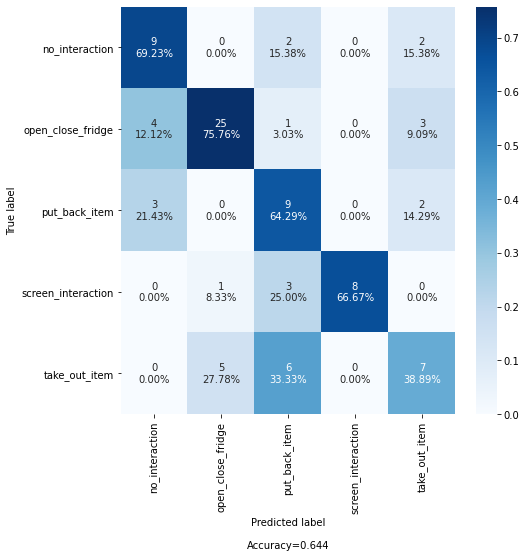

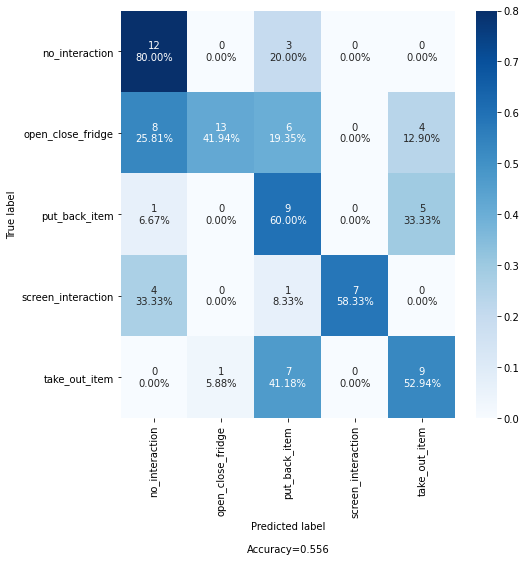

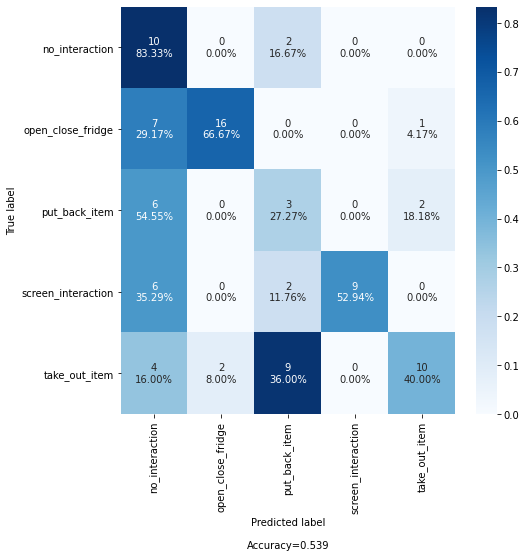

OvRLinearSVC


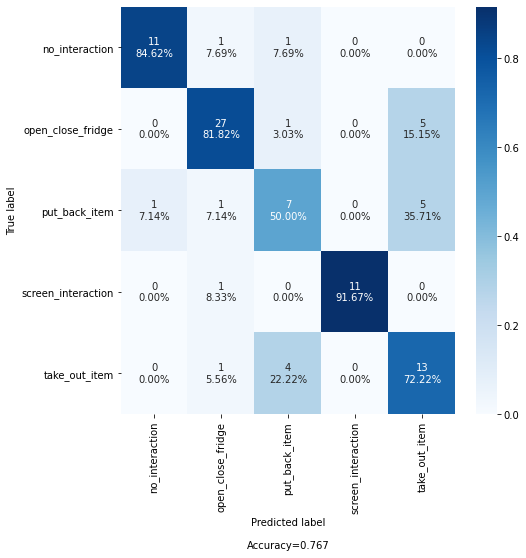

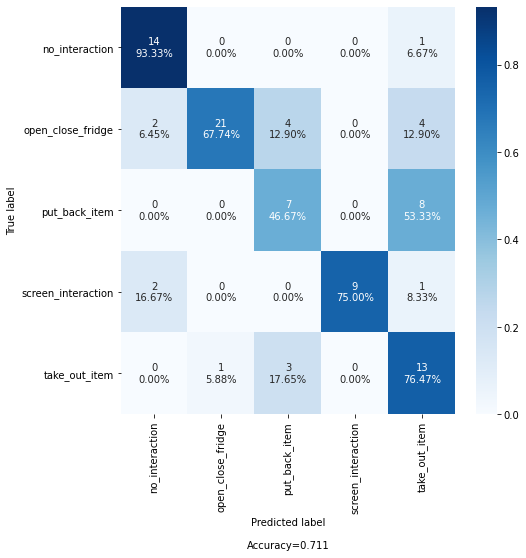

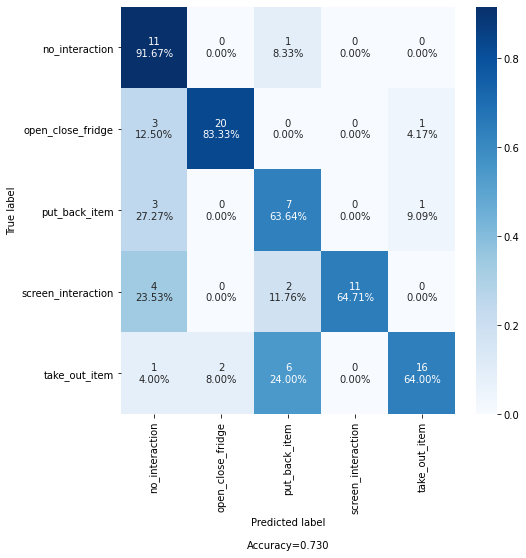

OvRGP


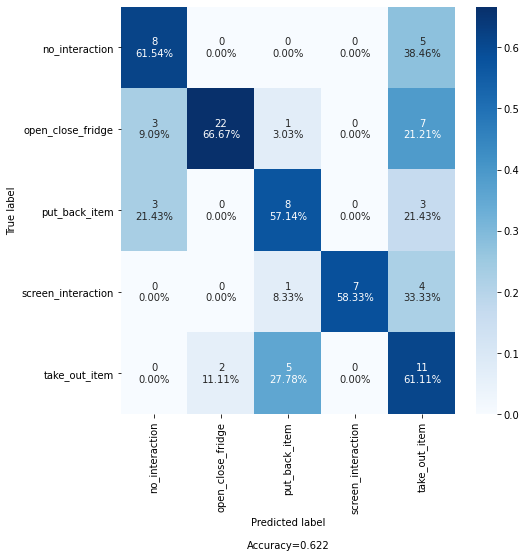

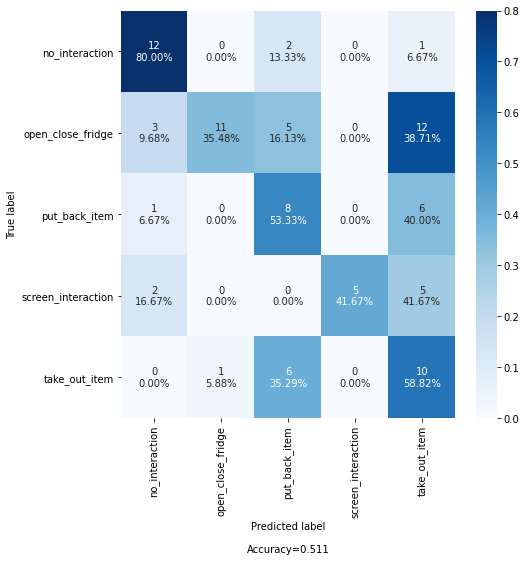

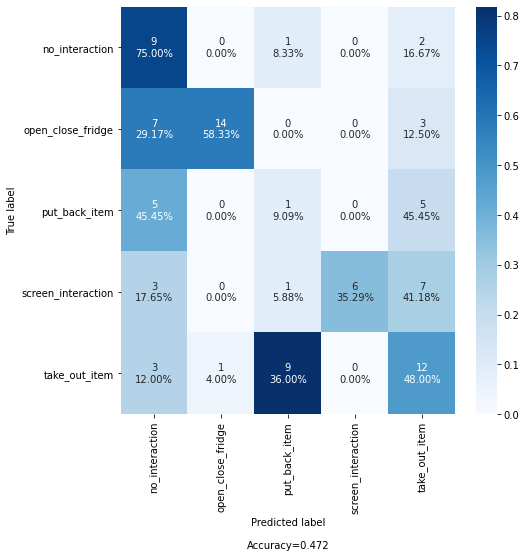

In [73]:
for feat in feat_types:
    print(feat)
    eval(feat, 'mkv',"refrigerator", True, "both", False)

## Nestcam

netml
nestcam
150
OvRLogReg


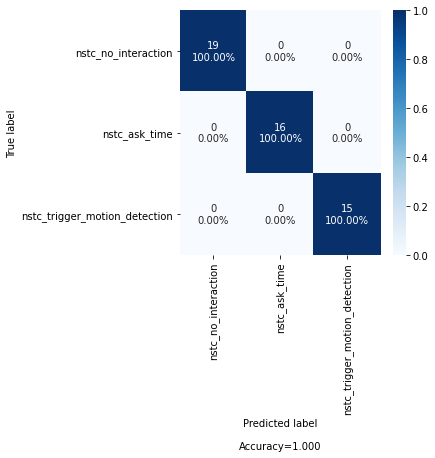

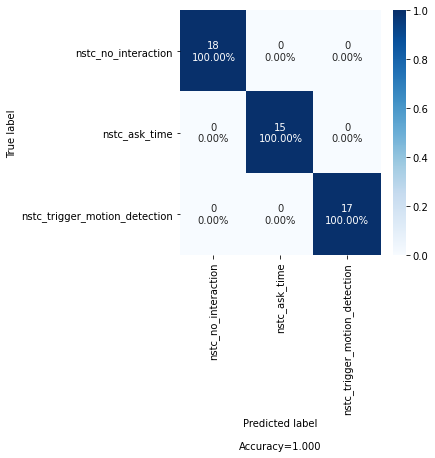

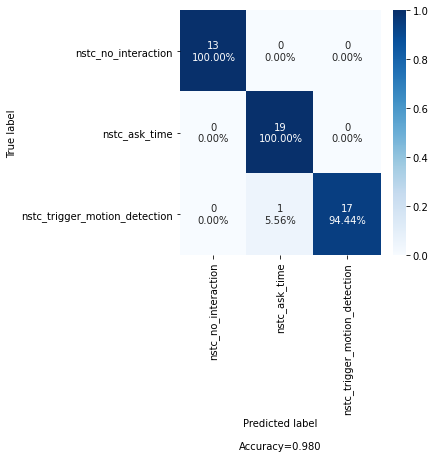

mp4+netml
nestcam
150
OvRLogReg


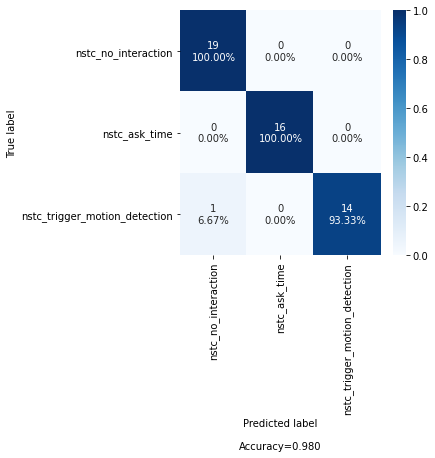

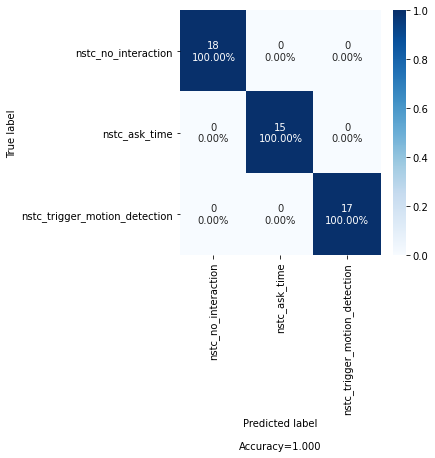

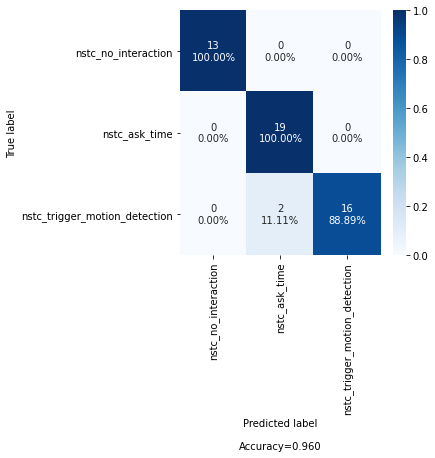

mkv+netml
nestcam
150
OvRLogReg


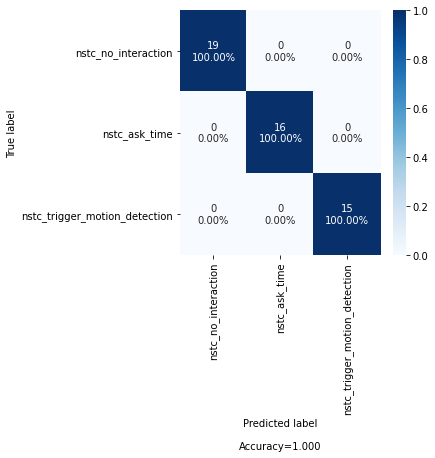

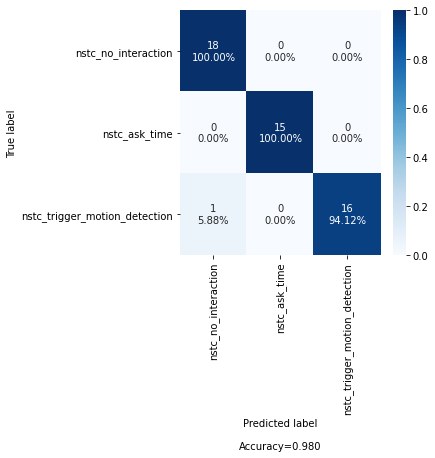

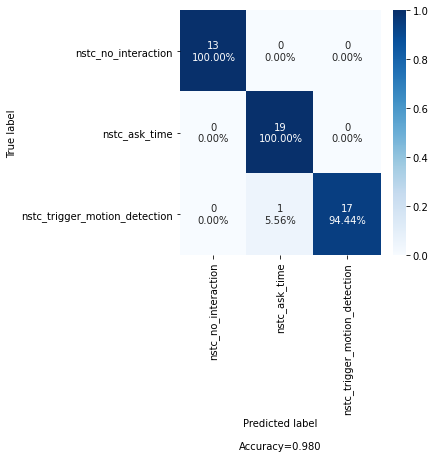

both+netml
nestcam
150
OvRLogReg


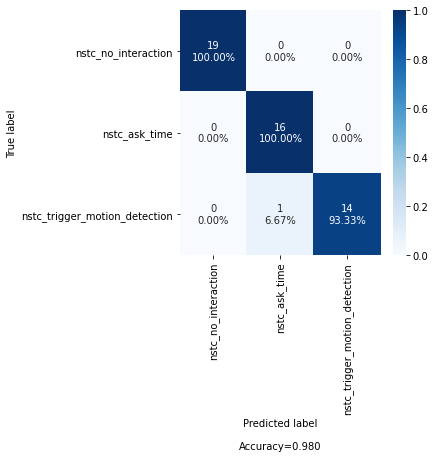

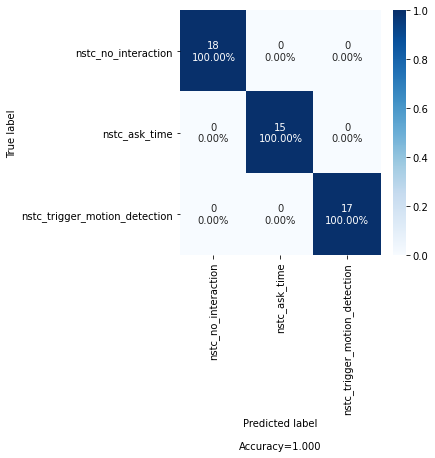

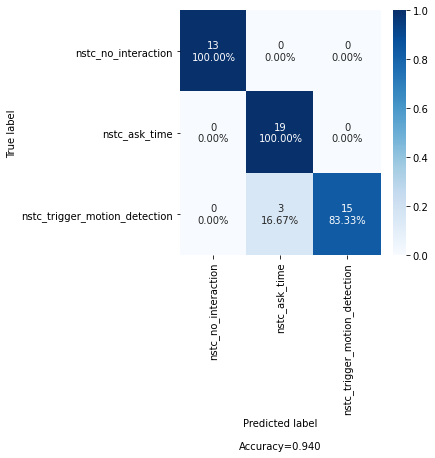

mp4
nestcam
150
OvRLogReg


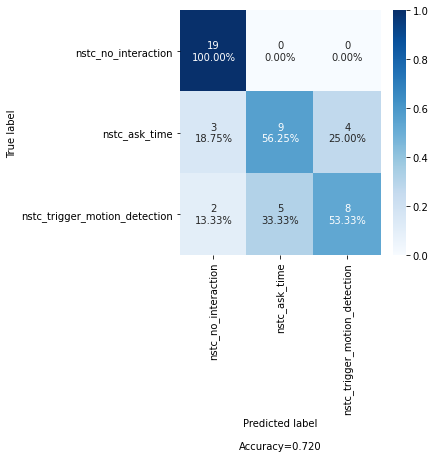

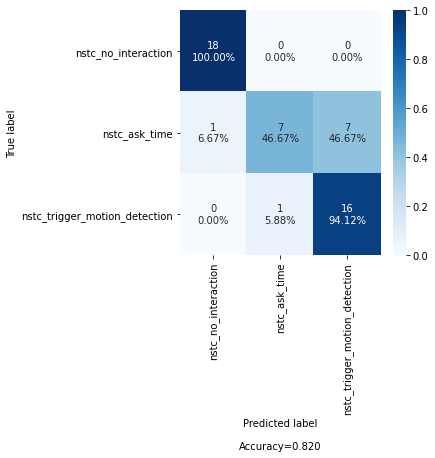

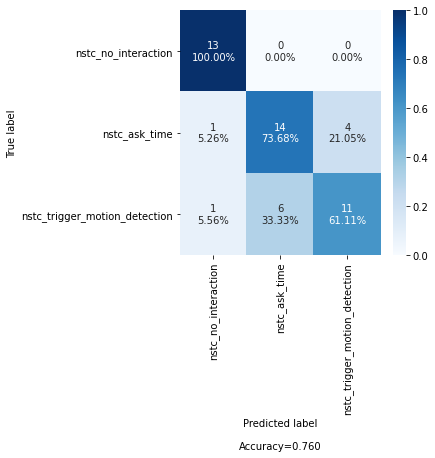

mkv
nestcam
150
OvRLogReg


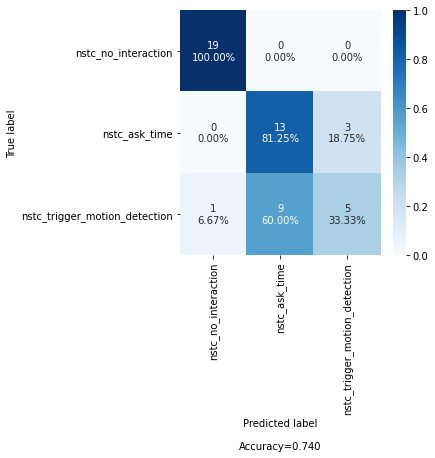

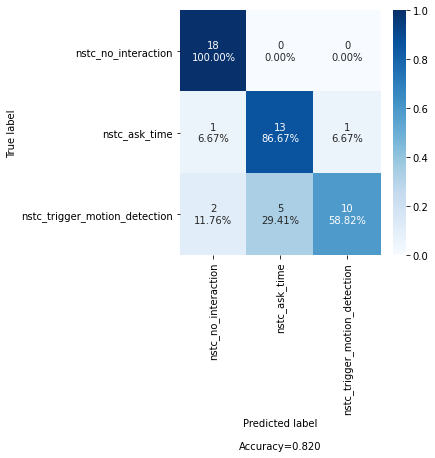

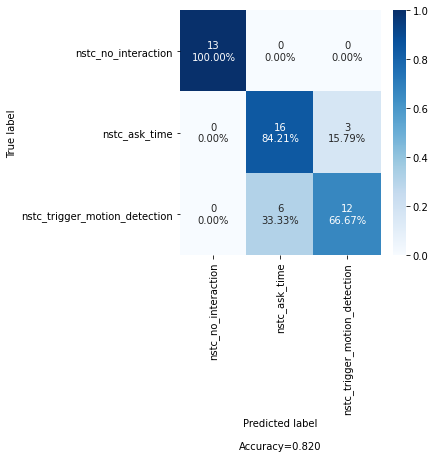

both
nestcam
150
OvRLogReg


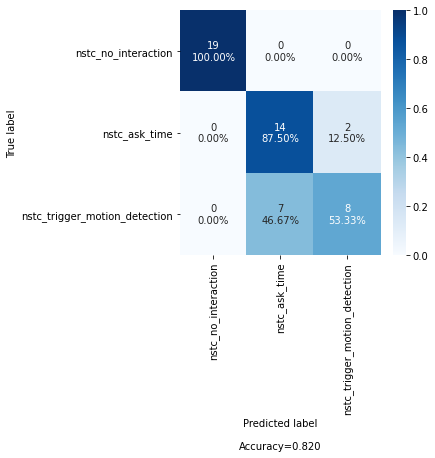

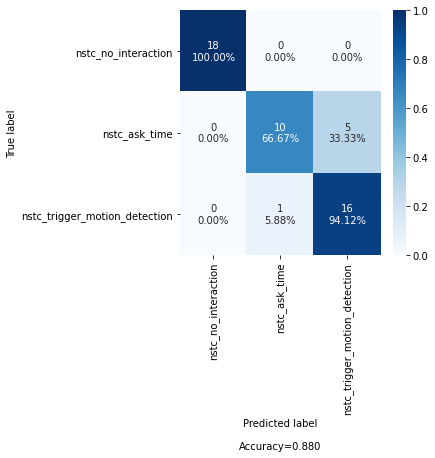

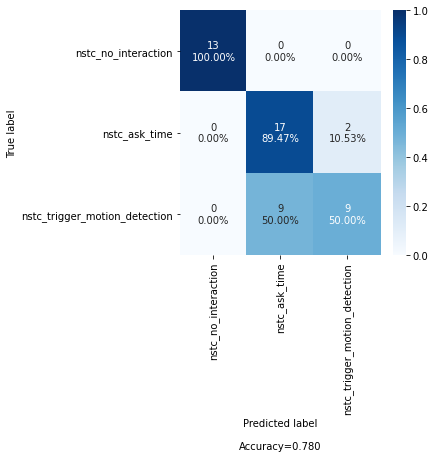

0         1         2         3         4         5         6     \
0    0.564748  0.588467  0.429143  0.449651  0.289598  0.614363  0.785097   
1    0.566935  0.622850  0.410441  0.408082  0.262495  0.615754  0.773010   
2    0.586601  0.555087  0.431843  0.416509  0.245027  0.657998  0.823932   
3    0.501620  0.556504  0.383126  0.423608  0.549948  0.315010  0.511477   
4    0.645141  0.600398  0.442419  0.451351  0.313805  0.623703  0.800962   
..        ...       ...       ...       ...       ...       ...       ...   
145  0.551824  0.506801  0.351919  0.544117  0.232361  0.535746  0.833027   
146  0.374063  0.353401  0.726112  0.259446  0.216642  0.774151  0.587320   
147  0.424702  0.582264  0.377877  0.586191  0.085841  0.569780  0.802410   
148  0.624354  0.646601  0.420388  0.515017  0.246442  0.734479  0.888648   
149  0.607144  0.534144  0.714426  0.218769  0.411426  0.891377  0.528074   

         7         8         9     ...      8182      8183      8184  \
0    0.685879  0.819699  0.397092  ...  0.592280  0.452629  0.422617   
1    0.690403  0.774804  0.428474  ...  0.602063  0.391059  0.450311   
2    0.760769  0.837577  0.397011  ...  0.591020  0.517411  0.397873   
3    0.262767  0.658774  0.467812  ...  0.599883  0.266507  0.429376   
4    0.786948  0.840235  0.370495  ...  0.602420  0.374794  0.375244   
..        ...       ...       ...  ...       ...       ...       ...   
145  0.759434  0.696634  0.387771  ...  0.584125  0.452007  0.195114   
146  0.559354  0.558934  0.455820  ...  0.582598  0.444904  0.238138   
147  0.797401  0.817979  0.383756  ...  0.598162  0.393420  0.388852   
148  0.809306  0.787509  0.396050  ...  0.596830  0.437038  0.240457   
149  0.648041  0.653083  0.577928  ...  0.592655  0.459807  0.127955   

         8185      8186      8187      8188      8189      8190      8191  
0    0.287973  0.000000  0.847763  0.245750  0.455926  0.653627  0.470403  
1    0.287973  0.000000  0.821286  0.299696  0.455926  0.690997  0.456027  
2    0.287973  0.000000  0.826741  0.287351  0.455926  0.650114  0.561461  
3    0.287973  0.000000  0.828659  0.277703  0.455926  0.688826  0.482853  
4    0.287973  0.000000  0.782513  0.260919  0.455926  0.707240  0.494803  
..        ...       ...       ...       ...       ...       ...       ...  
145  0.287973  1.000000  0.710908  0.104608  0.454405  0.626984  0.783548  
146  0.340707  0.269421  0.728137  0.046199  0.524006  0.710317  0.841085  
147  0.287973  0.000000  0.690524  0.367386  0.441482  0.573946  0.821956  
148  0.295714  0.072548  1.000000  0.067088  0.425710  0.594160  0.454450  
149  0.309334  0.803611  0.729229  0.171636  0.493190  0.674545  0.411360  

[150 rows x 8192 columns]

In [74]:
act_label = {"nstc_no_interaction": 8, 
             "nstc_ask_time": 9, 
             "nstc_trigger_motion_detection": 10}

classifiers = {"OvRLogReg": OneVsRestClassifier(LogisticRegression(random_state=rng))}
eval('STATS', 'netml', "nestcam", False, "both", True)
eval('STATS', 'mp4+netml', "nestcam", True, "mp4", True)
eval('STATS', 'mkv+netml', "nestcam", True, "mkv", True)
eval('STATS', 'both+netml', "nestcam", True, "both", True)
eval('STATS', 'mp4', "nestcam", True, "mp4", False)
eval('STATS', 'mkv', "nestcam", True, "mkv", False)
eval('STATS', 'both', "nestcam", True, "both", False)

## Alexa

netml
alexa
150
OvRLogReg


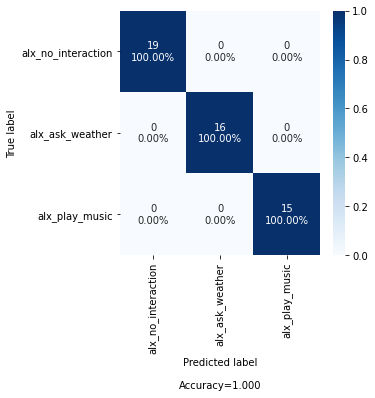

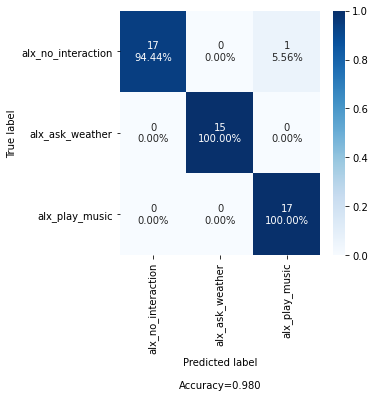

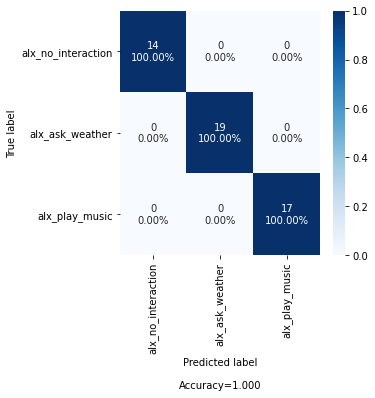

mp4+netml
alexa
150
OvRLogReg


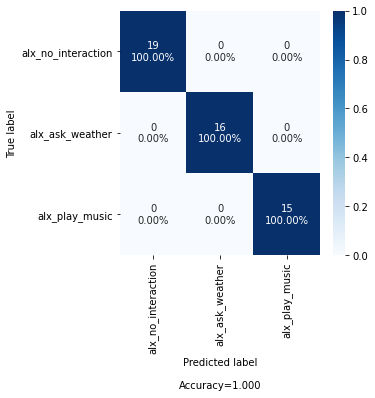

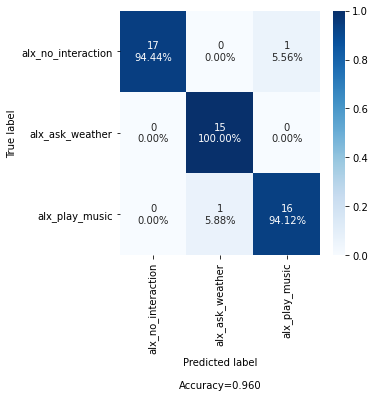

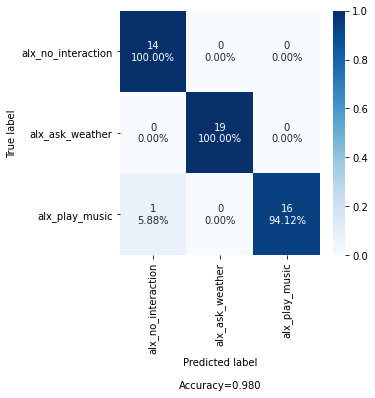

mkv+netml
alexa
150
OvRLogReg


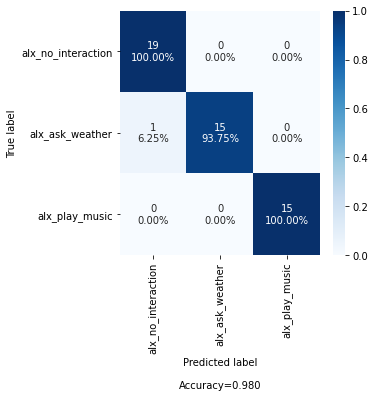

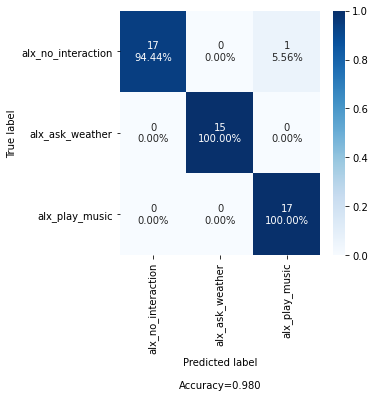

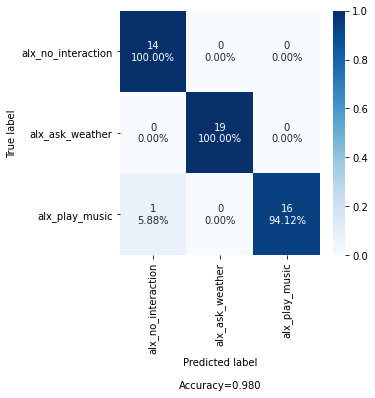

both+netml
alexa
150
OvRLogReg


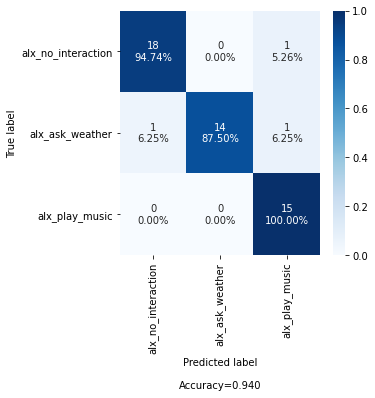

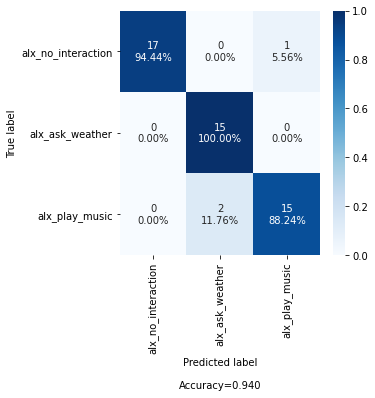

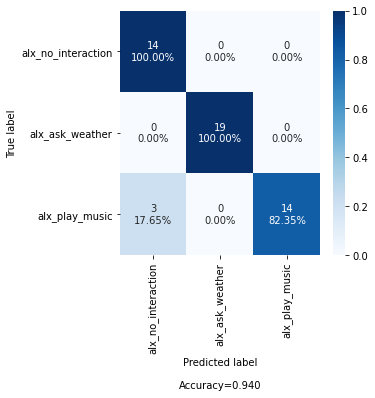

mp4
alexa
150
OvRLogReg


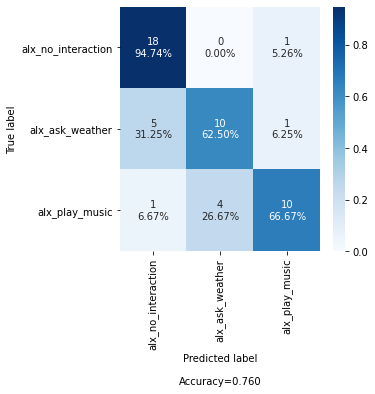

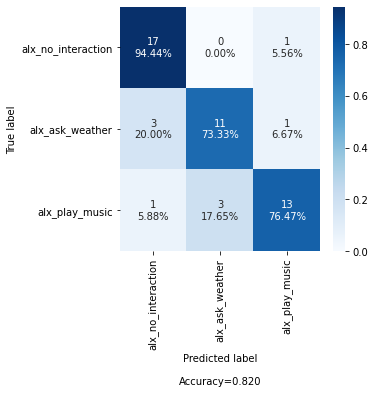

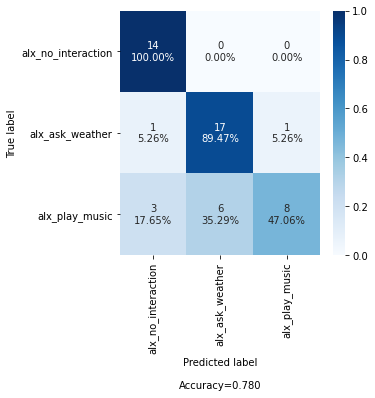

mkv
alexa
150
OvRLogReg


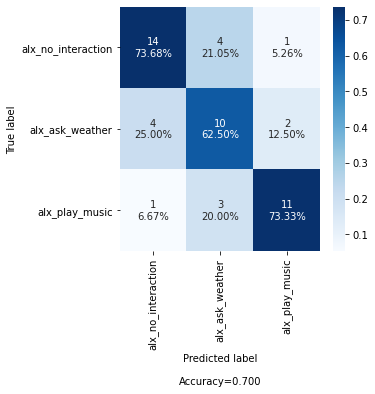

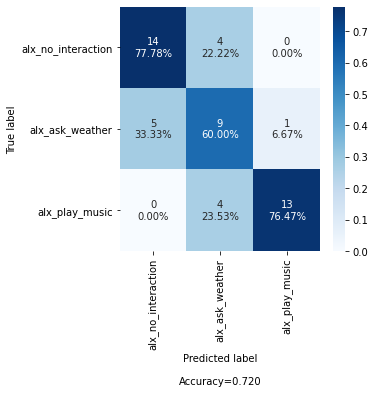

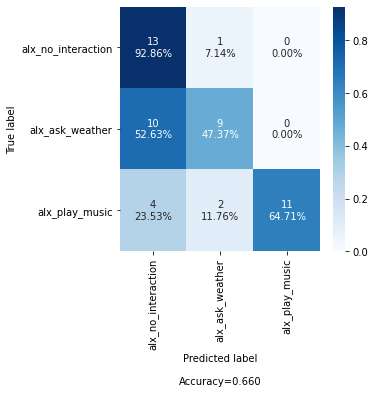

both
alexa
150
OvRLogReg


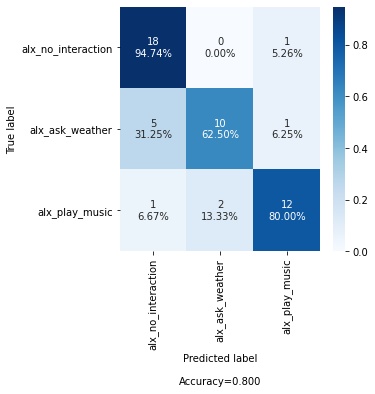

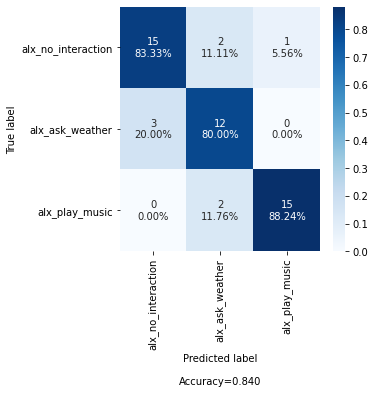

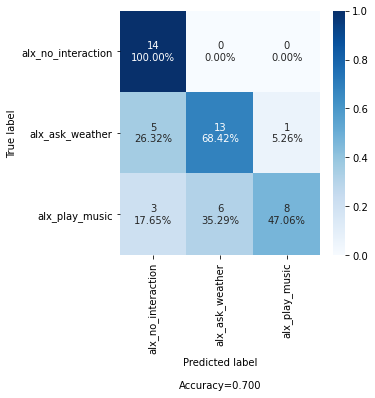

0         1         2         3         4         5         6     \
0    0.353975  0.260953  0.133039  0.541828  0.439458  0.413725  0.631203   
1    0.517486  0.437109  0.196230  0.510687  0.419441  0.527780  0.797062   
2    0.503013  0.527043  0.220112  0.564509  0.365408  0.557914  0.716125   
3    0.488395  0.431684  0.212590  0.544883  0.360189  0.583176  0.760048   
4    0.487678  0.481623  0.202447  0.512240  0.413617  0.521874  0.748542   
..        ...       ...       ...       ...       ...       ...       ...   
145  1.000000  0.336694  0.217662  0.308610  1.000000  0.639970  0.587897   
146  0.454167  0.548951  0.200980  0.483602  0.371540  0.562258  0.730059   
147  0.475141  0.393821  0.185134  0.478630  0.412582  0.668904  0.757234   
148  0.395442  0.452556  0.187057  0.569173  0.377367  0.519186  0.711581   
149  0.511883  0.405780  0.204923  0.466160  0.406275  0.509710  0.761116   

         7         8         9     ...      8182      8183      8184  \
0    0.491753  0.787658  0.630374  ...  0.863758  0.440402  0.449645   
1    0.587543  0.854856  0.513149  ...  0.857825  0.445492  0.422325   
2    0.574678  0.829447  0.531767  ...  0.868522  0.528036  0.434309   
3    0.571455  0.827713  0.479444  ...  0.859517  0.462460  0.455636   
4    0.591559  0.824673  0.511017  ...  0.851439  0.533588  0.439459   
..        ...       ...       ...  ...       ...       ...       ...   
145  0.596686  0.676898  0.665459  ...  0.863070  0.572679  0.457236   
146  0.573479  0.806537  0.546671  ...  0.874203  0.597098  0.431260   
147  0.584575  0.771157  0.355601  ...  0.855190  0.538860  0.380115   
148  0.568788  0.801160  0.482745  ...  0.865461  0.544745  0.464441   
149  0.595970  0.788442  0.550647  ...  0.874727  0.570649  0.416161   

         8185  8186      8187      8188      8189      8190      8191  
0    0.767668   0.0  0.771266  0.292000  0.700544  0.468172  0.326407  
1    0.767668   0.0  0.735701  0.276201  0.761487  0.331732  0.765213  
2    0.767668   0.0  0.763938  0.291818  0.744928  0.419435  0.293107  
3    0.767668   0.0  0.800447  0.268684  0.732045  0.422097  0.415714  
4    0.767668   0.0  0.756922  0.317924  0.730758  0.315216  0.826535  
..        ...   ...       ...       ...       ...       ...       ...  
145  0.767668   0.0  0.775511  0.340436  0.689572  0.502822  0.697021  
146  0.767668   0.0  0.750724  0.330029  0.678186  0.490193  0.496430  
147  0.767668   0.0  0.703458  0.242405  0.700615  0.504637  0.588350  
148  0.767668   0.0  0.735182  0.316532  0.703328  0.451435  0.710674  
149  0.767668   0.0  0.720868  0.274203  0.693890  0.406399  0.538211  

[150 rows x 8192 columns]

In [75]:
act_label = {"alx_no_interaction": 5, 
             "alx_ask_weather": 6,
             "alx_play_music": 7}

classifiers = {"OvRLogReg": OneVsRestClassifier(LogisticRegression(random_state=rng))}
eval('STATS', 'netml', "alexa", False, "both")
eval('STATS', 'mp4+netml', "alexa", True, "mp4")
eval('STATS', 'mkv+netml', "alexa", True, "mkv")
eval('STATS', 'both+netml', "alexa", True, "both")
eval('STATS', 'mp4', "alexa", True, "mp4", False)
eval('STATS', 'mkv', "alexa", True, "mkv", False)
eval('STATS', 'both', "alexa", True, "both", False)